In [34]:
from datetime import datetime
from datetime import timedelta
import time

tu = timedelta(0)
tp = timedelta(0)

tu_atm = timedelta(0)
tu_pvt = timedelta(0)
tu_esp = timedelta(0)
tp_atm = timedelta(0)
tp_pvt = timedelta(0)
tp_esp = timedelta(0)

In [35]:
t1 = datetime.now()
start_time = datetime.now()

In [36]:
import pandas as pd
import numpy as np
import xlwings as xw
import os
import scipy.interpolate

from scipy.optimize import minimize
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import max_error
import matplotlib.dates
import matplotlib.pyplot as plt
import plotly
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

import dateparser
import statistics
import math

#%pylab inline
#%matplotlib inline

from IPython.display import Image
from pandas.plotting import register_matplotlib_converters

import calc_well_param.calc_func
import calc_well_param.ccalc_pvt
import calc_well_param.cpipe
import calc_well_param.cesp

In [37]:
# Настройка папок
# Рабочей папкой считаем папку выше \Скрипт
cCurrentPath_ = os.path.split(os.path.abspath(''))[0]
# cWorkFolder = r'F:\Work'
cWorkFolder = cCurrentPath_
print('cWorkFolder =', cWorkFolder)


cWorkFolder = C:\Projects\viwell_brunch


In [38]:
# Имена файлов
# Справочник насосов, разделитель табуляция
esp_file_name = r'Данные для виртуальной расходометрии\esp.txt'

Выбор источника низкочастотных данных

In [39]:
# если grad = False, то данные подгружаются из ШТР
grad = True
BSI = False #True # Используем высокочастотные сырые данные из БСИ

Список месторождений

In [40]:
oilfields = ['Вынгаяхинское'] 
#, 'Суторминское', 'Вынгаяхинское', 'Восточно-Пякутинское'

Данные по скважине

In [41]:
Dintake_ = 100 # Диаметр приемной сетки насоса (пока что одинаковый для всех)
KsepGasSep_ = 0.7 # Коэффициент сепарации
#TKsep_ = 89 # Температура сепарации
#Tintake_ = 20 # Температура на приеме
PVT_corr_ = 0 # PVT корреляция для записи в строку PVT

In [42]:
dt = datetime.now() - t1
tu += dt
tp += dt
print(f'Время выполнения тек:{dt}, всего Unifloc {tu}, Python {tp}')

Время выполнения тек:0:00:00.052849, всего Unifloc 0:00:00.052849, Python 0:00:00.052849


Первичное заполнение свойств PVT

In [43]:
t1 = datetime.now()

In [44]:
PVTdic = {}
PVTdic['PVTcorr'] = PVT_corr_
PVTdic['ksep_fr'] = float(KsepGasSep_)
PVTdic['qgas_free_sm3day'] = 0
dt = datetime.now() - t1
tp += dt

In [45]:
t1 = datetime.now()

In [46]:
def get_tube_and_pump_characteristics(well_name, oilfield_):
    aPath = os.path.join(cWorkFolder, r'Данные для виртуальной расходометрии\Ноябрьск\информация для виртуального расходомера\ГРАД')

    df_pump = pd.read_excel(os.path.join(aPath,
        'БОМД. Оборудование актуальных паспортов_Филиал Муравленковскнефть ОАО Газпромнефть-ННГ_04.03.2020 14-57-02.xlsx'),
                            sheet_name='Основной_лист', header=3).dropna(axis=1, how = 'all')
    Nominal_production_ = df_pump.loc[(df_pump['№ скважины'] == well_name) & (
                    df_pump['Месторождение'] == oilfield_)]['Подача комплекта, м3'].values[0]
    df_pump = df_pump[['№ скважины', 'Месторождение', 'Глубина спуска','0_Типоразмер_Секции_ЭЦН', '1_Типоразмер_Секции_ЭЦН',
                  '1_Количество_ступеней', '2_Количество_ступеней', '3_Количество_ступеней',
                  '4_Количество_ступеней', '5_Количество_ступеней', '6_Количество_ступеней', '7_Количество_ступеней',
                    '8_Количество_ступеней', '9_Количество_ступеней']]
    df_pump = df_pump.loc[(df_pump['№ скважины'] == well_name) & (df_pump['Месторождение'] == oilfield_)].dropna(axis=1)
    Hpump_ = int(df_pump['Глубина спуска'])
    NumStage_ = int(np.sum(df_pump.iloc[0][4:]))
    ESP_name_ = str(df_pump['1_Типоразмер_Секции_ЭЦН'].values[0])

    # Получаем ID насоса по имени, если имени нет, нужно брать по напору

    df_ESP_id = pd.read_csv(os.path.join(aPath, 'ESP_base_unifloc.csv'), encoding="windows 1251", header=0, sep=';')
    try:
        ESP_id_ = df_ESP_id.loc[df_ESP_id['Модель'] == ESP_name_]['ID'].iloc[0]
    except:
        ESP_id_ = ESP_id_by_rate(Nominal_production_)


    ESP_name_unifloc_ = ESP_name(str(ESP_id_))

    #df_tube = pd.read_excel('ТР все скв Мессояха (есть НКТ).xlsx', header=2).dropna(axis=1, how='all')
    #df_tube = df_tube[['Скважина', 'Диаметр экспл.колонны', 'Диаметр НКТ']].dropna()
    #try:
    #    Dcas_ = df_tube.loc[df_tube['Скважина'] == well_name+'G']['Диаметр экспл.колонны'].iloc[0]
    #    Dtub_ = df_tube.loc[df_tube['Скважина'] == well_name+'G']['Диаметр НКТ'].iloc[0]
    #except:
    #    Dcas_ = df_tube.loc[df_tube['Скважина'] == well_name+'G2']['Диаметр экспл.колонны'].iloc[0]
    #    Dtub_ = df_tube.loc[df_tube['Скважина'] == well_name+'G2']['Диаметр НКТ'].iloc[0]
    #
    #

    Dcas_ = 178 #Типичный размер ЭК для данного мр-я

    # Значения диаметра НКТ от глубины
    if BSI == False:
        aPath = os.path.join(cWorkFolder, r'Данные для виртуальной расходометрии\Ноябрьск\информация для виртуального расходомера',
                'ГРАД', oilfield_, r'Ствол\НКТ')
        for file in os.listdir(aPath):
            if well_name in file:
                filename = file
        d_tube_df = pd.read_excel(os.path.join(aPath, filename), header=1)
        d_tube_df['Глубина окончания секции'] = d_tube_df['длина,м'][0]
        for i in range(0, len(d_tube_df)):
            d_tube_df['Глубина окончания секции'].loc[i] = np.sum(d_tube_df['длина,м'][:i+1])
        d_tube_df['диаметр(мм)/сортамент'] = d_tube_df['диаметр(мм)/сортамент'].str.slice(0,2)
        d_tube_df['диаметр(мм)/сортамент'].astype(int)
    else:
        d_tube_df = pd.DataFrame()

    data = {'Hpump_' : Hpump_, 'NumStage_' : NumStage_, 'Dcas_' : Dcas_, 'Dtub_' : d_tube_df, 'ESP_id_' : ESP_id_,
           'ESP_name_' : ESP_name_, 'ESP_name_unifloc_' : ESP_name_unifloc_}

    return data

In [47]:
def get_inclinometry(well_name):
    
    aPath = os.path.join(cWorkFolder, r'Данные для виртуальной расходометрии\Ноябрьск\информация для виртуального расходомера',
                 'ГРАД', oilfield_, r'Ствол\Инклинометрия')
    for file in os.listdir(aPath):
        if well_name in file:
            filename = file
    df = pd.read_excel(os.path.join(aPath, filename), header=0).dropna(axis=1, how = 'all')
    df['Inc'].astype(float)
    df[['Inc']] = 90 - df[['Inc']]
    return df

In [48]:
def get_averaged_data(low, well_name):
# Функция считывает данные за 3 часа или 8 часов в зависимости от флага low. 
    aPath = ''
    if low:
        if grad and BSI:
            aPath = os.path.join(cWorkFolder, r'Данные для виртуальной расходометрии\Ноябрьск\информация для виртуального расходомера',
                                  'ГРАД', oilfield_, r'Осреднение\High freq')
        else:
            aPath = os.path.join(cWorkFolder, r'Данные для виртуальной расходометрии\Ноябрьск',
                         r'информация для виртуального расходомера\ШТР', oilfield_)

        for file in os.listdir(aPath):
            if well_name in file:
                filename = os.path.join(aPath, file)
        res = get_data_both(low, well_name, filename)

    else:
        if BSI == False:
            aPath = os.path.join(cWorkFolder, r'Данные для виртуальной расходометрии\Ноябрьск\информация для виртуального расходомера',
                                  'ГРАД', oilfield_, r'Осреднение\High freq')
        elif grad and BSI:
            aPath = os.path.join(cWorkFolder, r'Данные для виртуальной расходометрии\Ноябрьск\информация для виртуального расходомера',
                         r'БСИ', oilfield_)
        for file in os.listdir(aPath):
            if well_name in file:
                filename = os.path.join(aPath, file)
        res = get_data_both(low, well_name, filename)
       
    return res
    

In [49]:
def get_data_both(low, well_name, filename):
# Считывание осредненных данных (3 часа или сутки)
    #if low and grad:
    if low and grad:
        df = pd.read_csv(filename, encoding="utf-8-sig", sep=',', index_col=0)
        df.index = pd.to_datetime(df.index)

        #df['Дебит газа (ТМ)'].interpolate(limit_direction='both', inplace=True)
        df['Газовый фактор (рассчитанный)'] = df['Дебит газа (ТМ)'] / df['Дебит нефти (ТМ)']
        df['Газожидкостной фактор (рассчитанный)'] = df['Дебит газа (ТМ)'] / df['Дебит жидкости (ТМ)']
        df['Обводненность (ТМ)'].interpolate(limit_direction='both', inplace=True)

        return df

    elif low == False and grad and BSI:
        df = pd.read_excel(filename)
        df.set_index('Дата, Время', inplace=True)
        df.dropna(subset = ['акт.P,кВт'], inplace=True)

        df.rename(columns={'F, Гц' : 'Частота вращения (ТМ)', 'Tдвиг, °C' : 'Температура двигателя ЭЦН (ТМ)',
                           'акт.P,кВт' : 'Активная мощность (ТМ)', 'P, ат.' : 'Давление на входе ЭЦН (ТМ)'},  inplace=True)
        return df
    else:
        if low:

            df = pd.read_excel(filename, header=2, parse_dates=['Unnamed: 0'], date_parser=dateparser.parse)
            df.rename(columns={'Unnamed: 0' : 'Дата', 'ГФР(ТМ)': 'Газожидкостной фактор (рассчитанный)',
                              'Обв ТМ' : 'Обводненность (ТМ)', 'Рэцн ТМ' : 'Давление на входе ЭЦН (ТМ)',
                              'Тдвиг ТМ' : 'Температура двигателя ЭЦН (ТМ)'}, inplace=True)
            df['Обводненность (ТМ)'] = (1 - df['Qн*'] / df['Qж ТМ']) * 100 # перевод в %
            df['Обводненность (ТМ)'].interpolate(limit_direction='both', inplace=True)
            df.set_index('Дата', inplace=True)
            df = df[['Газожидкостной фактор (рассчитанный)', 'Обводненность (ТМ)', 'Давление на входе ЭЦН (ТМ)',
                    'Температура двигателя ЭЦН (ТМ)']]

            os.chdir(r'F:\Work\Данные для виртуальной расходометрии\Ноябрьск\информация для виртуального расходомера'
                r'\ГРАД' + '\\' + oilfield_ + r'\Осреднение\High freq')

            for file in os.listdir(os.getcwd()):
                if well_name in file:
                    filename = file

            df_grad = pd.read_csv(filename, encoding="utf-8-sig", sep=',', index_col=0)
            df_grad.index = pd.to_datetime(df_grad.index)

            if well_name == '6013':
                df_grad.drop(columns = ['Давление на входе ЭЦН (ТМ)', 'Дебит газа (ТМ)',
                                           'Дебит нефти (ТМ)', 'Обводненность (ТМ)'], inplace=True)
            if well_name == '3026':
                df_grad.drop(columns = ['Дебит нефти (ТМ)', 'Обводненность (ТМ)'], inplace=True)


            if 'Давление на входе ЭЦН (ТМ)' in df_grad.columns :
                df = df[['Газожидкостной фактор (рассчитанный)', 'Обводненность (ТМ)']]

            df = pd.concat([df_grad, df], axis=1).reindex(df_grad.index)
            df.dropna(how='all', inplace=True)
        elif grad == True:

            df = pd.read_csv(filename, encoding="utf-8-sig", sep=',', index_col=0)
            df.index = pd.to_datetime(df.index)

            df['Газовый фактор (рассчитанный)'] = df['Дебит газа (ТМ)'] / df['Дебит нефти (ТМ)']
            df['Газожидкостной фактор (рассчитанный)'] = df['Дебит газа (ТМ)'] / df['Дебит жидкости (ТМ)']
            df['Обводненность (ТМ)'].interpolate(limit_direction='both', inplace=True)
        else:
            df = pd.read_csv(filename, encoding="utf-8-sig", sep=',', index_col=0)
            df.index = pd.to_datetime(df.index)
        
        return df

In [50]:
def get_data_for_ml(df_calc, df_data):
    # возвращает подготовленные данные 
    df = pd.concat([df_calc, df_data.drop(columns=['Давление на входе ЭЦН (ТМ)', 'Температура двигателя ЭЦН (ТМ)', 
                                                       'Давление линейное (ТМ)'])], axis=1).reindex()
    return  df

In [51]:
def get_vsp(oilfield, well_name):
    # Чтение данных о ВСП (внутрисменные простои) скважин
    aPath = os.path.join(cWorkFolder, r'Данные для виртуальной расходометрии\Ноябрьск\информация для виртуального расходомера\ВСП')
    for file in os.listdir(aPath):
        if oilfield in file:
            filename = file
    df = pd.read_csv(filename, encoding = 'windows 1251', sep=';')
    df.drop(columns=['Скв_оис', 'Состояние', 'Источник данных'], inplace=True)
    df.dropna(inplace=True)

    items = []
    for item in df['Скв'].values:
        if '_' in str(item):
            item = int(item[:-2])
        items.append(item)
    df['Скв'] = items
    df = df.loc[df['Скв'] == int(well_name)]
    df['ДатаСтарта'] = pd.to_datetime(df['ДатаСтарта'])
    df['Дата_Окончания'] = pd.to_datetime(df['Дата_Окончания'])
    return df

In [52]:
def get_data_for_validation(N, df_res, active_power_1H, f_esp_1H, *args):
 # Производим расчеты с выбросом некоторых дней с целью контроля ошибки!     
    

    df_res['K degradation'].iloc[-1] = df_res['K degradation'].iloc[-2]
    
    each_N_day = df_res.iloc[::N] # Данные за каждый N-й день 
    if N > 1:
        #ДФ с днями, на которых проверяем работу алгоритма (выкидывали каждый N-й день)   
        validation_days = df_res.drop(index=each_N_day.index) 
    else:
    #Для проверки последнего замера
        validation_days = df_res.iloc[-1:] 
        each_N_day.drop(index=validation_days.index, inplace=True)
        
    #resampled_k_deg = each_N_day[['K degradation']].resample('1H')

    
    if grad and BSI == False:
        resampled_k_deg = df_res[['K degradation']].resample('1H')
        interpolated_k_deg_1H = resampled_k_deg.interpolate('index')
        tKsep_1H = args[0]
        wc_1h = args[1]
        rp_1H = args[2]
        pksep_atma_1H = args[3]
        p_lin_1H = args[4]
        #resampled_f_esp = each_N_day[['F ESP']].resample('1H').interpolate()# Чтобы частота менялась плавнее внутри суток
        #resampled_temp = df_res['Temperature on the surface'].resample('1H').interpolate()
        
        # На случай, если нет высокочастотной обводненности
        #resampled_fw = each_N_day['Fw'].resample('1H').fillna(method='ffill') #Интерполируем обводненность внутри суток
        
        #resampled_tempKsep = df_res['Температура двигателя ЭЦН (ТМ)'].resample('1H').interpolate()
        #resampled_p_lin = df_res['Давление линейное (ТМ)'].resample('1H').interpolate()
        interpolated_rp = rp_1H.interpolate()
        
        return (pd.concat([active_power_1H, f_esp_1H, interpolated_k_deg_1H, tKsep_1H, wc_1h, p_lin_1H, interpolated_rp, 
                           pksep_atma_1H], axis=1).reindex(), validation_days)
    elif grad and BSI:
        resampled_k_deg = df_res[['K degradation']].resample('60S')
        interpolated_k_deg_1H = resampled_k_deg.interpolate('index')
        tKsep_1H = args[0]
        pksep_atma_1H = args[1]
        
        return (pd.concat([active_power_1H, f_esp_1H, interpolated_k_deg_1H, tKsep_1H, 
                           pksep_atma_1H], axis=1).reindex(), validation_days)
    else:
        p_lin_1H = args[0]
        resampled_k_deg = df_res[['K degradation']].resample('1H')
        interpolated_k_deg_1H = resampled_k_deg.interpolate('index')
        resampled_tempKsep = df_res['Температура двигателя ЭЦН (ТМ)'].resample('1H').interpolate()
        resmpled_pksep_atma = df_res['Давление на входе ЭЦН (ТМ)'].resample('1H').interpolate()
        resampled_fw = df_res['Fw'].resample('1H').fillna(method='ffill')
        resampled_rp = df_res['Газожидкостной фактор (рассчитанный)'].resample('1H').interpolate()
        return (pd.concat([active_power_1H, f_esp_1H, interpolated_k_deg_1H, resampled_tempKsep, resampled_fw, p_lin_1H, 
                           resampled_rp, resmpled_pksep_atma], axis=1).reindex(), validation_days)

In [53]:
def create_power_from_production_table(NumStage_, Freq_, ESP_id_, mu_):
    # Для создания табличной функции дебита от мощности. 

    production = [5, 10]
    power = [ESP_power_W(production[0], NumStage_, Freq_, ESP_id_, mu_)/1000, 
             ESP_power_W(production[-1], NumStage_, Freq_, ESP_id_, mu_)/1000] 
    i = 1
    while power[i]  != power[i-1] and production[-1] < 1000: #production[-1] < np.floor(Mean_prod_ * 1.2):
        production.append(production[-1] + 5)
        power.append(ESP_power_W(production[-1], NumStage_, Freq_, ESP_id_, mu_)/1000)
        i += 1
    if len(power) > 2:
        del power[-1]
        del production[-1]
    
    diff = np.gradient(power, production)
    df = pd.DataFrame(columns = ['Production', 'Power', 'Derivative'])
    df['Production'] = production
    df['Power'] = power
    df['Derivative'] = diff
    return df


In [54]:
def create_power_from_production_table_py(NumStage_, Freq_, ESP_id_, mu_, ESP_manufacturer_py, ESP_name_unifloc_py,
                                          ESP_nom_rate_py, ESP_max_rate_m3day_py):
    # Для создания табличной функции дебита от мощности.

    production = [5, 10]
    power = [ESP_power_W(production[0], NumStage_, Freq_, ESP_id_, mu_)/1000,
             ESP_power_W(production[-1], NumStage_, Freq_, ESP_id_, mu_)/1000]

    esp = calc_well_param.cesp.esp(id_pump=ESP_id_, manufacturer_name=ESP_manufacturer_py,
                                       pump_name=ESP_name_unifloc_py,
                                       freq_hz=ESP_freq_py, esp_nom_rate_m3day=ESP_nom_rate_py,
                                       esp_max_rate_m3day=ESP_max_rate_m3day_py)

    esp.mu_cSt = float(mu_)
    esp.correct_visc = True
    esp.freq_hz = float(Freq_)
    esp.stage_num = NumStage_
    power_w = [esp.esp_power_w(aqliq_m3day=production[0]) / 1000, esp.esp_power_w(aqliq_m3day=production[-1]) / 1000]

    i = 1
    while power[i]  != power[i-1] and production[-1] < 1000: #production[-1] < np.floor(Mean_prod_ * 1.2):
        production.append(production[-1] + 5)
        power.append(ESP_power_W(production[-1], NumStage_, Freq_, ESP_id_, mu_)/1000)
        i += 1
    if len(power) > 2:
        del power[-1]
        del production[-1]

    diff = np.gradient(power, production)
    df = pd.DataFrame(columns = ['Production', 'Power', 'Derivative'])
    df['Production'] = production
    df['Power'] = power
    df['Derivative'] = diff
    return df


In [55]:
def get_Q_prediction(low, df, First_liq_point_,
                         NumStage_, Freq_start_, ESP_id_, mu_, passport_power_table, Fw_mean_, well_name, aPath):
    # Предсказание через напорно-расходную хар-ку
    q_predicted_array = [] # Массив предсказанных дебитов в условиях насоса
    q_liq_surface = [] # Массив предсказанных дебитов в поверхностных условиях
    counter_off_bounds = 0 # Счетчик точек, не попавших на паспортную хар-ку
    mu_array = [] # Массив вязкостей
    max_dQ_array = [] # Массив максимальных допустимых изменений дебита с учетом напорной хар-ки на текущем шаге



    for i in range(len(df)):

        ajusted_flag = False # Указывает, варьировалась ли вязкость, если true, то нужно перестраивать напорно-расходную

        if i != 0:
            mu_temp = mu_ # Параметр для варьирования вязкости
            Freq_ = df['F ESP'].iloc[i]
            #Fw_ = df['Fw'].iloc[i]

            #mu_ = int(include_emulsion(Fw_))

            if Freq_ != Freq_start_:
                Freq_start_ = Freq_
                passport_power_table = create_power_from_production_table(NumStage_, Freq_start_, ESP_id_, mu_)
                plot_pump(passport_power_table, well_name, Freq_start_, mu_, aPath)
                #print('new pass because of another frequency')



            #Q_old = interpolated_power(df['Expected power'].iloc[i] # Значение дебита на прошлом шаге
            N_passport = passport_power_table['Power'].values
            Q_passport = passport_power_table['Production'].values

            Q_result = np.empty(0)
            Q_for_interpolating = []
            N_for_interpolating = []
            n_new = df['Expected power'].iloc[i]
            if low == True:
                Q_old = df['Q mix pump cond'].iloc[i-1]
            else:
                Q_old = q_predicted_array[i-1]

            for j in range(1, len(N_passport)):
                if (N_passport[j-1] <= n_new and N_passport[j] >= n_new) or (
                    N_passport[j-1] >= n_new and N_passport[j] <= n_new):

                    N_for_interpolating = [N_passport[j-1], N_passport[j]]
                    Q_for_interpolating = [Q_passport[j-1], Q_passport[j]]
                    interpolated_power = scipy.interpolate.interp1d(N_for_interpolating, Q_for_interpolating)
                    Q_result = np.append(Q_result, interpolated_power(n_new))

            print('Possible Q is', Q_result)

            if len(Q_result) != 0:
                if Q_old == 0:
                    #Если модель ушла в 0, то опираемся на последнее ненулевое значение
                    Q_old = q_predicted_array[[i for i, e in enumerate(q_predicted_array) if e != 0][-1]]
                Q = Q_result.flat[np.abs(Q_result - Q_old).argmin()] #Предсказываем дебит ближайший к последнему != 0
                print('Selecting Q= ', Q)
            else:
                Q = 0
                print('Point out of model, Q = ', Q)
                counter_off_bounds += 1
            #interpolated_power = scipy.interpolate.interp1d(
            #    passport_power_table['Power'].values, passport_power_table['Production'].values,
            #    bounds_error=True)#"extrapolate")

            print('Expected power is {}'.format(df['Expected power'].iloc[i]))
            try:
                print('Real power is {}'.format(df['Active power'].iloc[i]))
            except:
                print('Real power is {}'.format(df['Active power 1H'].iloc[i]))
            print('Frequency is {}'.format(Freq_))

            if df['Expected power'].iloc[i] < 10 or Freq_ < 10:
                print('Pump is off!')
                Q = 0

            #else:
            #    if (df['Expected power'].iloc[i] < np.amax(passport_power_table['Power']) and
            #                df['Expected power'].iloc[i] > np.amin(passport_power_table['Power'])):
        #
            #         Q = interpolated_power(df['Expected power'].iloc[i])
            #    else:
            #        print('Off pass, expected power is {}, max = {}, min = {}'.format(
            #            df['Expected power'].iloc[i], np.amax(passport_power_table['Power']),
            #            np.amin(passport_power_table['Power'])))
            #
            #        #mu_temp = mu_ # Параметр для варьирования вязкости
            #        counter_off_bounds += 1
            #        while (df['Expected power'].iloc[i] > np.amax(passport_power_table['Power']) or
            #                    df['Expected power'].iloc[i] < np.amin(passport_power_table['Power'])):
        #
            #            #plot_pump(passport_power_table, well_name, Freq_, mu_temp)
            #
            #            if df['Expected power'].iloc[i] > np.amax(passport_power_table['Power']):
            #                mu_temp += 0.5
            #                print('> ', mu_temp)
            #                print('Excpected = {}, max = {}, min = {}'.format(df['Expected power'].iloc[i],
            #                            np.amax(passport_power_table['Power']), np.amin(passport_power_table['Power'])))
            #            elif df['Expected power'].iloc[i] < np.amin(passport_power_table['Power']):
            #                mu_temp -= 0.5
            #                print('< ', mu_temp)
            #                print('Excpected = {}, max = {}, min = {}'.format(df['Expected power'].iloc[i],
            #                                np.amax(passport_power_table['Power']), np.amin(passport_power_table['Power'])))
            #            if mu_temp <= 0 or mu_temp > 5 * mu_:
            #
            #                Q_off = q_predicted_array[-1] # Если не хватило коррекции по вязкости
            #                print('mu_temp out of bounds, appending Q = ', Q_off)
            #                break
            #
            #            passport_power_table = create_power_from_production_table(NumStage_, Freq_start_, ESP_id_,
            #                                                                      mu_temp, Mean_prod_)
            #            #plot_pump(passport_power_table, well_name, Freq_, mu_temp)
            #
        #
            #        #mu_array.append(mu_temp)
            #        ajusted_flag = True
            #
            #        print('Well {} adjusted, mu value is {}, mu from passport is {}, Freq is {} counter = {}'.format(
            #            well_name, mu_temp, mu_, Freq_, counter_off_bounds))
            #        #plot_pump(passport_power_table, well_name, Freq_, mu_temp)
            #
    #
            #
            #    interpolated_power = scipy.interpolate.interp1d(
            #        passport_power_table['Power'].values, passport_power_table['Production'].values,
            #        bounds_error=True)#"extrapolate")
            #    if mu_temp <= 0 or mu_temp > 5 * mu_:
            #        Q = Q_off
            #    else:
            #        Q = interpolated_power(df['Expected power'].iloc[i])
            #
            #    mu_array.append(mu_temp)


            #try:
            #
            #    interpolated_power = scipy.interpolate.interp1d(
            #        passport_power_table['Power'].values, passport_power_table['Production'].values,
            #        bounds_error=True)#"extrapolate")
            #    Q = interpolated_power(df['Expected power'].iloc[i])
            #
            #except:
            #    if len(df) > 300: #чтобы выводить только для 3-х часового предсказания
            #        counter_off_bounds += 1
            #    #print('Well {} is out of passport, adding average'.format(well_name))
            #    temp = np.asarray(q_predicted_array)
            #    mean = temp[temp > 0].mean() # При ошибке добавляем среднее на текущий момент значение (без -1)
            #    if len(q_predicted_array) == 0:
            #        mean = 0
            #    interpolated_power = scipy.interpolate.interp1d(
            #        passport_power_table['Power'].values, passport_power_table['Production'].values,
            #        bounds_error=False, fill_value = mean )
            #    Q = interpolated_power(df['Expected power'].iloc[i])
            #    print('Well {} is out of passport, expected power is {}, freq {}, mu {}'.format(well_name,
            #                                                               df['Expected power'].iloc[i], Freq_, mu_))



            #print(i, ' ', Q, ' ',  df.iloc[i])

            #if Q > 0 and Q < 3 * max(q_mix_array):
            #    q_predicted_array.append(Q)
            #else:
            #    try:
            #        q_predicted_array.append(q_predicted_array[-1])
            #    except:
            #        q_predicted_array.append(0)

            # Все значения, не попавшие в диапазон, берем = 0

        Max_deriv_ = abs(max(passport_power_table['Derivative'].values)) # Максимальное зн-е производной N'q
        dN_ = abs(df['dN expected'].iloc[i])
        Max_dQ = abs(dN_ / Max_deriv_) # Максимально возможное изменение дебита

        max_dQ_array.append(Max_dQ)

        if i == 0:
            Q = First_liq_point_ # Доверяем первому замеру

        q_predicted_array.append(Q)

        #!!!!
        #Дебит на поверхности

        q_liq_surface.append(transform_to_surface_conditions(Q, i, df))
        #!!!!

        #print('Q pump is {}'.format(Q))
        #print('Expected power is ', df['Expected power'].iloc[i])
        #print(passport_power_table)

        if ajusted_flag == True:
            passport_power_table = create_power_from_production_table(NumStage_, Freq_start_, ESP_id_, mu_)

        print('Date is {}, Q predicted is {}, progress is {}%'.format(df.index[i], Q, np.round(i/len(df) * 100, 2)))

    if low == False: #чтобы выводить только для 3-х часового предсказания
        print('Total number of points out of interpolation is {}'.format(counter_off_bounds))
        #total_off_bounds = counter_off_bounds

    return (q_predicted_array, counter_off_bounds, mu_array, max_dQ_array, q_liq_surface)

In [56]:
def get_error_for_optimization(Q, args):
    
    i = args[0] # Текущая точка в предсказанном массиве
    df = args[1] # ДФ со всеми данными
        
    Q_true = args[2] #Реальный дебит модели в условиях насоса
    Fw_ = df['Fw'].iloc[i]
    #Temperature = df['Temperature on the surface'].iloc[i]
    Pksep_atma_ = df['Давление на входе ЭЦН (ТМ)'].iloc[i]
    TKsep_ = df['Температура двигателя ЭЦН (ТМ)'].iloc[i]
    Rp_ = df['Газожидкостной фактор (рассчитанный)'].iloc[i]
    
    PVT_str = PVT_encode_string(gamma_gas_, gamma_oil_,gamma_wat_, Rsb_, Rp_, Pb_, Tres_, Bob_, mu_, PVT_corr_, 
                                KsepGasSep_, float(Pksep_atma_), float(TKsep_))
    
    Q_predicted = MF_q_mix_rc_m3day(float(Q), Fw_, float(Pksep_atma_), float(TKsep_), PVT_str)
    error = math.sqrt((Q_predicted - Q_true)**2)
    
    return error

In [57]:
def transform_to_surface_conditions(Q_pump, i, df):
   
    Q_start = 100 # Стартовая точка оптимизации
        
    minimized_result = minimize(get_error_for_optimization, Q_start, method = 'Nelder-Mead', 
                                args=[i, df, Q_pump]) #Запуск оптимизатора
    #print('True value is {}, predicted is {}, error is {}'.format(Q_pump, minimized_result.x[0], 
    #                                                              np.abs(Q_pump - minimized_result.x[0])/Q_pump))
    #print(minimized_result)
    print('{}% completed'.format(np.round(i/len(df) * 100, 2)))
    
    return minimized_result.x[0]

In [58]:
def ml_calculations(df_day, df_3h, well_name):
    
# Расчеты по МО, обучение и контроль ошибки на дневных данных, применяем обученные модели для 3 часовых 

    y = df_day['K degradation'].values
    df_day.drop(columns=['K degradation'], inplace=True)
    X_train, X_test, y_train, y_test = train_test_split(df_day, y, test_size=0.2, shuffle=True)
    ten_pow = np.power(10.0, np.arange(-4, 2))
    grid = {'alpha': ten_pow}
    cv = KFold(n_splits = 5, shuffle = True)
    clf_test = Ridge()
    gs = GridSearchCV(clf_test, grid, cv=cv)
    gs.fit(X_train,  y_train)
    print(gs.best_estimator_)
    
    model = gs.best_estimator_
    model.fit(X_train, y_train)
    
    
    y_pred_ridge_train = model.predict(X_train)
    y_pred_ridge_test = model.predict(X_test)
    
        
    train_r2_ridge = r2_score(y_train, y_pred_ridge_train)
    test_r2_ridge = r2_score(y_test, y_pred_ridge_test)
    
    train_mae_ridge = mean_absolute_error(y_train, y_pred_ridge_train)
    test_mae_ridge = mean_absolute_error(y_test, y_pred_ridge_test)
    
    y_res_ridge = model.predict(df_3h)

    
    model = RandomForestRegressor(max_depth=4, n_estimators=25, n_jobs=-1)
    model.fit(X_train, y_train)
    
    y_pred_forest_train = model.predict(X_train)
    y_pred_forest_test = model.predict(X_test)
    
    train_r2_forest = r2_score(y_train, y_pred_forest_train)
    test_r2_forest = r2_score(y_test, y_pred_forest_test)
  
    train_mae_forest = mean_absolute_error(y_train, y_pred_forest_train)
    test_mae_forest = mean_absolute_error(y_test, y_pred_forest_test)
    
    y_res_forest = model.predict(df_3h)
    
    aPath = os.path.join(cWorkFolder, r'Данные для виртуальной расходометрии\Ноябрьск\информация для виртуального расходомера', 
                          'ГРАД', oilfield_, r'Результаты\ML')
    
    n_features = df_day.shape[1]
    plt.figure(figsize = (25,12))
    plt.barh(range(n_features), model.feature_importances_, align='center')
    plt.yticks(np.arange(n_features), df_day.columns)
    plt.xlabel("Важность признака")
    plt.ylabel("Признак")
    plt.title('Скважина ' + well_name + ' Feature importances')
    plt.tight_layout()
    plt.savefig(os.path.join(aPath, 'Скважина ' + well_name + ' Feature importances' + '.jpg'))
    plt.close();
    
    return {'Ridge' : y_res_ridge, 'Forest' : y_res_forest , 'train_r2_ridge' : train_r2_ridge , 
            'test_r2_ridge' : test_r2_ridge, 'train_mae_ridge' : train_mae_ridge, 'test_mae_ridge' : test_mae_ridge, 
            'train_r2_forest' : train_r2_forest, 'test_r2_forest' : test_r2_forest, 
            'train_mae_forest' : train_mae_forest, 'test_mae_forest' : test_mae_forest}

In [59]:
def visualisation(df_res, summary_df, df_vsp, well_name):#, df_ml_high , well_name):
    aPath = ''
    if grad:
        aPath = os.path.join(cWorkFolder, r'Данные для виртуальной расходометрии\Ноябрьск\информация для виртуального расходомера',
                              'ГРАД', oilfield_, r'Результаты\Plots')
    else:
        aPath = os.path.join(cWorkFolder, r'Данные для виртуальной расходометрии\Ноябрьск\информация для виртуального расходомера',
                                 'ГРАД', oilfield_, r'Результаты\Plots\SHTR')

    fig = go.Figure()
    
    fig.add_trace(go.Scatter(x=summary_df.index,y=summary_df['Expected production'], mode='lines+markers',name="Expected production high freq (pump conditions)"))
    
    fig.add_trace(
        go.Scatter(x=summary_df.index,y=summary_df['Expected production on the surface'], mode='lines+markers', 
                   name="Expected production high freq (surface conditions)")
    )
    
    fig.add_trace(
        go.Scatter(x=df_res.index, y=df_res['Expected production daily'], mode='lines+markers', 
                   name="Expected production daily (pump conditions)")
    )
      
    fig.add_trace(
        go.Scatter(x=df_res.index, y=df_res['Expected daily production on the surface'], mode='lines+markers', 
                   name="Expected production daily (surface conditions)")
    )
     
    
    fig.add_trace(
        go.Scatter(x=df_res.index, y=df_res['Q mix pump cond'], marker={'size':10}, mode='lines+markers', 
                   name="Real production (pump conditions)")
    )
   
    fig.add_trace(
    go.Scatter(x=df_res.index, y=df_res['Дебит жидкости (ТМ)'], marker={'size':10}, mode='lines+markers', 
                   name="Real production (surface)")
    )
    
       
    
    
    #fig.add_trace(
    #    go.Scatter(x=df_ml_high.index, y=df_ml_high['K ridge'], mode='lines+markers', name="K degradation predicted ridge")
    #)
    #
    #
    #fig.add_trace(
    #    go.Scatter(x=df_ml_high.index, y=df_ml_high['K forest'], mode='lines+markers', 
    #               name="K degradation predicted forest")
    #)
   
   
    
    fig.add_trace(
        go.Scatter(x=summary_df.index,y=summary_df['K degradation'], mode='markers', name="K deg interpolated")
    )
    
    
    fig.add_trace(
        go.Scatter(x=df_res.index, y=df_res['K degradation'], mode='markers', name="K deg")
    )
    
    fig.add_trace(
        go.Scatter(x=df_res.index, y=df_res['Газожидкостной фактор (рассчитанный)'], mode='lines+markers', 
                   name="Gas-liquid factor")
    )
    
    #fig.add_trace(
    #    go.Scatter(x=summary_df.index,y=summary_df['Fw'], mode='markers', name="WC")
    #)
    
    fig.add_trace(
        go.Scatter(x=summary_df.index, y=summary_df['Active power 1H'], mode='lines+markers', name="Active power 1H")
    )
    
    fig.add_trace(
        go.Scatter(x=summary_df.index, y=summary_df['Expected power'], mode='lines+markers', name="Expected power 1H")
    )
    
    fig.add_trace(
        go.Scatter(x=summary_df.index, y=summary_df['F ESP'], mode='lines+markers', name="ESP frequency")
    )
    
    fig.add_trace(
        go.Scatter(x=df_res.index, y=df_res['Active power'], mode='lines+markers', name="Active power (low)")
    )
    
    
    fig.add_trace(
        go.Scatter(x=df_res.index, y=df_res['F ESP'], mode='lines+markers', name="ESP frequency (low)")
    )
    
    fig.add_trace(
        go.Scatter(x=df_res.index, y=df_res['Давление на входе ЭЦН (ТМ)'], mode='lines+markers', name="Intake pressure")
    )    
    
    fig.add_trace(
        go.Scatter(x=df_res.index, y=df_res['Давление линейное (ТМ)'], mode='lines+markers', name="Wellhead pressure")
    )
    
    #fig.add_trace(
    #    go.Scatter(x=summary_df.index, y=summary_df['Давление линейное (ТМ)'], mode='lines+markers', name="Wellhead pressure")
    #)

    
    #fig.add_trace(
    #    go.Scatter(x=summary_df.index, y=summary_df['mu emulsion'], mode='lines+markers', name="mu emulsion")
    #)
    #
    #fig.add_trace(
    #    go.Scatter(x=df_res.index, y=df_res['mu emulsion'], mode='lines+markers', name="mu emulsion daily")
    #)
    #
    #fig.add_trace(
    #    go.Scatter(x=df_ml_3h.index, y=df_ml_3h['Давление на входе ЭЦН (ТМ)'],
    #                   mode='lines+markers', name="Pump intake pressure")
    #    )
    
    if len(df_vsp) != 0:
        shapes=[
            dict(
                type="rect",
                # x-reference is assigned to the x-values
                xref="x",
                # y-reference is assigned to the plot paper [0,1]
                yref="paper",
                x0=df_vsp['ДатаСтарта'].iloc[i],
                y0=0,
                x1=df_vsp['Дата_Окончания'].iloc[i],
                y1=max(summary_df['Expected production']),
                fillcolor="LightSalmon",
                opacity=0.3,
                layer="below",
                line_width=0) for i in range(len(df_vsp))]
            
        fig.update_layout(
            shapes=shapes
            )
    if grad:
        fig.update_layout(
            title_text= well_name + ' GRAD', template='plotly_white'
        )
    else:
        fig.update_layout(
            title_text= well_name + ' SHTR', template='plotly_white'
        )        
                    
    
    fig.update_xaxes(title_text="Дата")
    
    #fig.update_yaxes(title_text="Production m3/day")
    if grad:
        aPathWithFileName = os.path.join(aPath, well_name + ' GRAD.html')
        plotly.offline.plot(fig, filename = aPathWithFileName, auto_open=False)
    else:
        aPathWithFileName = os.path.join(aPath, well_name + ' SHTR.html')
        plotly.offline.plot(fig, filename = aPathWithFileName, auto_open=False)
    
    #fig.show()


In [60]:
def plot_pump(passport_power_table, well_name, Freq_, mu_, aPath):
    # Функция построения напорно-расходной хар-ки по мощности
    fig,ax = plt.subplots(figsize=(15,15))
    plt.tight_layout()
    ax.plot(passport_power_table['Production'], passport_power_table['Power'])
    ax.set_xlabel("Production",fontsize=14)
    ax.set_ylabel("Power",fontsize=14)
    ax2=ax.twinx()
    ax2.plot(passport_power_table['Production'], passport_power_table['Derivative'], color='red')
    ax2.set_ylabel("Derivative",fontsize=14)
    aFileName = well_name + ', Freq = ' + str(Freq_) + ', mu = ' + str(mu_) + '.jpg'
    plt.savefig(os.path.join(aPath, aFileName), quality=100)
    plt.close()


In [61]:
def plot_error(validation_df, well_name):
        # Функция постороения напорно-расходной хар-ки по мощности
    path = os.path.join(cWorkFolder, r'Данные для виртуальной расходометрии\Ноябрьск\информация для виртуального расходомера', 
                          'ГРАД', oilfield_, r'Результаты\Error')
    os.chdir(path)
    plt.figure(figsize = (10,10))
    plt.title(well_name + ' cross-plot')
    plt.scatter(validation_df['Q mix pump cond'], validation_df['Expected production'])
    plt.xlabel('Q mix pump cond')
    plt.ylabel('Expected production')
    plt.savefig(os.path.join(path, well_name + ' cross-plot' + '.jpg'), quality=100)
    plt.close()


In [62]:
def test_optimization(df):
    Q_for_test = []
    for i in range(len(df)):
        
        
        Q = df['Expected daily production on the surface'].iloc[i]
        Fw_ = df['Fw'].iloc[i]
        Pksep_atma_ = df['Давление на входе ЭЦН (ТМ)'].iloc[i]
        TKsep_ = df['Температура двигателя ЭЦН (ТМ)'].iloc[i]
        Rp_ = df['Газожидкостной фактор (рассчитанный)'].iloc[i]
        PVT_str = PVT_encode_string(gamma_gas_, gamma_oil_,gamma_wat_, Rsb_, Rp_, Pb_, Tres_, Bob_, mu_, PVT_corr_, 
                                    KsepGasSep_, float(Pksep_atma_), float(TKsep_))
        
        Q_for_test.append(MF_q_mix_rc_m3day(float(Q), Fw_, float(Pksep_atma_), float(TKsep_), PVT_str))
    
    df['Q test pump conditions'] = Q_for_test
        
    fig = go.Figure()
    
    fig.add_trace(
        go.Scatter(x=df.index,y=df['Q test pump conditions'], mode='lines+markers', 
                   name="Test pump")
    )
    
    fig.add_trace(
        go.Scatter(x=df.index,y=df['Expected production daily'], mode='lines+markers', 
                   name="Expected production high freq (pump conditions)")
    )
    
    fig.update_layout(
        title_text='Test', template='plotly_white'
    )
    fig.update_xaxes(title_text="Дата")
    
    
    plotly.offline.plot(fig, filename = 'Optimization test.html', auto_open=False)

Функция загрузки базы насосов для py-скрипта

In [63]:
def prepare_esp_base(file_name):
    curr_path = os.path.join(cWorkFolder, file_name)
    esp_table = pd.read_table(curr_path)
    return esp_table

Подключение функций Unifloc

In [64]:
dt = datetime.now() - t1
tu += dt
tp += dt
t1 = datetime.now()

In [65]:
wb = xw.Book(os.path.join(cWorkFolder, r'VMetring\unifloc 7_14\UniflocVBA_7.xlam'))
app = wb.app
PVT_encode_string = app.macro('PVT_encode_string') 
MF_q_mix_rc_m3day = app.macro('MF_q_mix_rc_m3day')
MF_gas_fraction_d = app.macro('MF_gas_fraction_d')
ESP_power_W = app.macro('ESP_power_W')
MF_p_pipe_atma = app.macro('MF_p_pipe_atma')
ESP_id_by_rate = app.macro('ESP_id_by_rate')
ESP_name = app.macro('ESP_name')

dt = datetime.now() - t1
tu += dt

Вычисления

In [66]:
for oilfield_ in oilfields:
    t1 = datetime.now()
    if oilfield_ == 'Суторминское':
        gamma_oil_ = 0.808
        gamma_wat_ = 1
        gamma_gas_ = 0.754
        Rsb_ = 15.6
        Rp_ = 186
        Pb_ = 138.7
        Tres_ = 76
        Bob_ = 1.486
        mu_ = 2.846 # Вязкость нефти, из PVT
    elif oilfield_ == 'Вынгаяхинское':
        gamma_oil_ = 0.82
        gamma_wat_ = 1
        gamma_gas_ = 0.796
        Rsb_ = 15.6
        Rp_ = 124
        Pb_ = 139
        Tres_ = 89
        Bob_ = 1.278
        mu_ = 7.76 # Вязкость нефти, из PVT
    elif oilfield_ == 'Восточно-Пякутинское':
        gamma_oil_ = 0.846
        gamma_wat_ = 1
        gamma_gas_ = 0.712
        Rsb_ = 15.6
        Rp_ = 73
        Pb_ = 122.4
        Tres_ = 85
        Bob_ = 1.168
        mu_ = 12.96 # Вязкость нефти, из PVT
    
    dt = datetime.now() - t1
    tu += dt
    tp += dt
    t1 = datetime.now()
    PVTdic['gamma_gas'] = float(gamma_gas_)
    PVTdic['gamma_oil'] = float(gamma_oil_)
    PVTdic['gamma_wat'] = float(gamma_wat_)
    PVTdic['rsb_m3m3'] = float(Rsb_)
    PVTdic['pb_atma'] = float(Pb_)
    PVTdic['tres_C'] = float(Tres_)
    PVTdic['bob_m3m3'] = float(Bob_)
    PVTdic['muob_cP'] = float(mu_)
    PVTdic['bwSC_m3m3'] = PVTdic['gamma_wat'] / 1
    PVTdic['salinity_ppm'] = calc_well_param.ccalc_pvt.unf_calc_Sal_BwSC_ppm(PVTdic['bwSC_m3m3'])
    
    dt = datetime.now() - t1
    
    tp += dt
        # Список скважин
    t1 = datetime.now()   
    aPath = os.path.join(cWorkFolder, r'Данные для виртуальной расходометрии\Ноябрьск\информация для виртуального расходомера',
                          'ГРАД', oilfield_, 'Скважины')
    
    filenames = []
    for file in os.listdir(aPath):
        filenames.append(file[:-4])
    print(filenames)
    
    #filenames = ['2355']
    
    N = 1 # Параметр для проверки качества модели (выкижываем каждую N-ю точку и считаем ошибку)
    # ДФ для записи всех логов и результатов
    log_df = pd.DataFrame(index = [filenames], columns=['ESP name real', 'ESP name used', 'ESP id', 
                                                        'Average production', 'MAE score', 'Average error, %', 
                                                        'Maximum absolute error', 'Average production surface', 
                                                        'MAE score surface', 'Average error surface, %', 
                                                        'Maximum absolute error surface', 'MAE score surface restoring', 
                                                        'Maximum absolute error surface restoring',
                                                        'Average error because incorrect passport, %', 
                                                        'Total № of points off passport bounds', 'R2 score',
                                                        'R2 test score ridge', 'R2 train score ridge', 
                                                        'MAE test score ridge', 'MAE train score ridge', 
                                                        'Average MAE test score ridge, %', 
                                                        'Average MAE train score ridge, %', 'R2 test score forest',
                                                        'R2 train score forest', 'MAE test score forest', 
                                                        'MAE train score forest', 'Average MAE test score forest, %', 
                                                        'Average MAE train score forest, %'])
################# вызов Виртуальный Расходомер начало
    log_df_py = pd.DataFrame(index=[filenames], columns=['ESP name real', 'ESP name used', 'ESP id',
                                                      'Average production', 'MAE score', 'Average error, %',
                                                      'Maximum absolute error', 'Average production surface',
                                                      'MAE score surface', 'Average error surface, %',
                                                      'Maximum absolute error surface', 'MAE score surface restoring',
                                                      'Maximum absolute error surface restoring',
                                                      'Average error because incorrect passport, %',
                                                      'Total № of points off passport bounds', 'R2 score',
                                                      'R2 test score ridge', 'R2 train score ridge',
                                                      'MAE test score ridge', 'MAE train score ridge',
                                                      'Average MAE test score ridge, %',
                                                      'Average MAE train score ridge, %', 'R2 test score forest',
                                                      'R2 train score forest', 'MAE test score forest',
                                                      'MAE train score forest', 'Average MAE test score forest, %',
                                                      'Average MAE train score forest, %'])
################# вызов Виртуальный Расходомер 

    dt = datetime.now() - t1
    tu += dt
    tp += dt
    for names in zip(range(len(filenames)), filenames):
        t1 = datetime.now()
        
        well_name = names[1]
        
        if well_name in ['6011', '6013', '1976', '3026', '337', '2338', '2355', '3900', '3922']:
            grad = False
        else:
            grad = True
            
        t1 = datetime.now()
        tube_and_pump = get_tube_and_pump_characteristics(well_name, oilfield_)
        dt = datetime.now() - t1
        tu += dt

        Hpump_ = tube_and_pump['Hpump_']
        NumStage_ = tube_and_pump['NumStage_']
        Dcas_ = tube_and_pump['Dcas_']
        #Dtub_ = tube_and_pump['Dtub_']
        Dtub_ = 79 #нехорошо
        ESP_id_ = int(tube_and_pump['ESP_id_'])
        ESP_name_ = tube_and_pump['ESP_name_']
        ESP_name_unifloc_ = tube_and_pump['ESP_name_unifloc_']
        
################# вызов Виртуальный Расходомер начало
        t1 = datetime.now()
        esp_base = prepare_esp_base(esp_file_name)
        pumps_for_id = esp_base[esp_base['ID'] == ESP_id_]
        ESP_name_unifloc_py = pumps_for_id['Модель'].iloc[0]
        ESP_manufacturer_py = pumps_for_id['Производитель'].iloc[0]
        ESP_freq_py = int(pumps_for_id['Частота'].iloc[0])
        ESP_nom_rate_py = int(pumps_for_id['Номинал'].iloc[0])
        ESP_stage_num_py = int(pumps_for_id['Ступеней макс'].iloc[0])
        ESP_max_rate_m3day_py = pumps_for_id['Дебит'].astype('float').max()
        dt = datetime.now() - t1
        tp += dt
################# вызов Виртуальный Расходомер
        
        t1 = datetime.now()
        
        # По ШТР
        if grad == False and BSI == False:
            all_data = get_averaged_data(True, well_name)
            all_data_high = get_averaged_data(False, well_name)
            
        # По БСИ
        elif grad and BSI:
            all_data_high = get_averaged_data(False, well_name).resample('60S').mean()
            all_data = get_averaged_data(True, well_name)
            
        elif grad and BSI == False:
            all_data_high = get_averaged_data(False, well_name)
            all_data = all_data_high.dropna(subset=['Дебит жидкости (ТМ)'])
        else:
            print('ГЫГ')
            all_data = get_averaged_data(True, well_name)
            all_data.dropna(subset=['Дебит жидкости (ТМ)'], inplace=True)
        
        #all_data.dropna(subset=['Дебит жидкости (ТМ)'], inplace=True)
        #all_data['Активная мощность (ТМ)'].interpolate(limit_direction='both', inplace=True)
        all_data['Газожидкостной фактор (рассчитанный)'].interpolate(limit_direction='both', inplace=True) 
        all_data['Частота вращения (ТМ)'].interpolate(limit_direction='both', inplace=True) 
        all_data['Температура двигателя ЭЦН (ТМ)'].interpolate(limit_direction='both', inplace=True) 
        
        #df_vsp = get_vsp(oilfield_, well_name)
            
        if all_data.index[0] < all_data_high.index[0]:
            all_data = all_data.truncate(before = all_data_high.index[0])
            all_data_high = all_data_high.truncate(before = all_data.index[0])
            
        else:
            all_data_high = all_data_high.truncate(before = all_data.index[0])
            all_data = all_data.truncate(before = all_data_high.index[0])
        
        if all_data.index[-1] > all_data_high.index[-1]:    
            all_data = all_data.truncate(after = all_data_high.index[-1])
            all_data_high = all_data_high.truncate(after = all_data.index[-1])
        
        else:
            all_data_high = all_data_high.truncate(after = all_data.index[-1])
            all_data = all_data.truncate(after = all_data_high.index[-1])

        #if df_vsp.index[0] < all_data.index[0]:
        #    df_vsp = df_vsp.truncate(before = all_data.index[0])
        #if df_vsp.index[-1] > all_data.index[-1]:
        #    df_vsp = df_vsp.truncate(after = all_data.index[-1])
        
            
        print('Input data begins at {}, {}, ends at {}, {}'.format(all_data_high.index[0], all_data.index[0], 
                                                       all_data_high.index[-1], all_data.index[-1]))
        # Проверка на Мпа/атм
        print('Average pressure, ', all_data['Давление линейное (ТМ)'].dropna().mean())
        if all_data['Давление линейное (ТМ)'].dropna().mean() < 3:
            all_data['Давление линейное (ТМ)'] = all_data['Давление линейное (ТМ)'] * 9.869
            if BSI == False:
                all_data_high['Давление линейное (ТМ)'] = all_data_high['Давление линейное (ТМ)'] * 9.869
        
        if grad == False and BSI == False:
            active_power_1H = all_data_high[['Активная мощность (ТМ)']]
            f_esp_1H = all_data_high[['Частота вращения (ТМ)']]
            p_lin_1H = all_data_high[['Давление линейное (ТМ)']]
            
        if grad and BSI == False: 
            active_power_1H = all_data_high[['Активная мощность (ТМ)']]
            f_esp_1H = all_data_high[['Частота вращения (ТМ)']]
            p_lin_1H = all_data_high[['Давление линейное (ТМ)']]        
            tKsep_1H = all_data_high[['Температура двигателя ЭЦН (ТМ)']]
            pksep_atma_1H = all_data_high[['Давление на входе ЭЦН (ТМ)']]
            rp_1H = all_data_high[['Газожидкостной фактор (рассчитанный)']]
            wc_1h = all_data_high[['Обводненность (ТМ)']]
        
        if grad and BSI:
            active_power_1H = all_data_high[['Активная мощность (ТМ)']]#.resample('60S').mean()
            f_esp_1H = all_data_high[['Частота вращения (ТМ)']]#.resample('60S').mean()
            tKsep_1H = all_data_high[['Температура двигателя ЭЦН (ТМ)']]#.resample('60S').mean()
            pksep_atma_1H = all_data_high[['Давление на входе ЭЦН (ТМ)']]#.resample('60S').mean()

   
        
        f_esp_1H.rename(columns = {'Частота вращения (ТМ)' : 'F ESP'}, inplace=True)
        inclinometry = get_inclinometry(well_name)
        
        log_df.loc[well_name]['ESP name real'] = ESP_name_
        log_df.loc[well_name]['ESP name used'] = ESP_name_unifloc_
        log_df.loc[well_name]['ESP id'] = str(ESP_id_)
        
        pressure_at_the_discharge = []

################# вызов Виртуальный Расходомер начало
        pressure_at_the_discharge_py = []
################# вызов Виртуальный Расходомер

        k_deg = [] # Массив суточных коэффициентов деградации
        
        q_mix_array = [] # Массив суточных дебитов в условиях насоса
        
       
        passp_pow = [] # Массив паспортных мощностей раз в сутки
        
################# вызов Виртуальный Расходомер начало
        passp_pow_py = [] # Массив паспортных мощностей раз в сутки по результатам расчета python
        q_mix_array_py = [] # Массив суточных дебитов в условиях насоса по результатам расчета python
################# вызов Виртуальный Расходомер
      
        df_res = pd.DataFrame(index = all_data.index, columns = ['Q mix pump cond', 'K degradation'])
        Freq_start_ = all_data['Частота вращения (ТМ)'].iloc[0] # частота ЭЦН в первый день
        
################# вызов Виртуальный Расходомер начало
        df_res_py = pd.DataFrame(index = all_data.index, columns = ['Q mix pump cond', 'K degradation'])
################# вызов Виртуальный Расходомер начало
        dt = datetime.now() - t1
        tu += dt
        tp += dt        
        for i in range(len(all_data)):
            t1 = datetime.now()
            Rp_ = all_data['Газожидкостной фактор (рассчитанный)'].iloc[i]
            Pksep_atma_ = all_data['Давление на входе ЭЦН (ТМ)'].iloc[i]
            Qliq_ = all_data['Дебит жидкости (ТМ)'].iloc[i]
            Fw_ = all_data['Обводненность (ТМ)'].iloc[i]
            Fw_mean_ = all_data[['Обводненность (ТМ)']].mean()#[0]
            Active_pow_ = all_data['Активная мощность (ТМ)'].iloc[i]
                           
            
            #mu_ = int(include_emulsion(Fw_mean_))
            #mu_ = int(include_emulsion(Fw_))
                    
            Pintake_ = Pksep_atma_    
            Plin_ = all_data['Давление линейное (ТМ)'].iloc[i]
            Freq_ = all_data['Частота вращения (ТМ)'].iloc[i]
            TKsep_ = all_data['Температура двигателя ЭЦН (ТМ)'].iloc[i]
            Tintake_ = TKsep_

            dt = datetime.now() - t1
            tu += dt
            tp += dt        
            
            t1 = datetime.now()
            PVT_str = PVT_encode_string(gamma_gas_, gamma_oil_,gamma_wat_, Rsb_, Rp_, Pb_, Tres_, Bob_, mu_, PVT_corr_, 
                                        KsepGasSep_, float(Pksep_atma_), float(TKsep_))
            pressure_full_temp = [Plin_] # Распределение давления по стволу (свое в каждый день)
            dt = datetime.now() - t1
            tu += dt
################# вызов Виртуальный Расходомер начало
            t1 = datetime.now()
            PVTdic['pksep_atma'] = float(Pksep_atma_)
            PVTdic['tksep_C'] = float(TKsep_)
            PVTdic['rp_m3m3'] = float(Rp_)
            pressure_full_temp_py = [Plin_] # Распределение давления по стволу (свое в каждый день)
            dt = datetime.now() - t1
            tp += dt        
################# вызов Виртуальный Расходомер
            
            j = 1
            while inclinometry['MD'].iloc[j] < Hpump_:
                Length_ = inclinometry['MD'].iloc[j] - inclinometry['MD'].iloc[j-1]
                Pcalc_ = pressure_full_temp[j-1]
                Calc_along_flow_ = 0
                Theta_deg = inclinometry['Inc'].iloc[j]
                Hydr_corr_ = 0
                Tcalc_ = Tres_
                Tother_ = Tcalc_

                t1 = datetime.now()
                pressure_full_temp.append(MF_p_pipe_atma(Qliq_, Fw_, int(Length_), Pcalc_, Calc_along_flow_, 
                                                         PVT_str, Theta_deg, Dtub_, Hydr_corr_, Tcalc_, Tother_)[0])
                dt = datetime.now() - t1
                tu += dt
                tuu = dt
                tu_atm += dt 
################# вызов Виртуальный Расходомер начало
                t1 = datetime.now()
                if Pksep_atma_ == Pksep_atma_ and Qliq_ == Qliq_ and Fw_ == Fw_:
                    pressure_py = calc_well_param.cpipe.pipe_atma(Qliq_, Fw_, float(Length_), Pcalc_, Calc_along_flow_,
                                                                  PVTdic, Theta_deg, Dtub_, Hydr_corr_, Tcalc_, Tother_)
                    pressure_full_temp_py.append(pressure_py[0])
                else:
                    pressure_full_temp_py.append(0)
                dt = datetime.now() - t1
                tp += dt
                tpp = dt
                tp_atm += dt
################# вызов Виртуальный Расходомер
                print(f'Время выполнения Давление Unifloc {tuu}, Python {tpp}')
                j += 1
        
            pressure_at_the_discharge.append(pressure_full_temp[-1]) # Массив давлений на выкиде насоса на каждый день
            t1 = datetime.now()
            Q_mix_intake_ = MF_q_mix_rc_m3day(Qliq_, Fw_, float(Pintake_), float(Tintake_), PVT_str)
            dt = datetime.now() - t1
            tu += dt
            tuu = dt
            tu_pvt += dt
################# вызов Виртуальный Расходомер начало
            t1 = datetime.now()
            if Pksep_atma_ == Pksep_atma_ and Qliq_ == Qliq_ and Fw_ == Fw_:
                PVTdic = calc_well_param.ccalc_pvt.calc_pvt_vr(Pintake_, Tintake_, Qliq_, Fw_ / 100, PVT_corr_, PVTdic, calc_well_param.calc_func.factor_2015_kareem)

            if 'q_mix_rc_m3day' in PVTdic:
                Q_mix_intake_py = PVTdic['q_mix_rc_m3day']
            else:
                PVTdic.update({'q_mix_rc_m3day': 0})
            pressure_at_the_discharge_py.append(pressure_full_temp_py[-1])
            # print('Unifloc Q_mix_intake_ =', Q_mix_intake_, 'py Q_mix_intake_py =', Q_mix_intake_py)
            # print('Unifloc pressure_full_temp[-1] =', pressure_full_temp[-1], 'py pressure_full_temp_py[-1] =', pressure_full_temp_py[-1])
            dt = datetime.now() - t1
            tp += dt            
            tpp = dt
            tp_pvt += dt
################# вызов Виртуальный Расходомер
            print(f'Время выполнения PVT Unifloc {tuu}, Python {tpp}')


            t1 = datetime.now()
            Q_mix_discharge_ = MF_q_mix_rc_m3day(Qliq_, Fw_, pressure_at_the_discharge[-1], 
                                                 float(Tintake_), PVT_str)
            Q_mix_ = (Q_mix_intake_ + Q_mix_discharge_) / 2 # Дебит ГЖС в условиях насоса
            dt = datetime.now() - t1
            tu += dt   
################# вызов Виртуальный Расходомер начало
            t1 = datetime.now()
            PVTdic = calc_well_param.ccalc_pvt.calc_pvt_vr(pressure_at_the_discharge_py[-1], Tintake_, Qliq_, Fw_ / 100, PVT_corr_, PVTdic, calc_well_param.calc_func.factor_2015_kareem)
            Q_mix_discharge_py = PVTdic['q_mix_rc_m3day']
            Q_mix_py = (Q_mix_intake_py + Q_mix_discharge_py) / 2 # Дебит ГЖС в условиях насоса
            #print('Unifloc Q_mix_ =', Q_mix_, 'py Q_mix_py =', Q_mix_py)
            q_mix_array_py.append(Q_mix_py)
            
            dt = datetime.now() - t1
            tp += dt   
################# вызов Виртуальный Расходомер
            t1 = datetime.now()
            
            q_mix_array.append(Q_mix_)
            
            Passport_pow_ = ESP_power_W(Q_mix_, NumStage_, Freq_, ESP_id_, mu_)/1000 # Вт -> КВт, мощность модели ЭЦН
            k_deg.append(Active_pow_/Passport_pow_)
            #freq.append(Freq_)
            passp_pow.append(Passport_pow_)
            dt = datetime.now() - t1
            tu += dt   
            tuu = dt
            tu_esp += dt
################# вызов Виртуальный Расходомер начало
            t1 = datetime.now()
            new_esp = calc_well_param.cesp.esp(id_pump=ESP_id_, manufacturer_name=ESP_manufacturer_py,
                                               pump_name=ESP_name_unifloc_py,
                                               freq_hz=ESP_freq_py, esp_nom_rate_m3day=ESP_nom_rate_py,
                                               esp_max_rate_m3day=ESP_max_rate_m3day_py)

            new_esp.mu_cSt = float(mu_)
            new_esp.correct_visc = True
            new_esp.freq_hz = float(Freq_)
            new_esp.stage_num = NumStage_
            power_w = new_esp.esp_power_w(aqliq_m3day=Q_mix_py)/1000
            # print('Unifloc Passport_pow_ =', Passport_pow_, 'py power_w =', power_w)
            passp_pow_py.append(power_w)
            dt = datetime.now() - t1
            tp += dt   
            tpp = dt
            tp_esp += dt
################# вызов Виртуальный Расходомер
            print(f'Время выполнения Насос Мощность Unifloc {tuu}, Python {tpp}')
        
        t1 = datetime.now()
        df_res['Q mix pump cond'] = q_mix_array
        df_res['K degradation'] = k_deg
        df_res['F ESP'] = all_data['Частота вращения (ТМ)']
        df_res['Expected power'] = passp_pow
        df_res['Active power'] = all_data['Активная мощность (ТМ)']
        df_res['dN expected'] =  df_res['Expected power'].diff() # Изменение активной мощности в 8 часовых данных
        df_res['dN expected'].fillna(method='backfill', inplace=True)
        df_res['Газожидкостной фактор (рассчитанный)'] = all_data['Газожидкостной фактор (рассчитанный)']
        
    
        df_res['Fw'] = all_data['Обводненность (ТМ)']
        df_res['Давление на входе ЭЦН (ТМ)'] = all_data['Давление на входе ЭЦН (ТМ)']
        df_res['Температура двигателя ЭЦН (ТМ)'] = all_data['Температура двигателя ЭЦН (ТМ)']
        df_res['Дебит жидкости (ТМ)'] =  all_data['Дебит жидкости (ТМ)']
        df_res['Давление линейное (ТМ)'] = all_data['Давление линейное (ТМ)'] 
       
        #Данные за каждые сутки без ошибок в вычислениях
        df_res.drop(df_res[df_res['Q mix pump cond']==-1].index, inplace=True) 
        #df_res[['F ESP']] = df_res[['F ESP']].interpolate() # На случай пропусков в суточных данных
        df_res.dropna(inplace=True) # На случай пропусков в суточных данных
         
        Mean_prod_ = df_res['Q mix pump cond'].mean() # Средний дебит по скважине (после выброса -1!)
        
################# вызов Виртуальный Расходомер начало
        df_res_py['Q mix pump cond'] = q_mix_array_py
        df_res_py['K degradation'] = k_deg
        df_res_py['F ESP'] = all_data['Частота вращения (ТМ)']
        df_res_py['Expected power'] = passp_pow_py
        df_res_py['Active power'] = all_data['Активная мощность (ТМ)']
        df_res_py['dN expected'] =  df_res_py['Expected power'].diff() # Изменение активной мощности в 8 часовых данных
        df_res_py['dN expected'].fillna(method='backfill', inplace=True)
        df_res_py['Газожидкостной фактор (рассчитанный)'] = all_data['Газожидкостной фактор (рассчитанный)']

        df_res_py['Fw'] = all_data['Обводненность (ТМ)']
        df_res_py['Давление на входе ЭЦН (ТМ)'] = all_data['Давление на входе ЭЦН (ТМ)']
        df_res_py['Температура двигателя ЭЦН (ТМ)'] = all_data['Температура двигателя ЭЦН (ТМ)']
        df_res_py['Дебит жидкости (ТМ)'] =  all_data['Дебит жидкости (ТМ)']
        df_res_py['Давление линейное (ТМ)'] = all_data['Давление линейное (ТМ)']

        #Данные за каждые сутки без ошибок в вычислениях
        df_res_py.drop(df_res_py[df_res_py['Q mix pump cond']==-1].index, inplace=True)
        #df_res_py[['F ESP']] = df_res_py[['F ESP']].interpolate() # На случай пропусков в суточных данных
        df_res_py.dropna(inplace=True) # На случай пропусков в суточных данных

        Mean_prod_py = df_res_py['Q mix pump cond'].mean() # Средний дебит по скважине (после выброса -1!)
################# вызов Виртуальный Расходомер
            
        # Производим расчеты с выбросом некоторых дней с целью контроля ошибки! 
        if grad and BSI == False:
            summary_df = get_data_for_validation(N, df_res, active_power_1H, f_esp_1H, tKsep_1H, wc_1h, 
                                                     rp_1H, pksep_atma_1H, p_lin_1H)[0]
        elif grad and BSI:
            summary_df = get_data_for_validation(N, df_res, active_power_1H, f_esp_1H, tKsep_1H, pksep_atma_1H)[0]    
        else:
            summary_df = get_data_for_validation(N, df_res, active_power_1H, f_esp_1H, p_lin_1H)[0]
            
        # = pd.concat([active_power_3H, interpolated_k_deg_3H, resampled_f_esp, resampled_fw], axis=1).reindex()
        
        # Подумать, стоит ли так делать
        # Пропуски мощности инт-ем
        #summary_df['Активная мощность (ТМ)'] = summary_df['Активная мощность (ТМ)'].interpolate() 

        summary_df.dropna(inplace=True)
        
################# вызов Виртуальный Расходомер начало
        # Производим расчеты с выбросом некоторых дней с целью контроля ошибки!
        summary_df_py = get_data_for_validation(N, df_res_py, active_power_1H, f_esp_1H, tKsep_1H, wc_1h,
                                             rp_1H, pksep_atma_1H, p_lin_1H)[0]

        # = pd.concat([active_power_3H, interpolated_k_deg_3H, resampled_f_esp, resampled_fw], axis=1).reindex()

        # Подумать, стоит ли так делать
        # Пропуски мощности инт-ем
        # summary_df['Активная мощность (ТМ)'] = summary_df['Активная мощность (ТМ)'].interpolate()

        summary_df_py.dropna(inplace=True)
################# вызов Виртуальный Расходомер
           
        # Делаем ДФ для МО с частотой 1 час
        
        #summary_df_ml = get_averaged_data(False, well_name)
        #
        #resampled_k_deg = df_res[['K degradation']].resample('1H') # Для МО
        #resampled_f_esp = df_res[['F ESP']].resample('1H').interpolate()
        #interpolated_k_deg_1H = resampled_k_deg.interpolate()
        #
        #summary_df_ml = pd.concat([summary_df_ml, interpolated_k_deg_1H, resampled_f_esp], axis=1).reindex()
        
        # Ожидаемая активная мощность
        summary_df['Expected power'] = summary_df['Активная мощность (ТМ)'] / summary_df['K degradation']
        
        summary_df['dN expected'] = summary_df['Expected power'].diff() # Изменение активной мощности
        summary_df['dN expected'].fillna(method='backfill', inplace=True)
        
        summary_df.rename(columns={'Активная мощность (ТМ)':'Active power 1H', 'Обводненность (ТМ)' : 'Fw'}, inplace=True)
        
################# вызов Виртуальный Расходомер начало
        # Ожидаемая активная мощность
        summary_df_py['Expected power'] = summary_df_py['Активная мощность (ТМ)'] / summary_df_py['K degradation']
        
        summary_df_py['dN expected'] = summary_df_py['Expected power'].diff()  # Изменение активной мощности
        summary_df_py['dN expected'].fillna(method='backfill', inplace=True)
        
        summary_df_py.rename(columns={'Активная мощность (ТМ)': 'Active power 1H', 'Обводненность (ТМ)': 'Fw'}, inplace=True)
################# вызов Виртуальный Расходомер

         #Приводим к одному моменту начала
        
        if df_res.index[0] < summary_df.index[0]:
            df_res = df_res.truncate(before = summary_df.index[0])
            summary_df = summary_df.truncate(before = df_res.index[0])
            
        else:
            summary_df = summary_df.truncate(before = df_res.index[0])
            df_res = df_res.truncate(before = summary_df.index[0])
            
        if df_res.index[-1] > summary_df.index[-1]:    
            df_res = df_res.truncate(after = summary_df.index[-1])
            summary_df = summary_df.truncate(after = df_res.index[-1])
        
        else:
            summary_df = summary_df.truncate(after = df_res.index[-1])
            df_res = df_res.truncate(after = summary_df.index[-1])
        
        print('Calculations data begins at {}, {}, ends at {}, {}'.format(summary_df.index[0], df_res.index[0], 
                                                       summary_df.index[-1], df_res.index[-1]))
################# вызов Виртуальный Расходомер начало
        # Приводим к одному моменту начала py

        if df_res_py.index[0] < summary_df_py.index[0]:
            df_res_py = df_res_py.truncate(before=summary_df_py.index[0])
            summary_df_py = summary_df_py.truncate(before=df_res_py.index[0])
        
        else:
            summary_df_py = summary_df_py.truncate(before=df_res_py.index[0])
            df_res_py = df_res_py.truncate(before=summary_df_py.index[0])
        
        if df_res_py.index[-1] > summary_df_py.index[-1]:
            df_res_py = df_res_py.truncate(after=summary_df_py.index[-1])
            summary_df_py = summary_df_py.truncate(after=df_res_py.index[-1])
        
        else:
            summary_df_py = summary_df_py.truncate(after=df_res_py.index[-1])
            df_res_py = df_res_py.truncate(after=summary_df_py.index[-1])
        
        print('Calculations data begins at {}, {}, ends at {}, {}'.format(summary_df_py.index[0], df_res_py.index[0],
                                                                  summary_df_py.index[-1], df_res_py.index[-1]))
################# вызов Виртуальный Расходомер


        #summary_df_ml['Expected power'] = summary_df['Expected power']
        
        passport_power_table = create_power_from_production_table(NumStage_, Freq_start_, ESP_id_, mu_)
        
################# вызов Виртуальный Расходомер начало
        passport_power_table_py = create_power_from_production_table_py(NumStage_, Freq_, ESP_id_, mu_,
                                    ESP_manufacturer_py, ESP_name_unifloc_py,
                                    ESP_nom_rate_py, ESP_max_rate_m3day_py)
################# вызов Виртуальный Расходомер

        aPathPassport = os.path.join(cWorkFolder, r'Данные для виртуальной расходометрии\Ноябрьск\информация для виртуального расходомера',
                          'ГРАД', oilfield_, r'Результаты\Pump passport')

        plot_pump(passport_power_table, well_name, Freq_start_, mu_, aPathPassport)
        
################# вызов Виртуальный Расходомер начало
        aPathPassport_py = os.path.join(cWorkFolder, r'Данные для виртуальной расходометрии\Ноябрьск\информация для виртуального расходомера',
                          'ГРАД', oilfield_, r'Результаты_py\Pump passport')
        plot_pump(passport_power_table, well_name, Freq_start_, mu_, aPathPassport_py)
################# вызов Виртуальный Расходомер

        First_liq_point_ = df_res['Q mix pump cond'][0] # Доверяем первому замеру, берем его за стартовую точку
        
        expected_q_8h = get_Q_prediction(True, df_res, First_liq_point_, NumStage_, Freq_start_, ESP_id_, mu_,
                                         passport_power_table, Fw_mean_, well_name, aPathPassport)
        expected_q_1h = get_Q_prediction(False, summary_df, First_liq_point_, NumStage_, Freq_start_, ESP_id_, mu_,
                                         passport_power_table, Fw_mean_, well_name, aPathPassport)
        
        summary_df['Expected production'] = expected_q_1h[0]
        
        summary_df['Expected production on the surface'] =  expected_q_1h[4]
        
        #summary_df['mu emulsion'] = expected_q_1h[2]
        summary_df['Max allowed dQ'] = expected_q_1h[3]
        summary_df['Real dQ'] = summary_df['Expected production'].diff()
        
        df_res['Expected production daily'] = expected_q_8h[0]
        
        df_res['Expected daily production on the surface'] =  expected_q_8h[4]
        
        #df_res['mu emulsion'] = expected_q_8h[2]
        df_res['Max allowed dQ'] = expected_q_8h[3]
        df_res['Real dQ'] = df_res['Expected production daily'].diff()
        
################# вызов Виртуальный Расходомер начало
        aPathPassport_py = os.path.join(cWorkFolder, r'Данные для виртуальной расходометрии\Ноябрьск\информация для виртуального расходомера',
                          'ГРАД', oilfield_, r'Результаты_py\Pump passport')

        plot_pump(passport_power_table_py, well_name, Freq_start_, mu_, aPathPassport_py)

        First_liq_point_py = df_res_py['Q mix pump cond'][0] # Доверяем первому замеру, берем его за стартовую точку

        expected_q_8h_py = get_Q_prediction(True, df_res_py, First_liq_point_py, NumStage_, Freq_start_, ESP_id_, mu_,
                                         passport_power_table_py, Fw_mean_, well_name, aPathPassport_py)
        expected_q_1h_py = get_Q_prediction(False, summary_df_py, First_liq_point_py, NumStage_, Freq_start_, ESP_id_, mu_,
                                         passport_power_table_py, Fw_mean_, well_name, aPathPassport_py)

        summary_df_py['Expected production'] = expected_q_1h_py[0]

        summary_df_py['Expected production on the surface'] =  expected_q_1h_py[4]

        #summary_df_py['mu emulsion'] = expected_q_1h[2]
        summary_df_py['Max allowed dQ'] = expected_q_1h_py[3]
        summary_df_py['Real dQ'] = summary_df_py['Expected production'].diff()


        df_res_py['Expected production daily'] = expected_q_8h_py[0]

        df_res_py['Expected daily production on the surface'] = expected_q_8h_py[4]

        #df_res_py['mu emulsion'] = expected_q_8h[2]
        df_res_py['Max allowed dQ'] = expected_q_8h_py[3]
        df_res_py['Real dQ'] = df_res_py['Expected production daily'].diff()
################# вызов Виртуальный Расходомер
        
        # Ошибка при восстановлении дебита на поверхности почти константа, делаем смещение расчетов (костыль, колхоз)
        
        Mean_error_surface = (df_res['Дебит жидкости (ТМ)'] - df_res['Expected daily production on the surface']).mean()
        df_res['Expected daily production on the surface'] += Mean_error_surface
        summary_df['Expected production on the surface'] += Mean_error_surface
        
        #summary_df_ml['Q mix pump cond'] = summary_df['Expected production'] #??????????????????????????????????????
        
        # ДФ для валидации работы алгоритма (выкинут каждый N-й день)
        # Ресемпл с выкинутыми данными по их ключу-индексу
        if grad and BSI == False:
            validation_df = pd.concat([get_data_for_validation(
                N, df_res, active_power_1H, f_esp_1H, tKsep_1H, wc_1h, rp_1H, pksep_atma_1H, 
                    p_lin_1H)[1], summary_df], axis=1).reindex()
        elif grad and BSI:
            validation_df = pd.concat([get_data_for_validation(
                N, df_res, active_power_1H, f_esp_1H, tKsep_1H, pksep_atma_1H)[1], summary_df], axis=1).reindex()
        else: 
            validation_df = pd.concat([get_data_for_validation(
                N, df_res, active_power_1H, f_esp_1H, p_lin_1H)[1], summary_df], axis=1).reindex()
        
        
        validation_df = validation_df[['Q mix pump cond', 'Expected production', 'Дебит жидкости (ТМ)', 
                                        'Expected daily production on the surface', 'Expected production on the surface']]
        validation_df.dropna(inplace=True)
        
################# вызов Виртуальный Расходомер начало
        # Ошибка при восстановлении дебита на поверхности почти константа, делаем смещение расчетов (костыль, колхоз) - py

        Mean_error_surface_py = (df_res_py['Дебит жидкости (ТМ)'] - df_res_py['Expected daily production on the surface']).mean()
        df_res_py['Expected daily production on the surface'] += Mean_error_surface_py
        summary_df_py['Expected production on the surface'] += Mean_error_surface_py

        #summary_df_py_ml['Q mix pump cond'] = summary_df_py['Expected production'] #??????????????????????????????????????

        # ДФ для валидации работы алгоритма (выкинут каждый N-й день)
        # Ресемпл с выкинутыми данными по их ключу-индексу
        if grad and BSI == False:
            validation_df_py = pd.concat([get_data_for_validation(
                N, df_res_py, active_power_1H, f_esp_1H, tKsep_1H, wc_1h, rp_1H, pksep_atma_1H,
                    p_lin_1H)[1], summary_df_py], axis=1).reindex()
        elif grad and BSI:
            validation_df_py = pd.concat([get_data_for_validation(
                N, df_res_py, active_power_1H, f_esp_1H, tKsep_1H, pksep_atma_1H)[1], summary_df_py], axis=1).reindex()
        else:
            validation_df_py = pd.concat([get_data_for_validation(
                N, df_res_py, active_power_1H, f_esp_1H, p_lin_1H)[1], summary_df_py], axis=1).reindex()


        validation_df_py = validation_df_py[['Q mix pump cond', 'Expected production', 'Дебит жидкости (ТМ)',
                                        'Expected daily production on the surface', 'Expected production on the surface']]
        validation_df_py.dropna(inplace=True)
################# вызов Виртуальный Расходомер


        log_df.loc[well_name]['Average production'] = str(np.round(Mean_prod_, 2))
        
        log_df.loc[well_name]['MAE score'] = str(mean_absolute_error(validation_df['Q mix pump cond'], 
                                                                 validation_df['Expected production']).round(2))
        
        log_df.loc[well_name]['Maximum absolute error'] = str(max_error(validation_df['Q mix pump cond'], 
                                                                 validation_df['Expected production']).round(2))
            
        log_df.loc[well_name]['Average error, %'] = str((mean_absolute_error(
            validation_df['Q mix pump cond'], validation_df['Expected production']) / np.round(Mean_prod_, 2) * 100))
        
        log_df.loc[well_name]['Average production surface'] = str(np.round(np.mean(df_res['Дебит жидкости (ТМ)']), 2))
        
        log_df.loc[well_name]['MAE score surface'] = str(mean_absolute_error(
            validation_df['Дебит жидкости (ТМ)'], validation_df['Expected production on the surface']).round(2))
        
        log_df.loc[well_name]['Maximum absolute error surface'] = str(max_error(
            validation_df['Дебит жидкости (ТМ)'], validation_df['Expected production on the surface']).round(2))
           
        log_df.loc[well_name]['Average error surface, %' ] = str((mean_absolute_error(
            validation_df['Дебит жидкости (ТМ)'], validation_df['Expected production on the surface']) / np.round(
                                                                   np.mean(df_res['Дебит жидкости (ТМ)']), 2) * 100))
        
        
        log_df.loc[well_name]['MAE score surface restoring'] = str(mean_absolute_error(
            validation_df['Дебит жидкости (ТМ)'], validation_df['Expected daily production on the surface']).round(2))
        
        log_df.loc[well_name]['Maximum absolute error surface restoring'] = str(max_error(
            validation_df['Дебит жидкости (ТМ)'], validation_df['Expected daily production on the surface']).round(2))                        
        
        #log_df.loc[well_name]['R2 score'] = str(r2_score(validation_df['Q mix pump cond'], 
        #                                             validation_df['Expected production']).round(2))
        
        
        log_df.loc[well_name]['Average error because incorrect passport, %'] = str((mean_absolute_error(
            df_res['Q mix pump cond'], df_res['Expected production daily']) / np.round(Mean_prod_, 2) * 100))
        
        log_df.loc[well_name]['Total № of points off passport bounds'] = str(expected_q_1h[1])
        
        plot_error(validation_df, well_name)

################# вызов Виртуальный Расходомер начало
        log_df_py.loc[well_name]['Average production'] = str(np.round(Mean_prod_py, 2))

        log_df_py.loc[well_name]['MAE score'] = str(mean_absolute_error(validation_df_py['Q mix pump cond'],
                                                                 validation_df_py['Expected production']).round(2))

        log_df_py.loc[well_name]['Maximum absolute error'] = str(max_error(validation_df_py['Q mix pump cond'],
                                                                 validation_df_py['Expected production']).round(2))

        log_df_py.loc[well_name]['Average error, %'] = str((mean_absolute_error(
            validation_df_py['Q mix pump cond'], validation_df_py['Expected production']) / np.round(Mean_prod_py, 2) * 100))

        log_df_py.loc[well_name]['Average production surface'] = str(np.round(np.mean(df_res['Дебит жидкости (ТМ)']), 2))

        log_df_py.loc[well_name]['MAE score surface'] = str(mean_absolute_error(
            validation_df_py['Дебит жидкости (ТМ)'], validation_df_py['Expected production on the surface']).round(2))

        log_df_py.loc[well_name]['Maximum absolute error surface'] = str(max_error(
            validation_df_py['Дебит жидкости (ТМ)'], validation_df_py['Expected production on the surface']).round(2))

        log_df_py.loc[well_name]['Average error surface, %' ] = str((mean_absolute_error(
            validation_df_py['Дебит жидкости (ТМ)'], validation_df_py['Expected production on the surface']) / np.round(
                                                                   np.mean(df_res['Дебит жидкости (ТМ)']), 2) * 100))


        log_df_py.loc[well_name]['MAE score surface restoring'] = str(mean_absolute_error(
            validation_df_py['Дебит жидкости (ТМ)'], validation_df_py['Expected daily production on the surface']).round(2))

        log_df_py.loc[well_name]['Maximum absolute error surface restoring'] = str(max_error(
            validation_df_py['Дебит жидкости (ТМ)'], validation_df_py['Expected daily production on the surface']).round(2))

        #log_df_py.loc[well_name]['R2 score'] = str(r2_score(validation_df_py['Q mix pump cond'],
        #                                             validation_df_py['Expected production']).round(2))


        log_df_py.loc[well_name]['Average error because incorrect passport, %'] = str((mean_absolute_error(
            df_res_py['Q mix pump cond'], df_res_py['Expected production daily']) / np.round(Mean_prod_py, 2) * 100))

        log_df_py.loc[well_name]['Total № of points off passport bounds'] = str(expected_q_1h_py[1])

        plot_error(validation_df_py, well_name)
################# вызов Виртуальный Расходомер

        #df_ml_low = get_data_for_ml(df_res, all_data)
        #df_ml_high = get_data_for_ml(summary_df, all_data_high)
        #
        #df_ml_high.rename(columns = {'Active power 1H':'Active power'}, inplace=True)
        #col_to_drop = ['Газожидкостной фактор (рассчитанный)', 'Дебит газа (ТМ)', 'Дебит жидкости (ТМ)', 'Дебит нефти (ТМ)',
        #              'Газовый фактор (рассчитанный)', 'Электроэнергия со счетчика (ТМ)',
        #              'Дисбаланс напряжений, %', 'Fw', 'Active power', 'F ESP', 'Expected power']
        #if well_name == '1982':
        #    col_to_drop = col_to_drop + ['Сопротивление изоляции (ТМ)']
        #    
        #df_ml_low.drop(columns=col_to_drop + ['Expected production daily', 'Q mix pump cond'], inplace=True)
        #
        #
        #df_ml_high.drop(columns=col_to_drop + ['Expected production'], inplace=True)
        #
        #df_ml_high.dropna(how='all', inplace=True)
        #df_ml_low.dropna(how='all', inplace=True)
        #df_ml_high.dropna(inplace=True)
        #df_ml_low.dropna(inplace=True)
        #
        #df_ml_high.drop(columns = ['K degradation'], inplace=True)
        #
        ### Ml calcls
   #
        #ml_result = ml_calculations(df_ml_low, df_ml_high, well_name)
#
        #df_ml_high['K ridge'] = ml_result['Ridge']
        #df_ml_high['K forest'] = ml_result['Forest']
        #
        #log_df.loc[well_name]['R2 test score ridge'] = str(ml_result['test_r2_ridge'].round(2))
        #log_df.loc[well_name]['R2 train score ridge'] = str(ml_result['train_r2_ridge'].round(2))
        #log_df.loc[well_name]['MAE test score ridge'] = str(ml_result['test_mae_ridge'].round(2))
        #log_df.loc[well_name]['MAE train score ridge'] = str(ml_result['train_mae_ridge'].round(2))
        #
        #log_df.loc[well_name]['Average MAE test score ridge, %'] = str((ml_result[
        #                                                            'test_mae_ridge'] /np.round(Mean_prod_, 2) * 100))
        #log_df.loc[well_name]['Average MAE train score ridge, %'] = str((ml_result[
        #                                                                'train_mae_ridge'] /np.round(Mean_prod_, 2) * 100))
        #
        #log_df.loc[well_name]['R2 test score forest'] = str(ml_result['test_r2_forest'].round(2))
        #log_df.loc[well_name]['R2 train score forest'] = str(ml_result['train_r2_forest'].round(2))
        #log_df.loc[well_name]['MAE test score forest'] = str(ml_result['test_mae_forest'].round(2))
        #log_df.loc[well_name]['MAE train score forest'] = str(ml_result['train_mae_forest'].round(2))
        #
        #log_df.loc[well_name]['Average MAE test score forest, %'] = str(
        #    (ml_result['test_mae_forest'] /np.round(Mean_prod_, 2) * 100))
        #log_df.loc[well_name]['Average MAE train score forest, %'] = str(
        #    (ml_result['train_mae_forest'] / np.round(Mean_prod_, 2) * 100))
        #   
        aPath = os.path.join(cWorkFolder, r'Данные для виртуальной расходометрии\Ноябрьск\информация для виртуального расходомера',
                              'ГРАД', oilfield_, r'Результаты\Calc results')
        
        summary_df.to_csv(os.path.join(aPath, well_name + ' summary 1H.csv'))
        validation_df.to_csv(os.path.join(aPath, well_name + ' validation.csv'))
        df_res.to_csv(os.path.join(aPath, well_name + ' summary 8h.csv'))
        aPath = os.path.join(cWorkFolder, r'Данные для виртуальной расходометрии\Ноябрьск\информация для виртуального расходомера', 
                              'ГРАД', oilfield_, 'Результаты')
        log_df.to_csv(os.path.join(aPath, 'log.csv'), encoding = 'windows 1251')
        df_vsp = []
        visualisation(df_res, summary_df, df_vsp, well_name) #df_ml_3h, well_name)
        
        #print(statistics.variance(df_res['Expected daily production on the surface'] - df_res['Дебит жидкости (ТМ)']))
        
        print('well № {} calculated, total progress is {} %'.format(str(names[1]),
            (int(names[0])+1)/len(filenames) * 100))
        
################# вызов Виртуальный Расходомер начало
        aPath_py = os.path.join(cWorkFolder, r'Данные для виртуальной расходометрии\Ноябрьск\информация для виртуального расходомера',
                              'ГРАД', oilfield_, r'Результаты_py\Calc results')

        summary_df_py.to_csv(os.path.join(aPath_py, well_name + ' summary 1H.csv'))
        validation_df.to_csv(os.path.join(aPath_py, well_name + ' validation.csv'))
        df_res_py.to_csv(os.path.join(aPath_py, well_name + ' summary 8h.csv'))
        aPath_py = os.path.join(cWorkFolder, r'Данные для виртуальной расходометрии\Ноябрьск\информация для виртуального расходомера',
                              'ГРАД', oilfield_, 'Результаты_py')
        log_df_py.to_csv(os.path.join(aPath_py, 'log.csv'), encoding = 'windows 1251')
        df_vsp_py = []
        visualisation(df_res_py, summary_df_py, df_vsp_py, well_name) #df_ml_3h, well_name)

        #print(statistics.variance(df_res['Expected daily production on the surface'] - df_res['Дебит жидкости (ТМ)']))

        print('** py: well № {} calculated, total progress is {} %'.format(str(names[1]),
            (int(names[0])+1)/len(filenames) * 100))

################# вызов Виртуальный Расходомер
        

['1982']


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:205: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py:7070: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:4223: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Input data begins at 2020-01-05 07:00:00, 2020-01-05 07:00:00, ends at 2020-02-04 19:00:00, 2020-02-04 19:00:00
Average pressure,  3.483377473015432
Время выполнения Давление Unifloc 0:00:00.031915, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.005985, Python 0:00:00.000999
Время выполнения Давление Unifloc 0:00:00.003986, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.003998, Python 0:00:00.001015
Время выполнения Давление Unifloc 0:00:00.003962, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.000966, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.002991, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003556, Python 0:00:00.000996
В

Время выполнения Давление Unifloc 0:00:00.002992, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.002991, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.000999
Время выполнения Давление Unifloc 0:00:00.003024, Python 0:00:00.001963
Время выполнения Давление Unifloc 0:00:00.003023, Python 0:00:00.000965
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.004217, Python 0:00:00.000988
Время выполнения Давление Unifloc 0:00:00.003017, Python 0:00:00.000973
Время выполнения Давление Unifloc 0:00:00.003000, Python 0:00:00.000993
Время выполнения Давление Unifloc 0:00:00.003985, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.003017, Python 0:00:00.000974
Время выполнения Давление Unifloc 0:00:00.002990, Python 0:00:00

Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.002991, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.003988, Python 0:00:00.001007
Время выполнения Давление Unifloc 0:00:00.003016, Python 0:00:00.001002
Время выполнения Давление Unifloc 0:00:00.002961, Python 0:00:00.001025
Время выполнения Давление Unifloc 0:00:00.002958, Python 0:00:00.001025
Время выполнения Давление Unifloc 0:00:00.002999, Python 0:00:00.001963
Время выполнения Давление Unifloc 0:00:00.003988, Python 0:00:00.001030
Время выполнения Давление Unifloc 0:00:00.002992, Python 0:00:00.000964
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002993, Python 0:00:00.000996
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.001006

Время выполнения Давление Unifloc 0:00:00.003995, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.002985, Python 0:00:00.001996
Время выполнения Давление Unifloc 0:00:00.002992, Python 0:00:00.001993
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.001996
Время выполнения Давление Unifloc 0:00:00.003027, Python 0:00:00.000967
Время выполнения Давление Unifloc 0:00:00.003934, Python 0:00:00.001000
Время выполнения Давление Unifloc 0:00:00.003987, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.003547, Python 0:00:00.001023
Время выполнения Давление Unifloc 0:00:00.002994, Python 0:00:00.000973
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.003988, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.003021, Python 0:00:00.001967
Время выполнения Давление Unifloc 0:00:00.003001, Python 0:00:00.002006
Время выполнения Давление Unifloc 0:00:00.002997, Python 0:00:00

Время выполнения Давление Unifloc 0:00:00.003956, Python 0:00:00.001029
Время выполнения Давление Unifloc 0:00:00.003957, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00.001032
Время выполнения Давление Unifloc 0:00:00.003960, Python 0:00:00.001027
Время выполнения Давление Unifloc 0:00:00.003411, Python 0:00:00.001028
Время выполнения Давление Unifloc 0:00:00.002963, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.003026, Python 0:00:00.001962
Время выполнения Давление Unifloc 0:00:00.004000, Python 0:00:00.001017
Время выполнения Давление Unifloc 0:00:00.003214, Python 0:00:00.001034
Время выполнения Давление Unifloc 0:00:00.002993, Python 0:00:00.000994
Время выполнения Давление Unifloc 0:00:00.003964, Python 0:00:00.000999
Время выполнения Давление Unifloc 0:00:00.003008, Python 0:00:00.000973
Время выполнения Давление Unifloc 0:00:00.002991, Python 0:00:00.001023
Время выполнения Давление Unifloc 0:00:00.002983, Python 0:00:00.001011

Время выполнения Давление Unifloc 0:00:00.002991, Python 0:00:00.001006
Время выполнения Давление Unifloc 0:00:00.002991, Python 0:00:00.001994
Время выполнения Давление Unifloc 0:00:00.004002, Python 0:00:00.000987
Время выполнения Давление Unifloc 0:00:00.004985, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.003991, Python 0:00:00.000996
Время выполнения Давление Unifloc 0:00:00.003339, Python 0:00:00.001647
Время выполнения Давление Unifloc 0:00:00.004006, Python 0:00:00.000981
Время выполнения Давление Unifloc 0:00:00.002992, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.002992, Python 0:00:00.000999
Время выполнения Давление Unifloc 0:00:00.003988, Python 0:00:00.000999
Время выполнения Давление Unifloc 0:00:00.003988, Python 0:00:00.000998
Время выполнения PVT Unifloc 0:00:00.002991, Python 0:00:00
Время выполнения Насос Мощность Unifloc 0:00:00.000999, Python 0:00:00.000996
Время выполнения Давление Unifloc 0:00:00.002993, Python 0:00:00.00099

Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.003996, Python 0:00:00.002024
Время выполнения Давление Unifloc 0:00:00.003966, Python 0:00:00.000986
Время выполнения Давление Unifloc 0:00:00.003988, Python 0:00:00.001013
Время выполнения Давление Unifloc 0:00:00.002992, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.003020, Python 0:00:00.000969
Время выполнения Давление Unifloc 0:00:00.003019, Python 0:00:00.000970
Время выполнения Давление Unifloc 0:00:00.002991, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.002998, Python 0:00:00.000992
Время выполнения Давление Unifloc 0:00:00.002992, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.003017, Python 0:00:00.000971
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00

Время выполнения Давление Unifloc 0:00:00.002991, Python 0:00:00.002006
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00.001985
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.003986, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.005988, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002993, Python 0:00:00.000996
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.003988, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003000, Python 0:00:00.000990
Время выполнения Давление Unifloc 0:00:00.003024, Python 0:00:00.000973
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.001006
Время выполнения Давление Unifloc 0:00:00.003980, Python 0:00:00.000999
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.001008
Время выполнения Давление Unifloc 0:00:00.002980, Python 0:00:00.001002
Время 

Время выполнения Давление Unifloc 0:00:00.003021, Python 0:00:00.000971
Время выполнения Давление Unifloc 0:00:00.004989, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.003011, Python 0:00:00.002971
Время выполнения Давление Unifloc 0:00:00.004022, Python 0:00:00.001003
Время выполнения Давление Unifloc 0:00:00.003951, Python 0:00:00.001024
Время выполнения Давление Unifloc 0:00:00.003381, Python 0:00:00.001026
Время выполнения Давление Unifloc 0:00:00.002965, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.000998, Python 0:00:00.001022
Время выполнения Давление Unifloc 0:00:00.002981, Python 0:00:00.000983
Время выполнения Давление Unifloc 0:00:00.002992, Python 0:00:00.001022
Время выполнения Давление Unifloc 0:00:00.003964, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.002993, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00

Время выполнения Давление Unifloc 0:00:00.003023, Python 0:00:00.000965
Время выполнения Давление Unifloc 0:00:00.004988, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.002992, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.002990, Python 0:00:00.000996
Время выполнения Давление Unifloc 0:00:00.003022, Python 0:00:00.000975
Время выполнения Давление Unifloc 0:00:00.003981, Python 0:00:00.001010
Время выполнения Давление Unifloc 0:00:00.003977, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.003026, Python 0:00:00.000996
Время выполнения Давление Unifloc 0:00:00.003458, Python 0:00:00.001002
Время выполнения Давление Unifloc 0:00:00.003987, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00.001999
Время выполнения Давление Unifloc 0:00:00.003012, Python 0:00:00.000972
Время выполнения Давление Unifloc 0:00:00.002992, Python 0:00:00

Время выполнения Давление Unifloc 0:00:00.003996, Python 0:00:00.000991
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.000999
Время выполнения Давление Unifloc 0:00:00.003988, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.004002, Python 0:00:00.000984
Время выполнения Давление Unifloc 0:00:00.002992, Python 0:00:00.000997
Время выполнения PVT Unifloc 0:00:00.001995, Python 0:00:00
Время выполнения Насос Мощность Unifloc 0:00:00.000997, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002991, Python 0:00:00.000999
Время выполнения Давление Unifloc 0:00:00.002991, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.002992, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.002992, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.002991, Python 0:00:00.001010
Время выполнения Давление Unifloc 0:00:00.003978, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.003988, Python 0:00:00.000998
Время

Время выполнения Давление Unifloc 0:00:00.003965, Python 0:00:00.001028
Время выполнения Давление Unifloc 0:00:00.002986, Python 0:00:00.000990
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00.001022
Время выполнения Давление Unifloc 0:00:00.003032, Python 0:00:00.001955
Время выполнения Давление Unifloc 0:00:00.003016, Python 0:00:00.000974
Время выполнения Давление Unifloc 0:00:00.001995, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.002982, Python 0:00:00.001029
Время выполнения Давление Unifloc 0:00:00.002985, Python 0:00:00.000973
Время выполнения Давление Unifloc 0:00:00.003018, Python 0:00:00.000996
Время выполнения Давление Unifloc 0:00:00.002991, Python 0:00:00.001973
Время выполнения Давление Unifloc 0:00:00.003021, Python 0:00:00.000966
Время выполнения Давление Unifloc 0:00:00.002992, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003982, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00.000998

Время выполнения Давление Unifloc 0:00:00.005004, Python 0:00:00.000980
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00.000996
Время выполнения Давление Unifloc 0:00:00.003999, Python 0:00:00.000986
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.001000
Время выполнения Давление Unifloc 0:00:00.004202, Python 0:00:00.000999
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.004002, Python 0:00:00.000985
Время выполнения Давление Unifloc 0:00:00.003195, Python 0:00:00.001000
Время выполнения Давление Unifloc 0:00:00.003019, Python 0:00:00.001967
Время выполнения Давление Unifloc 0:00:00.002992, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.002990, Python 0:00:00.002002
Время выполнения Давление Unifloc 0:00:00.003986, Python 0:00:00.000994
Время выполнения Давление Unifloc 0:00:00.002991, Python 0:00:00.000999
Время выполнения Давление Unifloc 0:00:00.002996, Python 0:00:00

Время выполнения Давление Unifloc 0:00:00.004500, Python 0:00:00.001994
Время выполнения Давление Unifloc 0:00:00.002992, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.002992, Python 0:00:00.001994
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.002990, Python 0:00:00.001996
Время выполнения Давление Unifloc 0:00:00.002991, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.003007, Python 0:00:00.000982
Время выполнения Давление Unifloc 0:00:00.002992, Python 0:00:00.000996
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.001003
Время выполнения Давление Unifloc 0:00:00.004981, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.003017, Python 0:00:00.000971
Время выполнения Давление Unifloc 0:00:00.004003, Python 0:00:00.001010
Время выполнения Давление Unifloc 0:00:00.003001, Python 0:00:00

Время выполнения Давление Unifloc 0:00:00.002995, Python 0:00:00.000994
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.001996
Время выполнения Давление Unifloc 0:00:00.003987, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.003025, Python 0:00:00.000962
Время выполнения Давление Unifloc 0:00:00.003997, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.004074, Python 0:00:00.001000
Время выполнения Давление Unifloc 0:00:00.003019, Python 0:00:00.001968
Время выполнения Давление Unifloc 0:00:00.003016, Python 0:00:00.000973
Время выполнения Давление Unifloc 0:00:00.003016, Python 0:00:00.000973
Время выполнения Давление Unifloc 0:00:00.002991, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.004015, Python 0:00:00.000972
Время выполнения Давление Unifloc 0:00:00.005000, Python 0:00:00.000983
Время выполнения Давление Unifloc 0:00:00.003018, Python 0:00:00.000972
Время выполнения Давление Unifloc 0:00:00.002992, Python 0:00:00

Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00.001002
Время выполнения Давление Unifloc 0:00:00.003984, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.005000, Python 0:00:00.000994
Время выполнения Давление Unifloc 0:00:00.003996, Python 0:00:00.000977
Время выполнения Давление Unifloc 0:00:00.003032, Python 0:00:00.000957
Время выполнения Давление Unifloc 0:00:00.004001, Python 0:00:00.000989
Время выполнения Давление Unifloc 0:00:00.003049, Python 0:00:00.001000
Время выполнения PVT Unifloc 0:00:00.001994, Python 0:00:00.001012
Время выполнения Насос Мощность Unifloc 0:00:00.001003, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003993, Python 0:00:00.000993
Время выполнения Давление Unifloc 0:00:00.002973, Python 0:00:00.000996
Время выполнения Давление Unifloc 0:00:00.002991, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.002991, Python 0:00:00.000999
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.00099

Время выполнения Давление Unifloc 0:00:00.003964, Python 0:00:00.001023
Время выполнения Давление Unifloc 0:00:00.003964, Python 0:00:00.001024
Время выполнения Давление Unifloc 0:00:00.002991, Python 0:00:00.001971
Время выполнения Давление Unifloc 0:00:00.003987, Python 0:00:00.000999
Время выполнения Давление Unifloc 0:00:00.003030, Python 0:00:00.000985
Время выполнения Давление Unifloc 0:00:00.002995, Python 0:00:00.000994
Время выполнения Давление Unifloc 0:00:00.002993, Python 0:00:00.000999
Время выполнения Давление Unifloc 0:00:00.003014, Python 0:00:00.000972
Время выполнения Давление Unifloc 0:00:00.002968, Python 0:00:00.001029
Время выполнения Давление Unifloc 0:00:00.002958, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.002992, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.003017, Python 0:00:00.000972
Время выполнения Давление Unifloc 0:00:00.003019, Python 0:00:00.000970
Время выполнения Давление Unifloc 0:00:00.004019, Python 0:00:00

Время выполнения Давление Unifloc 0:00:00.003991, Python 0:00:00.001993
Время выполнения Давление Unifloc 0:00:00.003991, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.003991, Python 0:00:00.000995
Время выполнения Давление Unifloc 0:00:00.004002, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.003976, Python 0:00:00.001029
Время выполнения Давление Unifloc 0:00:00.002557, Python 0:00:00.002022
Время выполнения Давление Unifloc 0:00:00.002968, Python 0:00:00.001993
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002993, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.002992, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002967, Python 0:00:00.001024
Время выполнения Давление Unifloc 0:00:00.003000, Python 0:00:00.000962
Время выполнения Давление Unifloc 0:00:00.004003, Python 0:00:00.000983
Время 

Время выполнения Давление Unifloc 0:00:00.002985, Python 0:00:00.000974
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00.001027
Время выполнения Давление Unifloc 0:00:00.003974, Python 0:00:00.001009
Время выполнения Давление Unifloc 0:00:00.000977, Python 0:00:00.001023
Время выполнения Давление Unifloc 0:00:00.002961, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.004985, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.003289, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.002993, Python 0:00:00.001021
Время выполнения Давление Unifloc 0:00:00.002995, Python 0:00:00.000969
Время выполнения Давление Unifloc 0:00:00.003992, Python 0:00:00.002018
Время выполнения Давление Unifloc 0:00:00.002994, Python 0:00:00.001021
Время выполнения Давление Unifloc 0:00:00.002966, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.003988, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003088, Python 0:00:00.001026

Время выполнения Давление Unifloc 0:00:00.002992, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.004003, Python 0:00:00.000983
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.003019, Python 0:00:00.000970
Время выполнения Давление Unifloc 0:00:00.002991, Python 0:00:00.001000
Время выполнения Давление Unifloc 0:00:00.003017, Python 0:00:00.000970
Время выполнения Давление Unifloc 0:00:00.003946, Python 0:00:00.000999
Время выполнения Давление Unifloc 0:00:00.003017, Python 0:00:00.000970
Время выполнения Давление Unifloc 0:00:00.002992, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.002971, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.003988, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00

Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.002992, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.003000, Python 0:00:00.001987
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.002993, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.002996, Python 0:00:00.000993
Время выполнения Давление Unifloc 0:00:00.003598, Python 0:00:00.001034
Время выполнения Давление Unifloc 0:00:00.003958, Python 0:00:00.000995
Время выполнения Давление Unifloc 0:00:00.003988, Python 0:00:00.000999
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.002992, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.002994, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.002992, Python 0:00:00

Время выполнения Давление Unifloc 0:00:00.004958, Python 0:00:00.000999
Время выполнения Давление Unifloc 0:00:00.003998, Python 0:00:00.000988
Время выполнения Давление Unifloc 0:00:00.002992, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.003991, Python 0:00:00.001001
Время выполнения Давление Unifloc 0:00:00.003984, Python 0:00:00.001994
Время выполнения Давление Unifloc 0:00:00.003027, Python 0:00:00.001959
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002992, Python 0:00:00.001970
Время выполнения Давление Unifloc 0:00:00.003004, Python 0:00:00.000995
Время выполнения Давление Unifloc 0:00:00.002992, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.002993, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.002995, Python 0:00:00.000994
Время выполнения Давление Unifloc 0:00:00.003878, Python 0:00:00.001000
Время выполнения Давление Unifloc 0:00:00.003018, Python 0:00:00.000985

Время выполнения Давление Unifloc 0:00:00.004001, Python 0:00:00.000984
Время выполнения Давление Unifloc 0:00:00.003997, Python 0:00:00.000990
Время выполнения Давление Unifloc 0:00:00.003997, Python 0:00:00.000990
Время выполнения Давление Unifloc 0:00:00.002992, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.004003, Python 0:00:00.001016
Время выполнения Давление Unifloc 0:00:00.003967, Python 0:00:00.001023
Время выполнения Давление Unifloc 0:00:00.003576, Python 0:00:00.001032
Время выполнения Давление Unifloc 0:00:00.002959, Python 0:00:00.001023
Время выполнения Давление Unifloc 0:00:00.002996, Python 0:00:00.001966
Время выполнения Давление Unifloc 0:00:00.003017, Python 0:00:00.000973
Время выполнения Давление Unifloc 0:00:00.004004, Python 0:00:00.000984
Время выполнения Давление Unifloc 0:00:00.002992, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.003022, Python 0:00:00.000967
Время выполнения Давление Unifloc 0:00:00.003615, Python 0:00:00

Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.002993, Python 0:00:00.001994
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.002992, Python 0:00:00.001994
Время выполнения Давление Unifloc 0:00:00.003022, Python 0:00:00.001964
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.000999
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.001022
Время выполнения Давление Unifloc 0:00:00.002992, Python 0:00:00.000972
Время выполнения Давление Unifloc 0:00:00.002991, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.002992, Python 0:00:00.000999
Время выполнения Давление Unifloc 0:00:00.002993, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.003876, Python 0:00:00.001006
Время выполнения Давление Unifloc 0:00:00.003025, Python 0:00:00.000964
Время выполнения Давление Unifloc 0:00:00.002992, Python 0:00:00

Время выполнения Давление Unifloc 0:00:00.003999, Python 0:00:00.000989
Время выполнения Давление Unifloc 0:00:00.002991, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.003023, Python 0:00:00.000973
Время выполнения Давление Unifloc 0:00:00.003983, Python 0:00:00.001029
Время выполнения Давление Unifloc 0:00:00.002991, Python 0:00:00.000992
Время выполнения Давление Unifloc 0:00:00.002959, Python 0:00:00.001032
Время выполнения Давление Unifloc 0:00:00.002960, Python 0:00:00.001029
Время выполнения Давление Unifloc 0:00:00.002991, Python 0:00:00.000965
Время выполнения Давление Unifloc 0:00:00.004005, Python 0:00:00.000981
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002991, Python 0:00:00.001032
Время выполнения Давление Unifloc 0:00:00.002968, Python 0:00:00.000988

Время выполнения Давление Unifloc 0:00:00.002992, Python 0:00:00.001994
Время выполнения Давление Unifloc 0:00:00.004988, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.001025
Время выполнения Давление Unifloc 0:00:00.000982, Python 0:00:00.000986
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00.002021
Время выполнения Давление Unifloc 0:00:00.003962, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.002992, Python 0:00:00.000999
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.003995, Python 0:00:00.000993
Время выполнения Давление Unifloc 0:00:00.002990, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.002987, Python 0:00:00.000965
Время выполнения Давление Unifloc 0:00:00.003023, Python 0:00:00.001968
Время выполнения Давление Unifloc 0:00:00.002987, Python 0:00:00

Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.001030
Время выполнения Давление Unifloc 0:00:00.002991, Python 0:00:00.001030
Время выполнения Давление Unifloc 0:00:00.003957, Python 0:00:00.001028
Время выполнения Давление Unifloc 0:00:00.003960, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.003991, Python 0:00:00.001022
Время выполнения Давление Unifloc 0:00:00.002964, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.003018, Python 0:00:00.000981
Время выполнения Давление Unifloc 0:00:00.003980, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.003991, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002992, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.002993, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.002966, Python 0:00:00.000999
Время выполнения Давление Unifloc 0:00:00.003987, Python 0:00:00.000999
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.000999

Время выполнения Давление Unifloc 0:00:00.003025, Python 0:00:00.000964
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.000999
Время выполнения Давление Unifloc 0:00:00.003027, Python 0:00:00.001961
Время выполнения Давление Unifloc 0:00:00.003988, Python 0:00:00.001002
Время выполнения Давление Unifloc 0:00:00.003727, Python 0:00:00.001000
Время выполнения Давление Unifloc 0:00:00.003025, Python 0:00:00.000978
Время выполнения Давление Unifloc 0:00:00.003284, Python 0:00:00.001000
Время выполнения Давление Unifloc 0:00:00.004002, Python 0:00:00.002186
Время выполнения Давление Unifloc 0:00:00.003014, Python 0:00:00.000965
Время выполнения Давление Unifloc 0:00:00.002992, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.003991, Python 0:00:00.000995
Время выполнения Давление Unifloc 0:00:00.004012, Python 0:00:00.001000
Время выполнения Давление Unifloc 0:00:00.003993, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002964, Python 0:00:00.000998

Время выполнения Давление Unifloc 0:00:00.003975, Python 0:00:00.001004
Время выполнения Давление Unifloc 0:00:00.003965, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.003019, Python 0:00:00.002005
Время выполнения Давление Unifloc 0:00:00.002993, Python 0:00:00.000960
Время выполнения Давление Unifloc 0:00:00.002992, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.004019, Python 0:00:00.000966
Время выполнения Давление Unifloc 0:00:00.002982, Python 0:00:00.001000
Время выполнения Давление Unifloc 0:00:00.003988, Python 0:00:00.001030
Время выполнения Давление Unifloc 0:00:00.003957, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.004029, Python 0:00:00.000957
Время выполнения Давление Unifloc 0:00:00.002992, Python 0:00:00.001027
Время выполнения Давление Unifloc 0:00:00.002988, Python 0:00:00

Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.000996
Время выполнения Давление Unifloc 0:00:00.003013, Python 0:00:00.001974
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.003019, Python 0:00:00.000969
Время выполнения Давление Unifloc 0:00:00.002987, Python 0:00:00.000996
Время выполнения Давление Unifloc 0:00:00.004004, Python 0:00:00.000983
Время выполнения Давление Unifloc 0:00:00.003994, Python 0:00:00.000992
Время выполнения Давление Unifloc 0:00:00.002993, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.001993
Время выполнения Давление Unifloc 0:00:00.004001, Python 0:00:00.001006
Время выполнения Давление Unifloc 0:00:00.003969, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.002992, Python 0:00:00

Время выполнения Давление Unifloc 0:00:00.004022, Python 0:00:00.000966
Время выполнения Давление Unifloc 0:00:00.003988, Python 0:00:00.001030
Время выполнения Давление Unifloc 0:00:00.003959, Python 0:00:00.001027
Время выполнения Давление Unifloc 0:00:00.003957, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.003994, Python 0:00:00.001019
Время выполнения Давление Unifloc 0:00:00.003111, Python 0:00:00.001022
Время выполнения Давление Unifloc 0:00:00.002997, Python 0:00:00.000995
Время выполнения Давление Unifloc 0:00:00.002994, Python 0:00:00.000971
Время выполнения Давление Unifloc 0:00:00.002765, Python 0:00:00.001000
Время выполнения Давление Unifloc 0:00:00.002991, Python 0:00:00.001026
Время выполнения Давление Unifloc 0:00:00.003964, Python 0:00:00.000995
Время выполнения Давление Unifloc 0:00:00.002993, Python 0:00:00.000996
Время выполнения Давление Unifloc 0:00:00.002964, Python 0:00:00.001023
Время выполнения Давление Unifloc 0:00:00.002993, Python 0:00:00

Время выполнения Давление Unifloc 0:00:00.003016, Python 0:00:00.000973
Время выполнения Давление Unifloc 0:00:00.003014, Python 0:00:00.001975
Время выполнения Давление Unifloc 0:00:00.003987, Python 0:00:00.001000
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.003988, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.003023, Python 0:00:00.000966
Время выполнения Давление Unifloc 0:00:00.003018, Python 0:00:00.000972
Время выполнения Давление Unifloc 0:00:00.004014, Python 0:00:00.000973
Время выполнения Давление Unifloc 0:00:00.003999, Python 0:00:00.000988
Время выполнения Давление Unifloc 0:00:00.002991, Python 0:00:00.001996
Время выполнения Давление Unifloc 0:00:00.002991, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.002992, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.003005, Python 0:00:00.000984
Время выполнения Давление Unifloc 0:00:00.003049, Python 0:00:00

Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.003999, Python 0:00:00.001011
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.000999
Время выполнения Давление Unifloc 0:00:00.003996, Python 0:00:00.000989
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00.001024
Время выполнения Давление Unifloc 0:00:00.003963, Python 0:00:00.001019
Время выполнения Давление Unifloc 0:00:00.003967, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.003021, Python 0:00:00.000968
Время выполнения Давление Unifloc 0:00:00.002994, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.003987, Python 0:00:00.001319
Время выполнения Давление Unifloc 0:00:00.002990, Python 0:00:00.001019
Время выполнения Давление Unifloc 0:00:00.003969, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.002970, Python 0:00:00.001025
Время выполнения Давление Unifloc 0:00:00.002990, Python 0:00:00

Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.002992, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.003984, Python 0:00:00.001000
Время выполнения Давление Unifloc 0:00:00.004017, Python 0:00:00.001997
Время выполнения Давление Unifloc 0:00:00.002994, Python 0:00:00.001960
Время выполнения Давление Unifloc 0:00:00.004008, Python 0:00:00.001000
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.001011
Время выполнения Давление Unifloc 0:00:00.002979, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.003005, Python 0:00:00.001990
Время выполнения Давление Unifloc 0:00:00.002983, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.004021, Python 0:00:00.000965
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00.000996
Время выполнения Давление Unifloc 0:00:00.003955, Python 0:00:00.001000
Время выполнения Давление Unifloc 0:00:00.004001, Python 0:00:00

Время выполнения Давление Unifloc 0:00:00.002992, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.003988, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002994, Python 0:00:00.000971
Время выполнения Давление Unifloc 0:00:00.003003, Python 0:00:00.000987
Время выполнения Давление Unifloc 0:00:00.004001, Python 0:00:00.001035
Время выполнения Давление Unifloc 0:00:00.003954, Python 0:00:00.001033
Время выполнения Давление Unifloc 0:00:00.002972, Python 0:00:00.001014
Время выполнения Давление Unifloc 0:00:00.004001, Python 0:00:00.001000
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00.000996
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00.001024
Время выполнения Давление Unifloc 0:00:00.003962, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.002991, Python 0:00:00.001031
Время выполнения Давление Unifloc 0:00:00.002993, Python 0:00:00.000996

Время выполнения Давление Unifloc 0:00:00.003974, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.002993, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.003023, Python 0:00:00.002960
Время выполнения Давление Unifloc 0:00:00.004002, Python 0:00:00.000984
Время выполнения Давление Unifloc 0:00:00.003988, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.003017, Python 0:00:00.000973
Время выполнения Давление Unifloc 0:00:00.003988, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002998, Python 0:00:00.000991
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.002993, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.003988, Python 0:00:00.001019
Время выполнения Давление Unifloc 0:00:00.002993, Python 0:00:00.000975
Время выполнения Давление Unifloc 0:00:00.002992, Python 0:00:00.000997

Время выполнения Давление Unifloc 0:00:00.002994, Python 0:00:00.000996
Время выполнения Давление Unifloc 0:00:00.004002, Python 0:00:00.001017
Время выполнения Давление Unifloc 0:00:00.002992, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.003955, Python 0:00:00.001039
Время выполнения Давление Unifloc 0:00:00.003951, Python 0:00:00.000995
Время выполнения Давление Unifloc 0:00:00.003719, Python 0:00:00.001001
Время выполнения Давление Unifloc 0:00:00.002991, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.002991, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.002992, Python 0:00:00.001029
Время выполнения Давление Unifloc 0:00:00.002992, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.003959, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.003993, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002965, Python 0:00:00.001025
Время выполнения Давление Unifloc 0:00:00.002992, Python 0:00:00.000971

Время выполнения Давление Unifloc 0:00:00.003465, Python 0:00:00.000999
Время выполнения Давление Unifloc 0:00:00.002991, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.002992, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.001994
Время выполнения Давление Unifloc 0:00:00.004988, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.002991, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.004196, Python 0:00:00.001001
Время выполнения Давление Unifloc 0:00:00.003018, Python 0:00:00.000974
Время выполнения Давление Unifloc 0:00:00.002992, Python 0:00:00.001994
Время выполнения Давление Unifloc 0:00:00.003024, Python 0:00:00.000984
Время выполнения Давление Unifloc 0:00:00.004971, Python 0:00:00.000994
Время выполнения Давление Unifloc 0:00:00.003992, Python 0:00:00.000995
Время выполнения Давление Unifloc 0:00:00.000997, Python 0:00:00

Время выполнения Давление Unifloc 0:00:00.005013, Python 0:00:00.001989
Время выполнения Давление Unifloc 0:00:00.002660, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.004014, Python 0:00:00.001988
Время выполнения Давление Unifloc 0:00:00.003974, Python 0:00:00.001016
Время выполнения Давление Unifloc 0:00:00.003969, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.002992, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.003019, Python 0:00:00.000971
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00.001011
Время выполнения Давление Unifloc 0:00:00.003984, Python 0:00:00.001987
Время выполнения Давление Unifloc 0:00:00.003018, Python 0:00:00.000971
Время выполнения Давление Unifloc 0:00:00.002992, Python 0:00:00.000972
Время выполнения Давление Unifloc 0:00:00.002980, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.002991, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00

Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.004985, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.002992, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.003978, Python 0:00:00.001013
Время выполнения Давление Unifloc 0:00:00.003971, Python 0:00:00.000999
Время выполнения Давление Unifloc 0:00:00.002992, Python 0:00:00.001993
Время выполнения Давление Unifloc 0:00:00.003992, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.003029, Python 0:00:00.000959
Время выполнения Давление Unifloc 0:00:00.002952, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.003956, Python 0:00:00.001000
Время выполнения Давление Unifloc 0:00:00.003988, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002991, Python 0:00:00.000999
Время выполнения Давление Unifloc 0:00:00.002972, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.003998, Python 0:00:00.000988

Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.000996
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00.000999
Время выполнения Давление Unifloc 0:00:00.003015, Python 0:00:00.001970
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.000999
Время выполнения Давление Unifloc 0:00:00.003014, Python 0:00:00.001970
Время выполнения Давление Unifloc 0:00:00.003014, Python 0:00:00.000976
Время выполнения Давление Unifloc 0:00:00.002992, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.002991, Python 0:00:00.000999
Время выполнения Давление Unifloc 0:00:00.002990, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.002992, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.003988, Python 0:00:00.000999
Время выполнения Давление Unifloc 0:00:00.003025, Python 0:00:00.000965
Время выполнения Давление Unifloc 0:00:00.003019, Python 0:00:00.001970
Время выполнения Давление Unifloc 0:00:00.003988, Python 0:00:00

Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.003988, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.000999
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.001992
Время выполнения Давление Unifloc 0:00:00.002985, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.002991, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.003147, Python 0:00:00.000999
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00.001000
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.000994
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.002992, Python 0:00:00.000996
Время выполнения Давление Unifloc 0:00:00.003991, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.002991, Python 0:00:00.000996
Время выполнения Давление Unifloc 0:00:00.002960, Python 0:00:00

Время выполнения Давление Unifloc 0:00:00.003988, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.001026
Время выполнения Давление Unifloc 0:00:00.004958, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.003025, Python 0:00:00.001962
Время выполнения Давление Unifloc 0:00:00.003988, Python 0:00:00.001013
Время выполнения Давление Unifloc 0:00:00.003974, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.003994, Python 0:00:00.000992
Время выполнения Давление Unifloc 0:00:00.004008, Python 0:00:00.000979
Время выполнения Давление Unifloc 0:00:00.002992, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.003988, Python 0:00:00.000999
Время выполнения Давление Unifloc 0:00:00.000996, Python 0:00:00.001004
Время выполнения Давление Unifloc 0:00:00.003984, Python 0:00:00.000996
Время выполнения Давление Unifloc 0:00:00.002989, Python 0:00:00.000999
Время выполнения Давление Unifloc 0:00:00.004009, Python 0:00:00

Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.000996
Время выполнения Давление Unifloc 0:00:00.003998, Python 0:00:00.000989
Время выполнения Давление Unifloc 0:00:00.003019, Python 0:00:00.001968
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.002825, Python 0:00:00.001003
Время выполнения Давление Unifloc 0:00:00.003999, Python 0:00:00.001020
Время выполнения Давление Unifloc 0:00:00.002988, Python 0:00:00.000966
Время выполнения Давление Unifloc 0:00:00.002966, Python 0:00:00.001000
Время выполнения Давление Unifloc 0:00:00.003986, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.002992, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.003017, Python 0:00:00.001970
Время выполнения Давление Unifloc 0:00:00.003988, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002971, Python 0:00:00.000997

Время выполнения Давление Unifloc 0:00:00.003017, Python 0:00:00.001969
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.005012, Python 0:00:00.000972
Время выполнения Давление Unifloc 0:00:00.004994, Python 0:00:00.000989
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.001000
Время выполнения Давление Unifloc 0:00:00.003987, Python 0:00:00.000999
Время выполнения Давление Unifloc 0:00:00.003994, Python 0:00:00.000992
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.000997, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.004008, Python 0:00:00.000981
Время выполнения Давление Unifloc 0:00:00.003987, Python 0:00:00.000999
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.002991, Python 0:00:00.001008

Время выполнения Давление Unifloc 0:00:00.003963, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.003987, Python 0:00:00.001018
Время выполнения Давление Unifloc 0:00:00.004966, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.004988, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.002992, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.004008, Python 0:00:00.000979
Время выполнения Давление Unifloc 0:00:00.002991, Python 0:00:00.001019
Время выполнения Давление Unifloc 0:00:00.003967, Python 0:00:00.000999
Время выполнения Давление Unifloc 0:00:00.003021, Python 0:00:00.001965
Время выполнения Давление Unifloc 0:00:00.003018, Python 0:00:00.000971
Время выполнения Давление Unifloc 0:00:00.003012, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.002992, Python 0:00:00.001970
Время выполнения Давление Unifloc 0:00:00.003988, Python 0:00:00.000999
Время выполнения Давление Unifloc 0:00:00.003988, Python 0:00:00

Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00.001992
Время выполнения Давление Unifloc 0:00:00.002993, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.003988, Python 0:00:00.000999
Время выполнения Давление Unifloc 0:00:00.003988, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.003037, Python 0:00:00.000952
Время выполнения Давление Unifloc 0:00:00.004157, Python 0:00:00.001000
Время выполнения Давление Unifloc 0:00:00.003016, Python 0:00:00.000973
Время выполнения PVT Unifloc 0:00:00.002020, Python 0:00:00
Время выполнения Насос Мощность Unifloc 0:00:00.000972, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002993, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.002991, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.002992, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.003003, Python 0:00:00.001026
Время

Время выполнения Давление Unifloc 0:00:00.002996, Python 0:00:00.000973
Время выполнения Давление Unifloc 0:00:00.003988, Python 0:00:00.000999
Время выполнения Давление Unifloc 0:00:00.004021, Python 0:00:00.000966
Время выполнения Давление Unifloc 0:00:00.003991, Python 0:00:00.000996
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.003529, Python 0:00:00.001000
Время выполнения Давление Unifloc 0:00:00.003595, Python 0:00:00.001000
Время выполнения Давление Unifloc 0:00:00.003991, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.003029, Python 0:00:00.000960
Время выполнения Давление Unifloc 0:00:00.003030, Python 0:00:00.000960
Время выполнения Давление Unifloc 0:00:00.003011, Python 0:00:00.000978
Время выполнения Давление Unifloc 0:00:00.002991, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00

Время выполнения Давление Unifloc 0:00:00.003956, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002992, Python 0:00:00.000999
Время выполнения Давление Unifloc 0:00:00.004023, Python 0:00:00.000963
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.001025
Время выполнения Давление Unifloc 0:00:00.003979, Python 0:00:00.001017
Время выполнения Давление Unifloc 0:00:00.002989, Python 0:00:00.000996
Время выполнения Давление Unifloc 0:00:00.002999, Python 0:00:00.000958
Время выполнения Давление Unifloc 0:00:00.003784, Python 0:00:00.001000
Время выполнения Давление Unifloc 0:00:00.002992, Python 0:00:00.001007
Время выполнения Давление Unifloc 0:00:00.002967, Python 0:00:00.001022
Время выполнения Давление Unifloc 0:00:00.002978, Python 0:00:00.000986
Время выполнения Давление Unifloc 0:00:00.003023, Python 0:00:00.000966
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.003991, Python 0:00:00.000996

Время выполнения Давление Unifloc 0:00:00.003991, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.004322, Python 0:00:00.000665
Время выполнения Давление Unifloc 0:00:00.005016, Python 0:00:00.000995
Время выполнения Давление Unifloc 0:00:00.000969, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00.000999
Время выполнения Давление Unifloc 0:00:00.003988, Python 0:00:00.000996
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.003991, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.003988, Python 0:00:00.001000
Время выполнения Давление Unifloc 0:00:00.003981, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.003010, Python 0:00:00.001970
Время выполнения Давление Unifloc 0:00:00.003017, Python 0:00:00.000972
Время выполнения Давление Unifloc 0:00:00.002991, Python 0:00:00

Время выполнения Давление Unifloc 0:00:00.004967, Python 0:00:00.000991
Время выполнения Давление Unifloc 0:00:00.003988, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.004013, Python 0:00:00.000975
Время выполнения Давление Unifloc 0:00:00.003988, Python 0:00:00.001996
Время выполнения Давление Unifloc 0:00:00.003988, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.004498, Python 0:00:00.000999
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00.001020
Время выполнения Давление Unifloc 0:00:00.003966, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00.000996
Время выполнения Давление Unifloc 0:00:00.002993, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003024, Python 0:00:00.000966
Время выполнения Давление Unifloc 0:00:00.003000, Python 0:00:00.001970
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002990, Python 0:00:00.000998
Время 

Время выполнения Давление Unifloc 0:00:00.003002, Python 0:00:00.000960
Время выполнения Давление Unifloc 0:00:00.000998, Python 0:00:00.001027
Время выполнения Давление Unifloc 0:00:00.003958, Python 0:00:00.000999
Время выполнения Давление Unifloc 0:00:00.002992, Python 0:00:00.001994
Время выполнения Давление Unifloc 0:00:00.002992, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.003988, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.003999, Python 0:00:00.001008
Время выполнения Давление Unifloc 0:00:00.003968, Python 0:00:00.001018
Время выполнения Давление Unifloc 0:00:00.003642, Python 0:00:00.001025
Время выполнения Давление Unifloc 0:00:00.002991, Python 0:00:00.000974
Время выполнения Давление Unifloc 0:00:00.004001, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003958, Python 0:00:00.001030
Время выполнения Давление Unifloc 0:00:00.002990, Python 0:00:00.000967
Время выполнения Давление Unifloc 0:00:00.003988, Python 0:00:00.000999

Время выполнения Давление Unifloc 0:00:00.003568, Python 0:00:00.001000
Время выполнения Давление Unifloc 0:00:00.004998, Python 0:00:00.000988
Время выполнения Давление Unifloc 0:00:00.003991, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.004985, Python 0:00:00.001000
Время выполнения Давление Unifloc 0:00:00.003986, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.003017, Python 0:00:00.000973
Время выполнения Давление Unifloc 0:00:00.003988, Python 0:00:00.001000
Время выполнения Давление Unifloc 0:00:00.004020, Python 0:00:00.000966
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.004019, Python 0:00:00.000968
Время выполнения Давление Unifloc 0:00:00.002997, Python 0:00:00.000965
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00.001004
Время выполнения Давление Unifloc 0:00:00.003011, Python 0:00:00

Время выполнения Давление Unifloc 0:00:00.002994, Python 0:00:00.001014
Время выполнения Давление Unifloc 0:00:00.003973, Python 0:00:00.002008
Время выполнения Давление Unifloc 0:00:00.003981, Python 0:00:00.001989
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.003930, Python 0:00:00.001025
Время выполнения Давление Unifloc 0:00:00.002990, Python 0:00:00.000972
Время выполнения Давление Unifloc 0:00:00.003019, Python 0:00:00.000973
Время выполнения Давление Unifloc 0:00:00.002992, Python 0:00:00.001994
Время выполнения Давление Unifloc 0:00:00.002993, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.003012, Python 0:00:00.000977
Время выполнения Давление Unifloc 0:00:00.002991, Python 0:00:00.000999
Время выполнения Давление Unifloc 0:00:00.003988, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003027, Python 0:00:00.000963
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.000997

Время выполнения Давление Unifloc 0:00:00.003788, Python 0:00:00.001000
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00.001993
Время выполнения Давление Unifloc 0:00:00.003991, Python 0:00:00.000996
Время выполнения Давление Unifloc 0:00:00.002993, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.003996, Python 0:00:00.000990
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.002995, Python 0:00:00.001027
Время выполнения Давление Unifloc 0:00:00.002960, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.003988, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00.001028
Время выполнения Давление Unifloc 0:00:00.002961, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.003026, Python 0:00:00.000963
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.003025, Python 0:00:00

Время выполнения Давление Unifloc 0:00:00.002994, Python 0:00:00.001996
Время выполнения Давление Unifloc 0:00:00.003992, Python 0:00:00.000994
Время выполнения Давление Unifloc 0:00:00.002992, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.003988, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003655, Python 0:00:00.001000
Время выполнения Давление Unifloc 0:00:00.002991, Python 0:00:00.001029
Время выполнения Давление Unifloc 0:00:00.002961, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.003025, Python 0:00:00.000964
Время выполнения Давление Unifloc 0:00:00.001987, Python 0:00:00.000973
Время выполнения Давление Unifloc 0:00:00.003160, Python 0:00:00.001020
Время выполнения Давление Unifloc 0:00:00.004994, Python 0:00:00.000970
Время выполнения Давление Unifloc 0:00:00.003012, Python 0:00:00.001003
Время выполнения Давление Unifloc 0:00:00.002994, Python 0:00:00.000970
Время выполнения Давление Unifloc 0:00:00.003017, Python 0:00:00.000999

Время выполнения Давление Unifloc 0:00:00.004985, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.000995, Python 0:00:00.001010
Время выполнения Давление Unifloc 0:00:00.003991, Python 0:00:00.000985
Время выполнения Давление Unifloc 0:00:00.003992, Python 0:00:00.000995
Время выполнения Давление Unifloc 0:00:00.002993, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.003992, Python 0:00:00.000994
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.003018, Python 0:00:00.000970
Время выполнения Давление Unifloc 0:00:00.002992, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.004007, Python 0:00:00.000979
Время выполнения Давление Unifloc 0:00:00.004022, Python 0:00:00.000965
Время выполнения Давление Unifloc 0:00:00.002992, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.003025, Python 0:00:00.000976
Время выполнения Давление Unifloc 0:00:00.002993, Python 0:00:00

Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.004995, Python 0:00:00.000988
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.004021, Python 0:00:00.000966
Время выполнения Давление Unifloc 0:00:00.004020, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.002994, Python 0:00:00.000996
Время выполнения Давление Unifloc 0:00:00.003992, Python 0:00:00.000995
Время выполнения Давление Unifloc 0:00:00.002992, Python 0:00:00.001996
Время выполнения Давление Unifloc 0:00:00.002991, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00.000999
Время выполнения Давление Unifloc 0:00:00.004007, Python 0:00:00.000978
Время выполнения Давление Unifloc 0:00:00.003001, Python 0:00:00.000970
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003015, Python 0:00:00.000975

Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.004017, Python 0:00:00.000972
Время выполнения Давление Unifloc 0:00:00.003987, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.003024, Python 0:00:00.000964
Время выполнения Давление Unifloc 0:00:00.002993, Python 0:00:00.001023
Время выполнения Давление Unifloc 0:00:00.003668, Python 0:00:00.001000
Время выполнения Давление Unifloc 0:00:00.004023, Python 0:00:00.001961
Время выполнения Давление Unifloc 0:00:00.002992, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.003988, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.003999, Python 0:00:00.000989
Время выполнения Давление Unifloc 0:00:00.003988, Python 0:00:00.000999
Время выполнения Давление Unifloc 0:00:00.002993, Python 0:00:00

Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.003991, Python 0:00:00.000996
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.001996
Время выполнения Давление Unifloc 0:00:00.003018, Python 0:00:00.001968
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.002991, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.002991, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.003017, Python 0:00:00.000973
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00.000999
Время выполнения Давление Unifloc 0:00:00.004000, Python 0:00:00.000986
Время выполнения Давление Unifloc 0:00:00.002991, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.002992, Python 0:00:00.000999
Время выполнения Давление Unifloc 0:00:00.003988, Python 0:00:00

Время выполнения Давление Unifloc 0:00:00.005000, Python 0:00:00.000985
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.001018
Время выполнения Давление Unifloc 0:00:00.004965, Python 0:00:00.000999
Время выполнения Давление Unifloc 0:00:00.002994, Python 0:00:00.000996
Время выполнения Давление Unifloc 0:00:00.004230, Python 0:00:00.001000
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002993, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.002991, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00.001001
Время выполнения Давление Unifloc 0:00:00.003970, Python 0:00:00.001018
Время выполнения Давление Unifloc 0:00:00.003968, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.003000, Python 0:00:00.000988
Время выполнения Давление Unifloc 0:00:00.002991, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.000998

Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.000995
Время выполнения Давление Unifloc 0:00:00.002999, Python 0:00:00.000994
Время выполнения Давление Unifloc 0:00:00.002992, Python 0:00:00.000999
Время выполнения Давление Unifloc 0:00:00.003975, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.003021, Python 0:00:00.000968
Время выполнения Давление Unifloc 0:00:00.002993, Python 0:00:00.000996
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.001006
Время выполнения Давление Unifloc 0:00:00.003011, Python 0:00:00.001967
Время выполнения Давление Unifloc 0:00:00.002992, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.000996
Время выполнения Давление Unifloc 0:00:00.002990, Python 0:00:00.001000
Время выполнения Давление Unifloc 0:00:00.003988, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.002992, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00

Время выполнения Давление Unifloc 0:00:00.004963, Python 0:00:00.001021
Время выполнения Давление Unifloc 0:00:00.003978, Python 0:00:00.001025
Время выполнения Давление Unifloc 0:00:00.003948, Python 0:00:00.000999
Время выполнения Давление Unifloc 0:00:00.003987, Python 0:00:00.002028
Время выполнения Давление Unifloc 0:00:00.003956, Python 0:00:00.001030
Время выполнения Давление Unifloc 0:00:00.003961, Python 0:00:00.001027
Время выполнения Давление Unifloc 0:00:00.003956, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.003992, Python 0:00:00.000996
Время выполнения Давление Unifloc 0:00:00.003963, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.004999, Python 0:00:00.000986
Время выполнения Давление Unifloc 0:00:00.004014, Python 0:00:00.000972
Время выполнения Давление Unifloc 0:00:00.004024, Python 0:00:00.000963
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00

Время выполнения Давление Unifloc 0:00:00.002959, Python 0:00:00.001996
Время выполнения Давление Unifloc 0:00:00.003987, Python 0:00:00.000999
Время выполнения Давление Unifloc 0:00:00.003988, Python 0:00:00.001028
Время выполнения Давление Unifloc 0:00:00.003960, Python 0:00:00.000996
Время выполнения Давление Unifloc 0:00:00.001000, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.003023, Python 0:00:00.000971
Время выполнения Давление Unifloc 0:00:00.004426, Python 0:00:00.001017
Время выполнения Давление Unifloc 0:00:00.003007, Python 0:00:00.000966
Время выполнения Давление Unifloc 0:00:00.003113, Python 0:00:00.001000
Время выполнения Давление Unifloc 0:00:00.003018, Python 0:00:00.000971
Время выполнения Давление Unifloc 0:00:00.002993, Python 0:00:00.000966
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.003018, Python 0:00:00.000971
Время выполнения Давление Unifloc 0:00:00.003016, Python 0:00:00

Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00.001992
Время выполнения Давление Unifloc 0:00:00.004997, Python 0:00:00.000989
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.001016
Время выполнения Давление Unifloc 0:00:00.003999, Python 0:00:00.000968
Время выполнения Давление Unifloc 0:00:00.004563, Python 0:00:00.001020
Время выполнения Давление Unifloc 0:00:00.004979, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.003978, Python 0:00:00.000996
Время выполнения Давление Unifloc 0:00:00.005395, Python 0:00:00.001998
Время выполнения Давление Unifloc 0:00:00.003988, Python 0:00:00.000999
Время выполнения Давление Unifloc 0:00:00.005001, Python 0:00:00.000982
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00

Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.000999
Время выполнения Давление Unifloc 0:00:00.005998, Python 0:00:00.000983
Время выполнения Давление Unifloc 0:00:00.004985, Python 0:00:00.001002
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.001013
Время выполнения Давление Unifloc 0:00:00.003987, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.004021, Python 0:00:00.001963
Время выполнения Давление Unifloc 0:00:00.004015, Python 0:00:00.000972
Время выполнения Давление Unifloc 0:00:00.003974, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.005000, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.004975, Python 0:00:00.000995
Время выполнения Давление Unifloc 0:00:00.004014, Python 0:00:00.000972
Время выполнения Давление Unifloc 0:00:00.003016, Python 0:00:00.000984
Время выполнения Давление Unifloc 0:00:00.004007, Python 0:00:00.000981
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00

Время выполнения Давление Unifloc 0:00:00.003988, Python 0:00:00.000999
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.003992, Python 0:00:00.000994
Время выполнения Давление Unifloc 0:00:00.003988, Python 0:00:00.001034
Время выполнения Давление Unifloc 0:00:00.003951, Python 0:00:00.000999
Время выполнения Давление Unifloc 0:00:00.003028, Python 0:00:00.000988
Время выполнения Давление Unifloc 0:00:00.002997, Python 0:00:00.000965
Время выполнения Давление Unifloc 0:00:00.002992, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.003004, Python 0:00:00.000985
Время выполнения Давление Unifloc 0:00:00.004024, Python 0:00:00.000964
Время выполнения Давление Unifloc 0:00:00.003023, Python 0:00:00.000965
Время выполнения Давление Unifloc 0:00:00.002992, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00.001031
Время выполнения Давление Unifloc 0:00:00.002958, Python 0:00:00

Время выполнения Давление Unifloc 0:00:00.005983, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.004002, Python 0:00:00.000993
Время выполнения Давление Unifloc 0:00:00.004979, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.004985, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.005255, Python 0:00:00.001001
Время выполнения Давление Unifloc 0:00:00.003357, Python 0:00:00.001032
Время выполнения Давление Unifloc 0:00:00.004955, Python 0:00:00.001030
Время выполнения Давление Unifloc 0:00:00.003957, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.004985, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.001019
Время выполнения Давление Unifloc 0:00:00.003968, Python 0:00:00.000994
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00

Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.001022
Время выполнения Давление Unifloc 0:00:00.002980, Python 0:00:00.001010
Время выполнения Давление Unifloc 0:00:00.003964, Python 0:00:00.001030
Время выполнения Давление Unifloc 0:00:00.003956, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.003025, Python 0:00:00.001002
Время выполнения Давление Unifloc 0:00:00.003018, Python 0:00:00.000971
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.003017, Python 0:00:00.000973
Время выполнения Давление Unifloc 0:00:00.003018, Python 0:00:00.001000
Время выполнения Давление Unifloc 0:00:00.003012, Python 0:00:00.001002
Время выполнения Давление Unifloc 0:00:00.002994, Python 0:00:00.001967
Время выполнения Давление Unifloc 0:00:00.002992, Python 0:00:00.002026
Время выполнения Давление Unifloc 0:00:00.002962, Python 0:00:00.000996
Время выполнения Давление Unifloc 0:00:00.002978, Python 0:00:00

Время выполнения Давление Unifloc 0:00:00.003987, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.002992, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.004007, Python 0:00:00.001976
Время выполнения Давление Unifloc 0:00:00.002992, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00.001028
Время выполнения Давление Unifloc 0:00:00.003964, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003957, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.003024, Python 0:00:00.000965
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.001004
Время выполнения Давление Unifloc 0:00:00.002987, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.002991, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.003025, Python 0:00:00.000966
Время выполнения Давление Unifloc 0:00:00.002981, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.003988, Python 0:00:00.001000

Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.001000
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.001011
Время выполнения Давление Unifloc 0:00:00.003974, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.004013, Python 0:00:00.000975
Время выполнения Давление Unifloc 0:00:00.003412, Python 0:00:00.001000
Время выполнения Давление Unifloc 0:00:00.000996, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.003016, Python 0:00:00.000973
Время выполнения Давление Unifloc 0:00:00.004005, Python 0:00:00.000989
Время выполнения Давление Unifloc 0:00:00.003982, Python 0:00:00.001005
Время выполнения Давление Unifloc 0:00:00.004993, Python 0:00:00.001004
Время выполнения Давление Unifloc 0:00:00.003969, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.003016, Python 0:00:00.000988
Время выполнения Давление Unifloc 0:00:00.003030, Python 0:00:00

Время выполнения Давление Unifloc 0:00:00.003019, Python 0:00:00.000970
Время выполнения Давление Unifloc 0:00:00.003982, Python 0:00:00.000985
Время выполнения Давление Unifloc 0:00:00.003998, Python 0:00:00.001008
Время выполнения Давление Unifloc 0:00:00.002971, Python 0:00:00.000999
Время выполнения Давление Unifloc 0:00:00.002984, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.004455, Python 0:00:00.001005
Время выполнения Давление Unifloc 0:00:00.003984, Python 0:00:00.001018
Время выполнения Давление Unifloc 0:00:00.003967, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.004000, Python 0:00:00.000987
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.002993, Python 0:00:00.000996
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.004024, Python 0:00:00.000962
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00

Время выполнения PVT Unifloc 0:00:00.001996, Python 0:00:00
Время выполнения Насос Мощность Unifloc 0:00:00.001995, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.000999
Время выполнения Давление Unifloc 0:00:00.002991, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.003988, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.003337, Python 0:00:00.001026
Время выполнения Давление Unifloc 0:00:00.002968, Python 0:00:00.001024
Время выполнения Давление Unifloc 0:00:00.002991, Python 0:00:00.000972
Время выполнения Давление Unifloc 0:00:00.002992, Python 0:00:00.001024
Время выполнения Давление Unifloc 0:00:00.003966, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.000977, Python 0:00:00.001016
Время выполнения Давление Unifloc 0:00:00.002986, Python 0:00:00.000976
Время выполнения Давление Unifloc 0:00:00.003988, Python 0:00:00.001028
Время выполнения Давление Unifloc 0:00:00.003961, Python 0:00:00.001017
Время выполн

Время выполнения Давление Unifloc 0:00:00.003996, Python 0:00:00.000991
Время выполнения Давление Unifloc 0:00:00.002992, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.001996
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.003988, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002992, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.001001
Время выполнения Давление Unifloc 0:00:00.003991, Python 0:00:00.000992
Время выполнения Давление Unifloc 0:00:00.002992, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.002990, Python 0:00:00.000999
Время выполнения Давление Unifloc 0:00:00.003023, Python 0:00:00.000965
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.002993, Python 0:00:00.001006
Время выполнения Давление Unifloc 0:00:00.003027, Python 0:00:00.000962

Время выполнения Давление Unifloc 0:00:00.003981, Python 0:00:00.000986
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00.000996
Время выполнения Давление Unifloc 0:00:00.002991, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.003019, Python 0:00:00.000969
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.003988, Python 0:00:00.001025
Время выполнения Давление Unifloc 0:00:00.002465, Python 0:00:00.000965
Время выполнения Давление Unifloc 0:00:00.003959, Python 0:00:00.001001
Время выполнения Давление Unifloc 0:00:00.003986, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.002999, Python 0:00:00.000991
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00.001026
Время выполнения Давление Unifloc 0:00:00.002993, Python 0:00:00.000966
Время выполнения Давление Unifloc 0:00:00.003002, Python 0:00:00

Время выполнения Давление Unifloc 0:00:00.003961, Python 0:00:00.000999
Время выполнения Давление Unifloc 0:00:00.002996, Python 0:00:00.000993
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.002994, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.004024, Python 0:00:00.000992
Время выполнения Давление Unifloc 0:00:00.003972, Python 0:00:00.001010
Время выполнения Давление Unifloc 0:00:00.002973, Python 0:00:00.001013
Время выполнения Давление Unifloc 0:00:00.003980, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002965, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.003991, Python 0:00:00.001026
Время выполнения Давление Unifloc 0:00:00.003969, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002992, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.002992, Python 0:00:00.000998
Время 

Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.000995
Время выполнения Давление Unifloc 0:00:00.003998, Python 0:00:00.000991
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00.000999
Время выполнения Давление Unifloc 0:00:00.003988, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.003988, Python 0:00:00.001018
Время выполнения Давление Unifloc 0:00:00.003673, Python 0:00:00.001000
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.003025, Python 0:00:00.000964
Время выполнения Давление Unifloc 0:00:00.003009, Python 0:00:00.000970
Время выполнения Давление Unifloc 0:00:00.002993, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.002482, Python 0:00:00.000960
Время выполнения Давление Unifloc 0:00:00.002992, Python 0:00:00.000960
Время выполнения Давление Unifloc 0:00:00.003995, Python 0:00:00

Время выполнения Давление Unifloc 0:00:00.002992, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003964, Python 0:00:00.000995
Время выполнения Давление Unifloc 0:00:00.003991, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.002992, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.001015, Python 0:00:00.000980
Время выполнения Давление Unifloc 0:00:00.002991, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.000996
Время выполнения Давление Unifloc 0:00:00.003025, Python 0:00:00.001991
Время выполнения Давление Unifloc 0:00:00.002963, Python 0:00:00.001030
Время выполнения Давление Unifloc 0:00:00.002985, Python 0:00:00.000972
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.003988, Python 0:00:00.001024
Время выполнения Давление Unifloc 0:00:00.002993, Python 0:00:00.000971

Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.002978, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.003027, Python 0:00:00.001961
Время выполнения Давление Unifloc 0:00:00.003988, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002980, Python 0:00:00.000983
Время выполнения Давление Unifloc 0:00:00.003025, Python 0:00:00.001962
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00.000996
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.004985, Python 0:00:00.001022
Время выполнения Давление Unifloc 0:00:00.002993, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.002992, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.003792, Python 0:00:00.001998
Время выполнения Давление Unifloc 0:00:00.002991, Python 0:00:00.000999

Время выполнения Давление Unifloc 0:00:00.004000, Python 0:00:00.000985
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.001028
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00.001003
Время выполнения Давление Unifloc 0:00:00.003984, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.003015, Python 0:00:00.000985
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.001017
Время выполнения Давление Unifloc 0:00:00.003970, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.003024, Python 0:00:00.000965
Время выполнения Давление Unifloc 0:00:00.002997, Python 0:00:00.000992
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.003006, Python 0:00:00

Время выполнения Давление Unifloc 0:00:00.004012, Python 0:00:00.000975
Время выполнения Давление Unifloc 0:00:00.003020, Python 0:00:00.001968
Время выполнения Давление Unifloc 0:00:00.003987, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.002992, Python 0:00:00.000999
Время выполнения Давление Unifloc 0:00:00.003988, Python 0:00:00.001019
Время выполнения Давление Unifloc 0:00:00.002970, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.004988, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.003987, Python 0:00:00.001000
Время выполнения Давление Unifloc 0:00:00.002991, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.003016, Python 0:00:00.000973
Время выполнения Давление Unifloc 0:00:00.002994, Python 0:00:00

Время выполнения Давление Unifloc 0:00:00.003992, Python 0:00:00.001991
Время выполнения Давление Unifloc 0:00:00.003025, Python 0:00:00.000965
Время выполнения Давление Unifloc 0:00:00.003019, Python 0:00:00.001970
Время выполнения Давление Unifloc 0:00:00.003009, Python 0:00:00.001975
Время выполнения Давление Unifloc 0:00:00.003539, Python 0:00:00.001000
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.003011, Python 0:00:00.000979
Время выполнения Давление Unifloc 0:00:00.003011, Python 0:00:00.001011
Время выполнения Давление Unifloc 0:00:00.003957, Python 0:00:00.001029
Время выполнения Давление Unifloc 0:00:00.003957, Python 0:00:00.001022
Время выполнения Давление Unifloc 0:00:00.002967, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.003018, Python 0:00:00.000972
Время выполнения Давление Unifloc 0:00:00.003015, Python 0:00:00.001972
Время выполнения Давление Unifloc 0:00:00.002989, Python 0:00:00

Время выполнения Давление Unifloc 0:00:00.004985, Python 0:00:00.001002
Время выполнения Давление Unifloc 0:00:00.003993, Python 0:00:00.000989
Время выполнения Давление Unifloc 0:00:00.003992, Python 0:00:00.000996
Время выполнения Давление Unifloc 0:00:00.003988, Python 0:00:00.001000
Время выполнения Давление Unifloc 0:00:00.003015, Python 0:00:00.000972
Время выполнения Давление Unifloc 0:00:00.002403, Python 0:00:00.001974
Время выполнения Давление Unifloc 0:00:00.003997, Python 0:00:00.000988
Время выполнения Давление Unifloc 0:00:00.002991, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.003017, Python 0:00:00.000972
Время выполнения PVT Unifloc 0:00:00.002994, Python 0:00:00.001008
Время выполнения Насос Мощность Unifloc 0:00:00.000997, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003988, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002992, Python 0:00:00.001994
Время выполнения Давление Unifloc 0:00:00.002991, Python 0:00:00.000998
Время

Время выполнения Давление Unifloc 0:00:00.002993, Python 0:00:00.001996
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.002992, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.003988, Python 0:00:00.001996
Время выполнения Давление Unifloc 0:00:00.003526, Python 0:00:00.001036
Время выполнения Давление Unifloc 0:00:00.002988, Python 0:00:00.000965
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.000999
Время выполнения Давление Unifloc 0:00:00.003018, Python 0:00:00.000970
Время выполнения Давление Unifloc 0:00:00.002991, Python 0:00:00.001026
Время выполнения Давление Unifloc 0:00:00.002986, Python 0:00:00.001973
Время выполнения Давление Unifloc 0:00:00.002991, Python 0:00:00.001001
Время выполнения Давление Unifloc 0:00:00.003986, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002992, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.003017, Python 0:00:00.000972

Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00.001008
Время выполнения Давление Unifloc 0:00:00.004013, Python 0:00:00.001962
Время выполнения Давление Unifloc 0:00:00.003022, Python 0:00:00.001965
Время выполнения Давление Unifloc 0:00:00.003987, Python 0:00:00.001022
Время выполнения Давление Unifloc 0:00:00.002968, Python 0:00:00.001017
Время выполнения Давление Unifloc 0:00:00.002999, Python 0:00:00.001993
Время выполнения Давление Unifloc 0:00:00.003963, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.002992, Python 0:00:00.001002
Время выполнения Давление Unifloc 0:00:00.003985, Python 0:00:00.001017
Время выполнения Давление Unifloc 0:00:00.002996, Python 0:00:00.001972
Время выполнения Давление Unifloc 0:00:00.003015, Python 0:00:00.000972
Время выполнения Давление Unifloc 0:00:00.002980, Python 0:00:00

Время выполнения Давление Unifloc 0:00:00.003964, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.001011, Python 0:00:00.001011
Время выполнения Давление Unifloc 0:00:00.002994, Python 0:00:00.000968
Время выполнения Давление Unifloc 0:00:00.002992, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.002991, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.002990, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003278, Python 0:00:00.000722
Время выполнения Давление Unifloc 0:00:00.002995, Python 0:00:00.000956
Время выполнения Давление Unifloc 0:00:00.002998, Python 0:00:00.001038
Время выполнения Давление Unifloc 0:00:00.002980, Python 0:00:00.001002
Время выполнения Давление Unifloc 0:00:00.002986, Python 0:00:00.001963
Время выполнения Давление Unifloc 0:00:00.003987, Python 0:00:00.000999
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00.001024
Время выполнения Давление Unifloc 0:00:00.002999, Python 0:00:00.000990
Время 

Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.001000
Время выполнения Давление Unifloc 0:00:00.003987, Python 0:00:00.001005
Время выполнения Давление Unifloc 0:00:00.003983, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.003003, Python 0:00:00.001982
Время выполнения Давление Unifloc 0:00:00.004017, Python 0:00:00.000970
Время выполнения Давление Unifloc 0:00:00.002973, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00.000996
Время выполнения Давление Unifloc 0:00:00.003995, Python 0:00:00.001003
Время выполнения Давление Unifloc 0:00:00.003997, Python 0:00:00.000981
Время выполнения Давление Unifloc 0:00:00.003987, Python 0:00:00.001000
Время выполнения Давление Unifloc 0:00:00.003986, Python 0:00:00.000999
Время выполнения Давление Unifloc 0:00:00.002998, Python 0:00:00.001021
Время выполнения Давление Unifloc 0:00:00.002998, Python 0:00:00.000970
Время выполнения Давление Unifloc 0:00:00.002974, Python 0:00:00

Время выполнения Давление Unifloc 0:00:00.004997, Python 0:00:00.000987
Время выполнения Давление Unifloc 0:00:00.003991, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.000998, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.005984, Python 0:00:00.001994
Время выполнения Давление Unifloc 0:00:00.003995, Python 0:00:00.000992
Время выполнения Давление Unifloc 0:00:00.003988, Python 0:00:00.000999
Время выполнения Давление Unifloc 0:00:00.003988, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.003021, Python 0:00:00.000968
Время выполнения Давление Unifloc 0:00:00.003028, Python 0:00:00.000961
Время выполнения Давление Unifloc 0:00:00, Python 0:00:00.001994
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00.001012
Время выполнения Давление Unifloc 0:00:00.003974, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.002991, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.003991, Python 0:00:00.001003

Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.003025, Python 0:00:00.000964
Время выполнения Давление Unifloc 0:00:00.003987, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.005985, Python 0:00:00.000996
Время выполнения Давление Unifloc 0:00:00.004001, Python 0:00:00.000987
Время выполнения Давление Unifloc 0:00:00.003988, Python 0:00:00.000999
Время выполнения Давление Unifloc 0:00:00.003048, Python 0:00:00.001000
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00.000996
Время выполнения Давление Unifloc 0:00:00.003991, Python 0:00:00.000996
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.003019, Python 0:00:00.000971
Время выполнения Давление Unifloc 0:00:00.002993, Python 0:00:00.000999
Время выполнения Давление Unifloc 0:00:00.003987, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.002991, Python 0:00:00

Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.001000
Время выполнения Давление Unifloc 0:00:00.002991, Python 0:00:00.000999
Время выполнения Давление Unifloc 0:00:00.002992, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.001013
Время выполнения Давление Unifloc 0:00:00.002976, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.003660, Python 0:00:00.001001
Время выполнения Давление Unifloc 0:00:00.003026, Python 0:00:00.000963
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002992, Python 0:00:00.000959
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.003016, Python 0:00:00.000973
Время выполнения Давление Unifloc 0:00:00.003998, Python 0:00:00.000989
Время выполнения Давление Unifloc 0:00:00.003018, Python 0:00:00.000996

Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.000999
Время выполнения Давление Unifloc 0:00:00.003988, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.001031
Время выполнения Давление Unifloc 0:00:00.003970, Python 0:00:00.001011
Время выполнения Давление Unifloc 0:00:00.003969, Python 0:00:00.000990
Время выполнения Давление Unifloc 0:00:00.003026, Python 0:00:00.001961
Время выполнения Давление Unifloc 0:00:00.002997, Python 0:00:00.001018
Время выполнения Давление Unifloc 0:00:00.002992, Python 0:00:00.001969
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.001030
Время выполнения Давление Unifloc 0:00:00.002992, Python 0:00:00.001006
Время выполнения Давление Unifloc 0:00:00.002968, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.002991, Python 0:00:00.001023
Время выполнения Давление Unifloc 0:00:00.003430, Python 0:00:00

Время выполнения Давление Unifloc 0:00:00.001994, Python 0:00:00.002009
Время выполнения Давление Unifloc 0:00:00.002991, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.002991, Python 0:00:00.001996
Время выполнения Давление Unifloc 0:00:00.003987, Python 0:00:00.001000
Время выполнения Давление Unifloc 0:00:00.002993, Python 0:00:00.000996
Время выполнения Давление Unifloc 0:00:00.003026, Python 0:00:00.000963
Время выполнения Давление Unifloc 0:00:00.003988, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002960, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.002992, Python 0:00:00.001030
Время выполнения Давление Unifloc 0:00:00.003956, Python 0:00:00.001032
Время выполнения Давление Unifloc 0:00:00.003173, Python 0:00:00.001026

Время выполнения Давление Unifloc 0:00:00.003012, Python 0:00:00.000978
Время выполнения Давление Unifloc 0:00:00.002994, Python 0:00:00.000977
Время выполнения Давление Unifloc 0:00:00.003987, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.003995, Python 0:00:00.000993
Время выполнения Давление Unifloc 0:00:00.003321, Python 0:00:00.000991
Время выполнения Давление Unifloc 0:00:00.003020, Python 0:00:00.000972
Время выполнения Давление Unifloc 0:00:00.003024, Python 0:00:00.001965
Время выполнения Давление Unifloc 0:00:00.003869, Python 0:00:00.001000
Время выполнения Давление Unifloc 0:00:00.003988, Python 0:00:00.001000
Время выполнения Давление Unifloc 0:00:00.004010, Python 0:00:00.000975
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.002972, Python 0:00:00

Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.003991, Python 0:00:00.000996
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00.000996
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.004010, Python 0:00:00.000976
Время выполнения Давление Unifloc 0:00:00.002993, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.002991, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.002961, Python 0:00:00.001014
Время выполнения Давление Unifloc 0:00:00.003977, Python 0:00:00.000992
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.004027, Python 0:00:00.000981
Время выполнения Давление Unifloc 0:00:00.003995, Python 0:00:00.000970
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00

Время выполнения Давление Unifloc 0:00:00.002991, Python 0:00:00.000971
Время выполнения Давление Unifloc 0:00:00.003994, Python 0:00:00.000994
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.003997, Python 0:00:00.001003
Время выполнения Давление Unifloc 0:00:00.003024, Python 0:00:00.000983
Время выполнения Давление Unifloc 0:00:00.003251, Python 0:00:00.001027
Время выполнения Давление Unifloc 0:00:00.003966, Python 0:00:00.000996
Время выполнения Давление Unifloc 0:00:00.003011, Python 0:00:00.001955
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.003988, Python 0:00:00.001023
Время выполнения Давление Unifloc 0:00:00.002987, Python 0:00:00.000977
Время выполнения Давление Unifloc 0:00:00.003016, Python 0:00:00

Время выполнения Давление Unifloc 0:00:00.003000, Python 0:00:00.000996
Время выполнения Давление Unifloc 0:00:00.002993, Python 0:00:00.000981
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.002991, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.002992, Python 0:00:00.001994
Время выполнения Давление Unifloc 0:00:00.004988, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.001962, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002944, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00.000996
Время выполнения Давление Unifloc 0:00:00.003020, Python 0:00:00.000970
Время выполнения Давление Unifloc 0:00:00.002977, Python 0:00:00.001018
Время выполнения Давление Unifloc 0:00:00.002992, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.002991, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.003025, Python 0:00:00.000964
Время 

Время выполнения Давление Unifloc 0:00:00.002982, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.003943, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.002993, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.004989, Python 0:00:00.000987
Время выполнения Давление Unifloc 0:00:00.002991, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.003988, Python 0:00:00.000999
Время выполнения Давление Unifloc 0:00:00.003039, Python 0:00:00.000950
Время выполнения Давление Unifloc 0:00:00.002984, Python 0:00:00.000978
Время выполнения Давление Unifloc 0:00:00.004004, Python 0:00:00.001003
Время выполнения Давление Unifloc 0:00:00.003968, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.000999
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.003027, Python 0:00:00.001959
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00

Время выполнения Давление Unifloc 0:00:00.003991, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.003988, Python 0:00:00.000999
Время выполнения Давление Unifloc 0:00:00.003987, Python 0:00:00.000999
Время выполнения Давление Unifloc 0:00:00.004999, Python 0:00:00.000984
Время выполнения Давление Unifloc 0:00:00.003922, Python 0:00:00.001000
Время выполнения Давление Unifloc 0:00:00.003564, Python 0:00:00.001030
Время выполнения Давление Unifloc 0:00:00.003960, Python 0:00:00.000996
Время выполнения Давление Unifloc 0:00:00.003019, Python 0:00:00.000971
Время выполнения Давление Unifloc 0:00:00.002993, Python 0:00:00.001022
Время выполнения Давление Unifloc 0:00:00.003964, Python 0:00:00.000999
Время выполнения Давление Unifloc 0:00:00.002992, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00.001010
Время выполнения Давление Unifloc 0:00:00.003977, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003987, Python 0:00:00.001018

Время выполнения Давление Unifloc 0:00:00.004016, Python 0:00:00.001968
Время выполнения Давление Unifloc 0:00:00.003018, Python 0:00:00.001968
Время выполнения Давление Unifloc 0:00:00.002992, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.003991, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.002992, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.002991, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.004009, Python 0:00:00.000977
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.000999
Время выполнения Давление Unifloc 0:00:00.003988, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.004989, Python 0:00:00.000995
Время выполнения Давление Unifloc 0:00:00.003018, Python 0:00:00.000972
Время выполнения Давление Unifloc 0:00:00.003995, Python 0:00:00.000992
Время выполнения Давление Unifloc 0:00:00.002991, Python 0:00:00

Время выполнения Давление Unifloc 0:00:00.002990, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.002993, Python 0:00:00.001000
Время выполнения Давление Unifloc 0:00:00.003023, Python 0:00:00.000968
Время выполнения Давление Unifloc 0:00:00.003991, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.003992, Python 0:00:00.000992
Время выполнения Давление Unifloc 0:00:00.003013, Python 0:00:00.000986
Время выполнения Давление Unifloc 0:00:00.002993, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.003031, Python 0:00:00.001957
Время выполнения Давление Unifloc 0:00:00.003023, Python 0:00:00.001963
Время выполнения Давление Unifloc 0:00:00.003026, Python 0:00:00.000969
Время выполнения Давление Unifloc 0:00:00.004005, Python 0:00:00.000975
Время выполнения Давление Unifloc 0:00:00.002992, Python 0:00:00.000999
Время выполнения Давление Unifloc 0:00:00.004001, Python 0:00:00.000986
Время выполнения Давление Unifloc 0:00:00.002990, Python 0:00:00

Время выполнения Давление Unifloc 0:00:00.003991, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.001011, Python 0:00:00.000984
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.001030
Время выполнения Давление Unifloc 0:00:00.002992, Python 0:00:00.000980
Время выполнения Давление Unifloc 0:00:00.003779, Python 0:00:00.001000
Время выполнения Давление Unifloc 0:00:00.002991, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.002993, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00.000996
Время выполнения Давление Unifloc 0:00:00.002005, Python 0:00:00.000987
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.002992, Python 0:00:00.002022
Время выполнения Давление Unifloc 0:00:00.003302, Python 0:00:00.001000

Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.002005
Время выполнения Давление Unifloc 0:00:00.002982, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.003998, Python 0:00:00.001001
Время выполнения Давление Unifloc 0:00:00.003014, Python 0:00:00.000982
Время выполнения Давление Unifloc 0:00:00.002944, Python 0:00:00.002053
Время выполнения Давление Unifloc 0:00:00.003005, Python 0:00:00.001968
Время выполнения Давление Unifloc 0:00:00.004990, Python 0:00:00.000994
Время выполнения Давление Unifloc 0:00:00.005986, Python 0:00:00.000996
Время выполнения Давление Unifloc 0:00:00.004023, Python 0:00:00.000969
Время выполнения Давление Unifloc 0:00:00.004094, Python 0:00:00.001009
Время выполнения Давление Unifloc 0:00:00.003981, Python 0:00:00.001003
Время выполнения Давление Unifloc 0:00:00.004981, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.003988, Python 0:00:00

Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.001026
Время выполнения Давление Unifloc 0:00:00.004875, Python 0:00:00.000999
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.004033, Python 0:00:00.000953
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.001014
Время выполнения Давление Unifloc 0:00:00.004970, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.002991, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.003980, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003950, Python 0:00:00.000999
Время выполнения Давление Unifloc 0:00:00.004995, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003991, Python 0:00:00.000998
Время 

Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.003988, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.004001, Python 0:00:00.000986
Время выполнения Давление Unifloc 0:00:00.003988, Python 0:00:00.000999
Время выполнения Давление Unifloc 0:00:00.003024, Python 0:00:00.000966
Время выполнения Давление Unifloc 0:00:00.003012, Python 0:00:00.000978
Время выполнения Давление Unifloc 0:00:00.003016, Python 0:00:00.000973
Время выполнения Давление Unifloc 0:00:00.003016, Python 0:00:00.002967
Время выполнения Давление Unifloc 0:00:00.005984, Python 0:00:00.001026
Время выполнения Давление Unifloc 0:00:00.002963, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.002976, Python 0:00:00.000985
Время выполнения Давление Unifloc 0:00:00.003024, Python 0:00:00.000965
Время выполнения Давление Unifloc 0:00:00.002959, Python 0:00:00

Время выполнения Давление Unifloc 0:00:00.005983, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.004009, Python 0:00:00.000980
Время выполнения Давление Unifloc 0:00:00.003968, Python 0:00:00.000999
Время выполнения Давление Unifloc 0:00:00.005016, Python 0:00:00.000967
Время выполнения Давление Unifloc 0:00:00.005006, Python 0:00:00.001002
Время выполнения Давление Unifloc 0:00:00.003971, Python 0:00:00.000992
Время выполнения Давление Unifloc 0:00:00.004016, Python 0:00:00.000971
Время выполнения Давление Unifloc 0:00:00.003992, Python 0:00:00.000993
Время выполнения Давление Unifloc 0:00:00.004003, Python 0:00:00.001008
Время выполнения Давление Unifloc 0:00:00.003965, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.004019, Python 0:00:00.000967
Время выполнения Давление Unifloc 0:00:00.003962, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003986, Python 0:00:00.000972
Время выполнения Давление Unifloc 0:00:00.004294, Python 0:00:00.001023

Время выполнения Давление Unifloc 0:00:00.002991, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.003991, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.003991, Python 0:00:00.000995
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.002993, Python 0:00:00.000996
Время выполнения Давление Unifloc 0:00:00.004023, Python 0:00:00.000999
Время выполнения Давление Unifloc 0:00:00.003991, Python 0:00:00.000996
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002991, Python 0:00:00.000985
Время выполнения Давление Unifloc 0:00:00.003988, Python 0:00:00.001001
Время выполнения Давление Unifloc 0:00:00.003987, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.002992, Python 0:00:00.001994
Время выполнения Давление Unifloc 0:00:00.003019, Python 0:00:00.000971

Время выполнения Давление Unifloc 0:00:00.004304, Python 0:00:00.000995
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.001001
Время выполнения Давление Unifloc 0:00:00.004993, Python 0:00:00.000988
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.005999, Python 0:00:00.001012
Время выполнения Давление Unifloc 0:00:00.003958, Python 0:00:00.000999
Время выполнения Давление Unifloc 0:00:00.004985, Python 0:00:00.000999
Время выполнения Давление Unifloc 0:00:00.005000, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.001035
Время выполнения Давление Unifloc 0:00:00.003991, Python 0:00:00.000958
Время выполнения Давление Unifloc 0:00:00.005355, Python 0:00:00.001032
Время выполнения Давление Unifloc 0:00:00.003956, Python 0:00:00.001030
Время выполнения Давление Unifloc 0:00:00.003983, Python 0:00:00.001001
Время выполнения Давление Unifloc 0:00:00.003985, Python 0:00:00.000973

Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.000999
Время выполнения Давление Unifloc 0:00:00.005983, Python 0:00:00.001027
Время выполнения Давление Unifloc 0:00:00.002994, Python 0:00:00.000995
Время выполнения Давление Unifloc 0:00:00.003961, Python 0:00:00.001023
Время выполнения Давление Unifloc 0:00:00.003964, Python 0:00:00.001027
Время выполнения Давление Unifloc 0:00:00.002987, Python 0:00:00.000973
Время выполнения Давление Unifloc 0:00:00.002966, Python 0:00:00.001021
Время выполнения Давление Unifloc 0:00:00.002995, Python 0:00:00.000970
Время выполнения Давление Unifloc 0:00:00.002993, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.002991, Python 0:00:00.001009
Время выполнения Давление Unifloc 0:00:00.003977, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.002992, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00

Время выполнения Давление Unifloc 0:00:00.002990, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.005984, Python 0:00:00.000503
Время выполнения Давление Unifloc 0:00:00.002992, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.004988, Python 0:00:00.001011
Время выполнения Давление Unifloc 0:00:00.003022, Python 0:00:00.000968
Время выполнения Давление Unifloc 0:00:00.003986, Python 0:00:00.001000
Время выполнения Давление Unifloc 0:00:00.003012, Python 0:00:00.000976
Время выполнения Давление Unifloc 0:00:00.003976, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.002992, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.002992, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.002991, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.000999
Время выполнения Давление Unifloc 0:00:00.002992, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.002992, Python 0:00:00

Время выполнения Давление Unifloc 0:00:00.002993, Python 0:00:00.001994
Время выполнения Давление Unifloc 0:00:00.000997, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.000999
Время выполнения Давление Unifloc 0:00:00.003988, Python 0:00:00.001996
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.003016, Python 0:00:00.000973
Время выполнения Давление Unifloc 0:00:00.003994, Python 0:00:00.000993
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.004007, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.003006, Python 0:00:00.000984
Время выполнения Давление Unifloc 0:00:00.002991, Python 0:00:00

Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.002993, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.004985, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.003018, Python 0:00:00.000987
Время выполнения Давление Unifloc 0:00:00.002991, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.003019, Python 0:00:00.000971
Время выполнения Давление Unifloc 0:00:00.003988, Python 0:00:00.000999
Время выполнения Давление Unifloc 0:00:00.003018, Python 0:00:00.000970
Время выполнения Давление Unifloc 0:00:00.002992, Python 0:00:00.001026
Время выполнения Давление Unifloc 0:00:00.002962, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.003003, Python 0:00:00

Время выполнения Давление Unifloc 0:00:00.005021, Python 0:00:00.000965
Время выполнения Давление Unifloc 0:00:00.004973, Python 0:00:00.000984
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003950, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.004016, Python 0:00:00.000971
Время выполнения Давление Unifloc 0:00:00.003988, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.004025, Python 0:00:00.001001
Время выполнения Давление Unifloc 0:00:00.004985, Python 0:00:00.001030
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.001963
Время выполнения Давление Unifloc 0:00:00.004002, Python 0:00:00.001984
Время выполнения Давление Unifloc 0:00:00.003986, Python 0:00:00.002017
Время выполнения Давление Unifloc 0:00:00.003968, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00
Время 

Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.002993, Python 0:00:00.001008
Время выполнения Давление Unifloc 0:00:00.002992, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.003988, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.002991, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.004005, Python 0:00:00.000982
Время выполнения Давление Unifloc 0:00:00.002991, Python 0:00:00.000999
Время выполнения Давление Unifloc 0:00:00.003812, Python 0:00:00.001000
Время выполнения Давление Unifloc 0:00:00.003024, Python 0:00:00.000970
Время выполнения Давление Unifloc 0:00:00.002983, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.001994
Время выполнения Давление Unifloc 0:00:00.002992, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.003025, Python 0:00:00.000964
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00

Время выполнения Давление Unifloc 0:00:00.005011, Python 0:00:00.000973
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00.002015
Время выполнения Давление Unifloc 0:00:00.003968, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.004988, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.003999, Python 0:00:00.000987
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.000999
Время выполнения Давление Unifloc 0:00:00.005993, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.004019, Python 0:00:00.000971
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.004989, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.004994, Python 0:00:00.000990
Время выполнения Давление Unifloc 0:00:00.004914, Python 0:00:00

Время выполнения Давление Unifloc 0:00:00.003011, Python 0:00:00.001976
Время выполнения Давление Unifloc 0:00:00.003988, Python 0:00:00.001000
Время выполнения Давление Unifloc 0:00:00.003018, Python 0:00:00.000969
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.000999
Время выполнения Давление Unifloc 0:00:00.003988, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.001009
Время выполнения Давление Unifloc 0:00:00.002992, Python 0:00:00.001994
Время выполнения Давление Unifloc 0:00:00.003991, Python 0:00:00.001000
Время выполнения Давление Unifloc 0:00:00.004007, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.003969, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.002991, Python 0:00:00.000999
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.000999
Время выполнения Давление Unifloc 0:00:00.003988, Python 0:00:00

Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.000999
Время выполнения Давление Unifloc 0:00:00.003983, Python 0:00:00.000999
Время выполнения Давление Unifloc 0:00:00.004984, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.004994, Python 0:00:00.000992
Время выполнения Давление Unifloc 0:00:00.004078, Python 0:00:00.001000
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.000999
Время выполнения Давление Unifloc 0:00:00.003987, Python 0:00:00.000999
Время выполнения Давление Unifloc 0:00:00.004996, Python 0:00:00.000988
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00.001004
Время выполнения Давление Unifloc 0:00:00.004007, Python 0:00:00.000987
Время выполнения Давление Unifloc 0:00:00.003020, Python 0:00:00.001967
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.003976, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00

Время выполнения Давление Unifloc 0:00:00.003959, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.004003, Python 0:00:00.000984
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00.000996
Время выполнения Давление Unifloc 0:00:00.003988, Python 0:00:00.000999
Время выполнения Давление Unifloc 0:00:00.003020, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.003017, Python 0:00:00.000944
Время выполнения Давление Unifloc 0:00:00.004248, Python 0:00:00.001000
Время выполнения Давление Unifloc 0:00:00.003017, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.003964, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002967, Python 0:00:00.001994
Время выполнения Давление Unifloc 0:00:00.002991, Python 0:00:00.001022
Время выполнения Давление Unifloc 0:00:00.002993, Python 0:00:00.000999
Время выполнения Давление Unifloc 0:00:00.002992, Python 0:00:00.000971

Время выполнения Давление Unifloc 0:00:00.004988, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.004985, Python 0:00:00.001025
Время выполнения Давление Unifloc 0:00:00.003963, Python 0:00:00.001013
Время выполнения Давление Unifloc 0:00:00.005966, Python 0:00:00.001034
Время выполнения Давление Unifloc 0:00:00.003966, Python 0:00:00.000986
Время выполнения Давление Unifloc 0:00:00.004021, Python 0:00:00.000965
Время выполнения Давление Unifloc 0:00:00.004027, Python 0:00:00.000960
Время выполнения Давление Unifloc 0:00:00.003988, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.004023, Python 0:00:00.000964
Время выполнения Давление Unifloc 0:00:00.003991, Python 0:00:00.000996
Время выполнения Давление Unifloc 0:00:00.004999, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003708, Python 0:00:00.001000
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.000998
Время 

Время выполнения Давление Unifloc 0:00:00.002990, Python 0:00:00.001966
Время выполнения Давление Unifloc 0:00:00.003988, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.002990, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.001994
Время выполнения Давление Unifloc 0:00:00.003019, Python 0:00:00.000971
Время выполнения Давление Unifloc 0:00:00, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.002988, Python 0:00:00.000996
Время выполнения Давление Unifloc 0:00:00.002992, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.002991, Python 0:00:00.001000
Время выполнения Давление Unifloc 0:00:00.002991, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.002992, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.002993, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.000997, Python 0:00:00.002001

Время выполнения Давление Unifloc 0:00:00.004980, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00.001994
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.002991, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.004874, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.003024, Python 0:00:00.000965
Время выполнения Давление Unifloc 0:00:00.003574, Python 0:00:00.000987
Время выполнения Давление Unifloc 0:00:00.003020, Python 0:00:00.001967
Время выполнения Давление Unifloc 0:00:00.003006, Python 0:00:00.000980
Время выполнения Давление Unifloc 0:00:00.002993, Python 0:00:00.001007
Время выполнения Давление Unifloc 0:00:00.003006, Python 0:00:00.000972
Время выполнения Давление Unifloc 0:00:00.002986, Python 0:00:00.000984
Время выполнения Давление Unifloc 0:00:00.002993, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00

Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.005988, Python 0:00:00.000994
Время выполнения Давление Unifloc 0:00:00.004985, Python 0:00:00.001026
Время выполнения Давление Unifloc 0:00:00.003961, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.005000, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003710, Python 0:00:00.001032
Время выполнения Давление Unifloc 0:00:00.004247, Python 0:00:00.001027
Время выполнения Давление Unifloc 0:00:00.004959, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003994, Python 0:00:00.001026
Время выполнения Давление Unifloc 0:00:00.004973, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003963, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.003999, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002992, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00.001026
Время выполнения Дав

Время выполнения Давление Unifloc 0:00:00.003991, Python 0:00:00.000994
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.003979, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.002992, Python 0:00:00.001006
Время выполнения Давление Unifloc 0:00:00.003980, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.003027, Python 0:00:00.000963
Время выполнения Давление Unifloc 0:00:00.002992, Python 0:00:00.001001
Время выполнения Давление Unifloc 0:00:00.003986, Python 0:00:00.000999
Время выполнения Давление Unifloc 0:00:00.004078, Python 0:00:00.001001
Время выполнения Давление Unifloc 0:00:00.003022, Python 0:00:00

Время выполнения Давление Unifloc 0:00:00.003958, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.004003, Python 0:00:00.002017
Время выполнения Давление Unifloc 0:00:00.003986, Python 0:00:00.000992
Время выполнения Давление Unifloc 0:00:00.004957, Python 0:00:00.001030
Время выполнения Давление Unifloc 0:00:00.003982, Python 0:00:00.000973
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.001022
Время выполнения Давление Unifloc 0:00:00.004967, Python 0:00:00.000993
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003970, Python 0:00:00.001023
Время выполнения Давление Unifloc 0:00:00.003986, Python 0:00:00.000976
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.004024, Python 0:00:00.000991

Время выполнения Давление Unifloc 0:00:00.003988, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.002992, Python 0:00:00.001994
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.003987, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.003991, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.003994, Python 0:00:00.000992
Время выполнения Давление Unifloc 0:00:00.003027, Python 0:00:00.000961
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.001018
Время выполнения Давление Unifloc 0:00:00.003970, Python 0:00:00.000996
Время выполнения Давление Unifloc 0:00:00.003043, Python 0:00:00.000962
Время выполнения Давление Unifloc 0:00:00.005969, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.003035, Python 0:00:00

Время выполнения Давление Unifloc 0:00:00.004019, Python 0:00:00.001964
Время выполнения Давление Unifloc 0:00:00.003019, Python 0:00:00.001980
Время выполнения Давление Unifloc 0:00:00.003983, Python 0:00:00.000992
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.003023, Python 0:00:00.001962
Время выполнения Давление Unifloc 0:00:00.003025, Python 0:00:00.001962
Время выполнения Давление Unifloc 0:00:00.002992, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.003428, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00.000996
Время выполнения Давление Unifloc 0:00:00.003004, Python 0:00:00.000986
Время выполнения Давление Unifloc 0:00:00.002992, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.000999
Время выполнения Давление Unifloc 0:00:00.004020, Python 0:00:00

Время выполнения Давление Unifloc 0:00:00.004984, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.002992, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.002992, Python 0:00:00.001011
Время выполнения Давление Unifloc 0:00:00.003977, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.000997, Python 0:00:00.001015
Время выполнения Давление Unifloc 0:00:00.002993, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.003988, Python 0:00:00.000999
Время выполнения Давление Unifloc 0:00:00.003016, Python 0:00:00.000973
Время выполнения Давление Unifloc 0:00:00.002992, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.003015, Python 0:00:00.001031
Время выполнения Давление Unifloc 0:00:00.004380, Python 0:00:00.001011
Время выполнения Давление Unifloc 0:00:00.002981, Python 0:00:00

Время выполнения Давление Unifloc 0:00:00.003964, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00.000996
Время выполнения Давление Unifloc 0:00:00.002993, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.001024
Время выполнения Давление Unifloc 0:00:00.004058, Python 0:00:00.001028
Время выполнения Давление Unifloc 0:00:00.002996, Python 0:00:00.000965
Время выполнения Давление Unifloc 0:00:00.003024, Python 0:00:00.000966
Время выполнения Давление Unifloc 0:00:00.003988, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003018, Python 0:00:00.000971
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.004014, Python 0:00:00.000973
Время выполнения Давление Unifloc 0:00:00.002965, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.002992, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002993, Python 0:00:00.001029
Время 

Время выполнения Давление Unifloc 0:00:00.003024, Python 0:00:00.001961
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.001996
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.003997, Python 0:00:00.000989
Время выполнения Давление Unifloc 0:00:00.000997, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.001996
Время выполнения Давление Unifloc 0:00:00.004111, Python 0:00:00.000999
Время выполнения Давление Unifloc 0:00:00.003028, Python 0:00:00.000962
Время выполнения Давление Unifloc 0:00:00.002992, Python 0:00:00.000999
Время выполнения Давление Unifloc 0:00:00.003987, Python 0:00:00.001029
Время выполнения Давление Unifloc 0:00:00.003958, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.002991, Python 0:00:00.001006
Время выполнения Давление Unifloc 0:00:00.003975, Python 0:00:00.001020
Время выполнения Давление Unifloc 0:00:00.003000, Python 0:00:00

Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00.000980
Время выполнения Давление Unifloc 0:00:00.002991, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.003991, Python 0:00:00.001035
Время выполнения Давление Unifloc 0:00:00.002985, Python 0:00:00.000965
Время выполнения Давление Unifloc 0:00:00.004001, Python 0:00:00.000985
Время выполнения Давление Unifloc 0:00:00.003024, Python 0:00:00.001962
Время выполнения Давление Unifloc 0:00:00.002993, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.003988, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003963, Python 0:00:00.000999
Время выполнения Давление Unifloc 0:00:00.003996, Python 0:00:00.000990
Время выполнения Давление Unifloc 0:00:00.003019, Python 0:00:00.001989
Время выполнения Давление Unifloc 0:00:00.002996, Python 0:00:00.000973
Время выполнения Давление Unifloc 0:00:00.002989, Python 0:00:00.001002

Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.003017, Python 0:00:00.000986
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.003983, Python 0:00:00.000999
Время выполнения Давление Unifloc 0:00:00.003988, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.002991, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.003030, Python 0:00:00.000960
Время выполнения Давление Unifloc 0:00:00.002992, Python 0:00:00.000996
Время выполнения Давление Unifloc 0:00:00.002991, Python 0:00:00.001000
Время выполнения Давление Unifloc 0:00:00.002994, Python 0:00:00.000996
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.002993, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.002991, Python 0:00:00

Время выполнения Давление Unifloc 0:00:00.003988, Python 0:00:00.001026
Время выполнения Давление Unifloc 0:00:00.002994, Python 0:00:00.000968
Время выполнения Давление Unifloc 0:00:00.003006, Python 0:00:00.001979
Время выполнения Давление Unifloc 0:00:00.003016, Python 0:00:00.000999
Время выполнения Давление Unifloc 0:00:00.003988, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002961, Python 0:00:00.001032
Время выполнения Давление Unifloc 0:00:00.002959, Python 0:00:00.000999
Время выполнения Давление Unifloc 0:00:00.003986, Python 0:00:00.001030
Время выполнения Давление Unifloc 0:00:00.002985, Python 0:00:00.000973
Время выполнения Давление Unifloc 0:00:00.003025, Python 0:00:00.000980
Время выполнения Давление Unifloc 0:00:00.003975, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.003988, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.003018, Python 0:00:00.000972
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.001027

Время выполнения Давление Unifloc 0:00:00.002992, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.001033
Время выполнения Давление Unifloc 0:00:00.003954, Python 0:00:00.001030
Время выполнения Давление Unifloc 0:00:00.003964, Python 0:00:00.001023
Время выполнения Давление Unifloc 0:00:00.003956, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002981, Python 0:00:00.001011
Время выполнения Давление Unifloc 0:00:00.002989, Python 0:00:00.000973
Время выполнения Давление Unifloc 0:00:00.002993, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.002992, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.002991, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.002992, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00.000996
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002966, Python 0:00:00.001022
Время 

Время выполнения Давление Unifloc 0:00:00.000996, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.002979, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.002980, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.002990, Python 0:00:00.001994
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.002991, Python 0:00:00.000999
Время выполнения Давление Unifloc 0:00:00.002991, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.000997, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.003009, Python 0:00:00.000982
Время выполнения Давление Unifloc 0:00:00.002991, Python 0:00:00.001010
Время выполнения Давление Unifloc 0:00:00.002991, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.002992, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.002992, Python 0:00:00

Время выполнения Давление Unifloc 0:00:00.004017, Python 0:00:00.000970
Время выполнения Давление Unifloc 0:00:00.002991, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.003974, Python 0:00:00.000999
Время выполнения Давление Unifloc 0:00:00.004984, Python 0:00:00.001000
Время выполнения Давление Unifloc 0:00:00.003015, Python 0:00:00.001971
Время выполнения Давление Unifloc 0:00:00.003988, Python 0:00:00.001006
Время выполнения Давление Unifloc 0:00:00.002984, Python 0:00:00.001008
Время выполнения Давление Unifloc 0:00:00.003978, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.002992, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00.000999
Время выполнения Давление Unifloc 0:00:00.002992, Python 0:00:00.001997
Время выполнения Давление Unifloc 0:00:00.003028, Python 0:00:00

Время выполнения Давление Unifloc 0:00:00.003977, Python 0:00:00.000984
Время выполнения Давление Unifloc 0:00:00.003987, Python 0:00:00.000999
Время выполнения Давление Unifloc 0:00:00.003999, Python 0:00:00.001004
Время выполнения Давление Unifloc 0:00:00.003972, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00.000999
Время выполнения Давление Unifloc 0:00:00.003997, Python 0:00:00.000988
Время выполнения Давление Unifloc 0:00:00.002992, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.002991, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.002961, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00.001019
Время выполнения Давление Unifloc 0:00:00.002995, Python 0:00:00.001970
Время выполнения Давление Unifloc 0:00:00.002992, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.004003, Python 0:00:00

Время выполнения Давление Unifloc 0:00:00.005000, Python 0:00:00.000986
Время выполнения Давление Unifloc 0:00:00.003988, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.006980, Python 0:00:00.000999
Время выполнения Давление Unifloc 0:00:00.004995, Python 0:00:00.000987
Время выполнения Давление Unifloc 0:00:00.004015, Python 0:00:00.000972
Время выполнения Давление Unifloc 0:00:00.004017, Python 0:00:00.001967
Время выполнения Давление Unifloc 0:00:00.004001, Python 0:00:00.000985
Время выполнения Давление Unifloc 0:00:00.003017, Python 0:00:00.000979
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.003995, Python 0:00:00.000992
Время выполнения Давление Unifloc 0:00:00.002991, Python 0:00:00.000999
Время выполнения Давление Unifloc 0:00:00.002988, Python 0:00:00.000963
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00.001996
Время выполнения Давление Unifloc 0:00:00.004060, Python 0:00:00

Время выполнения Давление Unifloc 0:00:00.004004, Python 0:00:00.001004
Время выполнения Давление Unifloc 0:00:00.004967, Python 0:00:00.001016
Время выполнения Давление Unifloc 0:00:00.003970, Python 0:00:00.001000
Время выполнения Давление Unifloc 0:00:00.003986, Python 0:00:00.001996
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.003992, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.003988, Python 0:00:00.000996
Время выполнения Давление Unifloc 0:00:00.004608, Python 0:00:00.001001
Время выполнения Давление Unifloc 0:00:00.003988, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.004020, Python 0:00:00.000967
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.000996
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.004045, Python 0:00:00

Время выполнения Давление Unifloc 0:00:00.004954, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.003991, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.003987, Python 0:00:00.000999
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.001029
Время выполнения Давление Unifloc 0:00:00.003958, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.001029
Время выполнения Давление Unifloc 0:00:00.003956, Python 0:00:00.000999
Время выполнения Давление Unifloc 0:00:00.005305, Python 0:00:00.001001
Время выполнения Давление Unifloc 0:00:00.004992, Python 0:00:00.000994
Время выполнения Давление Unifloc 0:00:00.003986, Python 0:00:00.001026
Время выполнения Давление Unifloc 0:00:00.003970, Python 0:00:00.000989
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.003984, Python 0:00:00

Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.004985, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.004002, Python 0:00:00.000986
Время выполнения Давление Unifloc 0:00:00.003987, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.004017, Python 0:00:00.000970
Время выполнения Давление Unifloc 0:00:00.002992, Python 0:00:00.002004
Время выполнения Давление Unifloc 0:00:00.003980, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00.001994
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.003017, Python 0:00:00.000972
Время выполнения Давление Unifloc 0:00:00.004015, Python 0:00:00.001969

Время выполнения Давление Unifloc 0:00:00.002979, Python 0:00:00.001994
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00.001006
Время выполнения Давление Unifloc 0:00:00.005975, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.004010, Python 0:00:00.000961
Время выполнения Давление Unifloc 0:00:00.002992, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.003009, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.003022, Python 0:00:00.000967
Время выполнения Давление Unifloc 0:00:00.002992, Python 0:00:00.001994
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.003800, Python 0:00:00.001000
Время выполнения Давление Unifloc 0:00:00.003988, Python 0:00:00.001996
Время выполнения Давление Unifloc 0:00:00.000997, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.003991, Python 0:00:00

Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.001024
Время выполнения Давление Unifloc 0:00:00.004961, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00.000999
Время выполнения Давление Unifloc 0:00:00.004007, Python 0:00:00.000977
Время выполнения Давление Unifloc 0:00:00.004309, Python 0:00:00.000678
Время выполнения Давление Unifloc 0:00:00.003018, Python 0:00:00.000973
Время выполнения Давление Unifloc 0:00:00.004995, Python 0:00:00.000987
Время выполнения Давление Unifloc 0:00:00.004028, Python 0:00:00.000988
Время выполнения Давление Unifloc 0:00:00.002977, Python 0:00:00.000999
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00.000999
Время выполнения Давление Unifloc 0:00:00.003012, Python 0:00:00.001974
Время выполнения Давление Unifloc 0:00:00.003988, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.003992, Python 0:00:00

Время выполнения Давление Unifloc 0:00:00.000997, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.003991, Python 0:00:00.000995
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.004985, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.003017, Python 0:00:00.000972
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.003019, Python 0:00:00.000970
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.000999
Время выполнения Давление Unifloc 0:00:00.004670, Python 0:00:00.001000
Время выполнения Давление Unifloc 0:00:00.003997, Python 0:00:00.000990
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00

Время выполнения Давление Unifloc 0:00:00.004970, Python 0:00:00.000986
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.004958, Python 0:00:00.000999
Время выполнения Давление Unifloc 0:00:00.004985, Python 0:00:00.001000
Время выполнения Давление Unifloc 0:00:00.004984, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00.000999
Время выполнения Давление Unifloc 0:00:00.003976, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.000999
Время выполнения Давление Unifloc 0:00:00.003988, Python 0:00:00.001001
Время выполнения Давление Unifloc 0:00:00.003987, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.000996
Время выполнения Давление Unifloc 0:00:00.004018, Python 0:00:00.000971

Время выполнения Давление Unifloc 0:00:00.003975, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.005033, Python 0:00:00.001950
Время выполнения Давление Unifloc 0:00:00.003992, Python 0:00:00.000996
Время выполнения Давление Unifloc 0:00:00.003987, Python 0:00:00.001994
Время выполнения Давление Unifloc 0:00:00.004029, Python 0:00:00.001955
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.001025
Время выполнения Давление Unifloc 0:00:00.003963, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.004985, Python 0:00:00.001000
Время выполнения Давление Unifloc 0:00:00.003987, Python 0:00:00.000999
Время выполнения Давление Unifloc 0:00:00.005000, Python 0:00:00
Время выполнения PVT Unifloc 0:00:00.001995, Python 0:00:00.000998
Время выполнения Насос Мощность Unifloc 0:00:00.001007, Python 0:00:00
Время

Время выполнения Давление Unifloc 0:00:00.005400, Python 0:00:00.000987
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.000999
Время выполнения Давление Unifloc 0:00:00.002973, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.001005
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.000999
Время выполнения Давление Unifloc 0:00:00.004015, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.003997, Python 0:00:00.001000
Время выполнения Давление Unifloc 0:00:00.003987, Python 0:00:00.001000
Время выполнения Давление Unifloc 0:00:00.003987, Python 0:00:00.000999
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.001020
Время выполнения Давление Unifloc 0:00:00.002997, Python 0:00:00.000969
Время выполнения Давление Unifloc 0:00:00.002979, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00

Время выполнения Давление Unifloc 0:00:00.004963, Python 0:00:00.001019
Время выполнения Давление Unifloc 0:00:00.003966, Python 0:00:00.001996
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.001032
Время выполнения Давление Unifloc 0:00:00.003960, Python 0:00:00.001021
Время выполнения Давление Unifloc 0:00:00.003960, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.003988, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.003657, Python 0:00:00.001028
Время выполнения Давление Unifloc 0:00:00.004283, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003010, Python 0:00:00.000953
Время выполнения Давление Unifloc 0:00:00.004013, Python 0:00:00.000973
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.002992, Python 0:00:00.001994
Время выполнения Давление Unifloc 0:00:00.004988, Python 0:00:00.001010
Время выполнения Давление Unifloc 0:00:00.003991, Python 0:00:00.000996

Время выполнения Давление Unifloc 0:00:00.004966, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00.000999
Время выполнения Давление Unifloc 0:00:00.004004, Python 0:00:00.000983
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.004020, Python 0:00:00.000966
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00.000999
Время выполнения Давление Unifloc 0:00:00.003988, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.003991, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.004029, Python 0:00:00.000972
Время выполнения Давление Unifloc 0:00:00.003975, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002994, Python 0:00:00.001031
Время выполнения Давление Unifloc 0:00:00.003955, Python 0:00:00.001993

Время выполнения Давление Unifloc 0:00:00.004990, Python 0:00:00.000994
Время выполнения Давление Unifloc 0:00:00.004993, Python 0:00:00.001019
Время выполнения Давление Unifloc 0:00:00.003961, Python 0:00:00.000999
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003968, Python 0:00:00.001333
Время выполнения Давление Unifloc 0:00:00.003650, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.001023
Время выполнения Давление Unifloc 0:00:00.002991, Python 0:00:00.000972
Время выполнения Давление Unifloc 0:00:00.003018, Python 0:00:00.000972
Время выполнения Давление Unifloc 0:00:00.004000, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002992, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.003988, Python 0:00:00.000999
Время выполнения Давление Unifloc 0:00:00.003023, Python 0:00:00.000976
Время выполнения Давление Unifloc 0:00:00.003960, Python 0:00:00.000997
Время 

Время выполнения Давление Unifloc 0:00:00.004999, Python 0:00:00.000985
Время выполнения Давление Unifloc 0:00:00.003996, Python 0:00:00.000991
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00.001016
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.001000
Время выполнения Давление Unifloc 0:00:00.003960, Python 0:00:00.000999
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.001000
Время выполнения Давление Unifloc 0:00:00.004026, Python 0:00:00.001957
Время выполнения Давление Unifloc 0:00:00.004992, Python 0:00:00.000991
Время выполнения Давление Unifloc 0:00:00.004003, Python 0:00:00.000986
Время выполнения Давление Unifloc 0:00:00.003016, Python 0:00:00.000986
Время выполнения Давление Unifloc 0:00:00.003988, Python 0:00:00.001004
Время выполнения Давление Unifloc 0:00:00.003984, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.004014, Python 0:00:00

Время выполнения Давление Unifloc 0:00:00.004991, Python 0:00:00.000993
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.000999
Время выполнения Давление Unifloc 0:00:00.003988, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.000999
Время выполнения Давление Unifloc 0:00:00.003988, Python 0:00:00.000999
Время выполнения Давление Unifloc 0:00:00.004008, Python 0:00:00.000977
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00.001003
Время выполнения Давление Unifloc 0:00:00.004015, Python 0:00:00.000966
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.000999
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.003988, Python 0:00:00.000999
Время выполнения Давление Unifloc 0:00:00.003987, Python 0:00:00.001995

Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.000999
Время выполнения Давление Unifloc 0:00:00.004021, Python 0:00:00.001961
Время выполнения Давление Unifloc 0:00:00.004988, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.004994, Python 0:00:00.001000
Время выполнения Давление Unifloc 0:00:00.004006, Python 0:00:00.000988
Время выполнения Давление Unifloc 0:00:00.002992, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.004995, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002992, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.004694, Python 0:00:00.000988
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.004002, Python 0:00:00.000983
Время выполнения Давление Unifloc 0:00:00.003026, Python 0:00:00.001960
Время выполнения Давление Unifloc 0:00:00.003994, Python 0:00:00.000993
Время выполнения Давление Unifloc 0:00:00.002997, Python 0:00:00.000972
Время 

Время выполнения Давление Unifloc 0:00:00.003988, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.004013, Python 0:00:00.000973
Время выполнения Давление Unifloc 0:00:00.003013, Python 0:00:00.001973
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.003988, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.000999
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.000996
Время выполнения Давление Unifloc 0:00:00.003019, Python 0:00:00.000970
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.001018
Время выполнения Давление Unifloc 0:00:00.003972, Python 0:00:00.001020
Время выполнения Давление Unifloc 0:00:00.003964, Python 0:00:00.001033
Время выполнения Давление Unifloc 0:00:00.002956, Python 0:00:00.001023
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00

Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.002992, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.004663, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00.000999
Время выполнения Давление Unifloc 0:00:00.003988, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.004014, Python 0:00:00.001971
Время выполнения Давление Unifloc 0:00:00.003988, Python 0:00:00.000999
Время выполнения Давление Unifloc 0:00:00.003988, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.003987, Python 0:00:00.000999
Время выполнения Давление Unifloc 0:00:00.003988, Python 0:00:00.000999
Время выполнения Давление Unifloc 0:00:00.003025, Python 0:00:00

Время выполнения Давление Unifloc 0:00:00.005984, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00.000999
Время выполнения Давление Unifloc 0:00:00.003988, Python 0:00:00.000999
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.001993
Время выполнения Давление Unifloc 0:00:00.003987, Python 0:00:00.001002
Время выполнения Давление Unifloc 0:00:00.004009, Python 0:00:00.000976
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.004018, Python 0:00:00.000968
Время выполнения Давление Unifloc 0:00:00.004024, Python 0:00:00.000971
Время выполнения Давление Unifloc 0:00:00.003962, Python 0:00:00.001004
Время выполнения Давление Unifloc 0:00:00.003982, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.002992, Python 0:00:00.000998

Время выполнения Давление Unifloc 0:00:00.004009, Python 0:00:00.000978
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.003988, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.003997, Python 0:00:00.001988
Время выполнения Давление Unifloc 0:00:00.005983, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.002989, Python 0:00:00.001994
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00.000999
Время выполнения Давление Unifloc 0:00:00.003022, Python 0:00:00.001962
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.001000
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.000996
Время выполнения Давление Unifloc 0:00:00.003021, Python 0:00:00.000969
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.002992, Python 0:00:00

Время выполнения Давление Unifloc 0:00:00.003976, Python 0:00:00.000986
Время выполнения Давление Unifloc 0:00:00.002992, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.001030
Время выполнения Давление Unifloc 0:00:00.002991, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.002992, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.004009, Python 0:00:00.001005
Время выполнения Давление Unifloc 0:00:00.002991, Python 0:00:00.000971
Время выполнения Давление Unifloc 0:00:00.003999, Python 0:00:00.000987
Время выполнения Давление Unifloc 0:00:00.003018, Python 0:00:00.000975
Время выполнения Давление Unifloc 0:00:00.004012, Python 0:00:00.000972
Время выполнения Давление Unifloc 0:00:00.002939, Python 0:00:00.001025
Время выполнения Давление Unifloc 0:00:00.002984, Python 0:00:00.001004
Время выполнения Давление Unifloc 0:00:00.002994, Python 0:00:00.001993
Время выполнения Давление Unifloc 0:00:00.002992, Python 0:00:00

Время выполнения Давление Unifloc 0:00:00.000980, Python 0:00:00.001004
Время выполнения Давление Unifloc 0:00:00.002963, Python 0:00:00.001030
Время выполнения Давление Unifloc 0:00:00.003968, Python 0:00:00.001007
Время выполнения Давление Unifloc 0:00:00.003970, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.004002, Python 0:00:00.000984
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002967, Python 0:00:00.000996
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002993, Python 0:00:00.001024
Время выполнения Давление Unifloc 0:00:00.002965, Python 0:00:00.001024
Время выполнения Давление Unifloc 0:00:00.002965, Python 0:00:00.002015
Время выполнения Давление Unifloc 0:00:00.002999, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.000999
Время выполнения Давление Unifloc 0:00:00.002961, Python 0:00:00.001027
Время 

Время выполнения Давление Unifloc 0:00:00.004021, Python 0:00:00.000966
Время выполнения Давление Unifloc 0:00:00.003988, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.002992, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.003029, Python 0:00:00.000959
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.003022, Python 0:00:00.000967
Время выполнения Давление Unifloc 0:00:00.002987, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.002991, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.002993, Python 0:00:00.000996
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.002993, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.002958, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.002972, Python 0:00:00

Время выполнения Давление Unifloc 0:00:00.003013, Python 0:00:00.001994
Время выполнения Давление Unifloc 0:00:00.003969, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.003011, Python 0:00:00.001971
Время выполнения Давление Unifloc 0:00:00.003012, Python 0:00:00.000976
Время выполнения Давление Unifloc 0:00:00.003998, Python 0:00:00.000990
Время выполнения Давление Unifloc 0:00:00.003988, Python 0:00:00.001001
Время выполнения Давление Unifloc 0:00:00.003022, Python 0:00:00.000965
Время выполнения Давление Unifloc 0:00:00.002971, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.003994, Python 0:00:00.000993
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.003020, Python 0:00:00.000970
Время выполнения Давление Unifloc 0:00:00.002993, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.003988, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002999, Python 0:00:00.000990

Время выполнения Давление Unifloc 0:00:00.003966, Python 0:00:00.000995
Время выполнения Давление Unifloc 0:00:00.003988, Python 0:00:00.000999
Время выполнения Давление Unifloc 0:00:00.003988, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.003988, Python 0:00:00.002007
Время выполнения Давление Unifloc 0:00:00.004009, Python 0:00:00.000996
Время выполнения Давление Unifloc 0:00:00.002993, Python 0:00:00.000964
Время выполнения Давление Unifloc 0:00:00.002981, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002954, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.004004, Python 0:00:00.001008
Время выполнения Давление Unifloc 0:00:00.002968, Python 0:00:00.001008
Время выполнения Давление Unifloc 0:00:00.002992, Python 0:00:00.001021
Время выполнения Давление Unifloc 0:00:00.002988, Python 0:00:00.001975
Время выполнения Давление Unifloc 0:00:00.003017, Python 0:00:00.000993
Время выполнения Давление Unifloc 0:00:00.003968, Python 0:00:00.001030

Время выполнения Давление Unifloc 0:00:00.004010, Python 0:00:00.000977
Время выполнения Давление Unifloc 0:00:00.002992, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.002992, Python 0:00:00.001024
Время выполнения Давление Unifloc 0:00:00.003988, Python 0:00:00.000973
Время выполнения Давление Unifloc 0:00:00.002992, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.002993, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.003988, Python 0:00:00.000999
Время выполнения Давление Unifloc 0:00:00.004015, Python 0:00:00.000971
Время выполнения Давление Unifloc 0:00:00.003992, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002972, Python 0:00:00.000999
Время выполнения Давление Unifloc 0:00:00.003022, Python 0:00:00.000968

Время выполнения Давление Unifloc 0:00:00.003991, Python 0:00:00.001022
Время выполнения Давление Unifloc 0:00:00.003966, Python 0:00:00.001021
Время выполнения Давление Unifloc 0:00:00.003963, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003978, Python 0:00:00.001025
Время выполнения PVT Unifloc 0:00:00.001966, Python 0:00:00
Время выполнения Насос Мощность Unifloc 0:00:00.000993, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003012, Python 0:00:00.000977
Время выполнения Давление Unifloc 0:00:00.002992, Python 0:00:00.001024
Время выполнения Давление Unifloc 0:00:00.002992, Python 0:00:00.001025
Время выполнения Давление Unifloc 0:00:00.003025, Python 0:00:00.000966
Время выполнения Давление Unifloc 0:00:00.002992, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.004016, Python 0:00:00.000971
Время выполнения Давление Unifloc 0:00:00.002993, Python 0:00:00.000997
Время выполн

Время выполнения Давление Unifloc 0:00:00.004007, Python 0:00:00.000981
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.005001, Python 0:00:00.000985
Время выполнения Давление Unifloc 0:00:00.004985, Python 0:00:00.000999
Время выполнения Давление Unifloc 0:00:00.003987, Python 0:00:00.001025
Время выполнения Давление Unifloc 0:00:00.003023, Python 0:00:00.000965
Время выполнения Давление Unifloc 0:00:00.002981, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003997, Python 0:00:00.000991
Время выполнения Давление Unifloc 0:00:00.003988, Python 0:00:00.001000
Время выполнения Давление Unifloc 0:00:00.002990, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.002971, Python 0:00:00.001994
Время выполнения Давление Unifloc 0:00:00.004000, Python 0:00:00.000987
Время выполнения Давление Unifloc 0:00:00.003017, Python 0:00:00.001970

Время выполнения Давление Unifloc 0:00:00.004988, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.002992, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.002991, Python 0:00:00.001996
Время выполнения Давление Unifloc 0:00:00.003988, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.002995, Python 0:00:00.000969
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.002994, Python 0:00:00.000996
Время выполнения Давление Unifloc 0:00:00.002992, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.002992, Python 0:00:00.001994
Время выполнения Давление Unifloc 0:00:00.003997, Python 0:00:00.000990
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.003996, Python 0:00:00.000990
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00

Время выполнения Давление Unifloc 0:00:00.004019, Python 0:00:00.001965
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.003005, Python 0:00:00.000985
Время выполнения Давление Unifloc 0:00:00.002995, Python 0:00:00.001009
Время выполнения Давление Unifloc 0:00:00.003016, Python 0:00:00.001963
Время выполнения Давление Unifloc 0:00:00.003988, Python 0:00:00.001002
Время выполнения Давление Unifloc 0:00:00.003016, Python 0:00:00.001967
Время выполнения Давление Unifloc 0:00:00.003994, Python 0:00:00.000993
Время выполнения Давление Unifloc 0:00:00.003017, Python 0:00:00.001002
Время выполнения Давление Unifloc 0:00:00.003007, Python 0:00:00.000969
Время выполнения Давление Unifloc 0:00:00.004995, Python 0:00:00.000989
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.002991, Python 0:00:00

Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.003988, Python 0:00:00.001000
Время выполнения Давление Unifloc 0:00:00.003017, Python 0:00:00.000984
Время выполнения Давление Unifloc 0:00:00.004002, Python 0:00:00.000987
Время выполнения Давление Unifloc 0:00:00.003994, Python 0:00:00.000993
Время выполнения Давление Unifloc 0:00:00.004002, Python 0:00:00.000984
Время выполнения Давление Unifloc 0:00:00.002990, Python 0:00:00.000999
Время выполнения Давление Unifloc 0:00:00.002990, Python 0:00:00.001002
Время выполнения Давление Unifloc 0:00:00.003986, Python 0:00:00.000992
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00.000996
Время выполнения Давление Unifloc 0:00:00.002967, Python 0:00:00.000995
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.003962, Python 0:00:00

Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00.000996
Время выполнения Давление Unifloc 0:00:00.003991, Python 0:00:00.001994
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002991, Python 0:00:00.001969
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.000999
Время выполнения Давление Unifloc 0:00:00.003987, Python 0:00:00.000999
Время выполнения Давление Unifloc 0:00:00.004007, Python 0:00:00.000980
Время выполнения Давление Unifloc 0:00:00.004001, Python 0:00:00.000984
Время выполнения Давление Unifloc 0:00:00.004014, Python 0:00:00.000972
Время выполнения Давление Unifloc 0:00:00.003991, Python 0:00:00.002012
Время выполнения Давление Unifloc 0:00:00.002998, Python 0:00:00.000977
Время выполнения Давление Unifloc 0:00:00.002991, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.002990, Python 0:00:00.001998

Время выполнения Давление Unifloc 0:00:00.004962, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.003986, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.003026, Python 0:00:00.000964
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.001013
Время выполнения Давление Unifloc 0:00:00.003973, Python 0:00:00.000999
Время выполнения Давление Unifloc 0:00:00.004005, Python 0:00:00.000982
Время выполнения Давление Unifloc 0:00:00.004037, Python 0:00:00.000971
Время выполнения Давление Unifloc 0:00:00.003911, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.003017, Python 0:00:00.000972
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.002975, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.004001, Python 0:00:00

Время выполнения Давление Unifloc 0:00:00.004965, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.002992, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.001008
Время выполнения Давление Unifloc 0:00:00.002995, Python 0:00:00.000990
Время выполнения Давление Unifloc 0:00:00.002992, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.004021, Python 0:00:00.000966
Время выполнения Давление Unifloc 0:00:00.002992, Python 0:00:00.001005
Время выполнения Давление Unifloc 0:00:00.003780, Python 0:00:00.001000
Время выполнения Давление Unifloc 0:00:00.004248, Python 0:00:00.000995
Время выполнения Давление Unifloc 0:00:00.003991, Python 0:00:00.000999
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.004208, Python 0:00:00.001002
Время выполнения Давление Unifloc 0:00:00.003988, Python 0:00:00

Время выполнения Давление Unifloc 0:00:00.003987, Python 0:00:00.000999
Время выполнения Давление Unifloc 0:00:00.003981, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.004004, Python 0:00:00.000983
Время выполнения Давление Unifloc 0:00:00.003008, Python 0:00:00.000981
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.003991, Python 0:00:00.001011
Время выполнения Давление Unifloc 0:00:00.003973, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.004022, Python 0:00:00.000965
Время выполнения Давление Unifloc 0:00:00.003988, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.003016, Python 0:00:00.000973
Время выполнения Давление Unifloc 0:00:00.002993, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.001018
Время выполнения Давление Unifloc 0:00:00.003996, Python 0:00:00

Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.001010
Время выполнения Давление Unifloc 0:00:00.004008, Python 0:00:00.001975
Время выполнения Давление Unifloc 0:00:00.003028, Python 0:00:00.001958
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.003518, Python 0:00:00.000988
Время выполнения Давление Unifloc 0:00:00.003983, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.003016, Python 0:00:00.000972
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.001000
Время выполнения Давление Unifloc 0:00:00.003987, Python 0:00:00.001018
Время выполнения Давление Unifloc 0:00:00.002999, Python 0:00:00.000969
Время выполнения Давление Unifloc 0:00:00.002992, Python 0:00:00.001000
Время выполнения Давление Unifloc 0:00:00.003986, Python 0:00:00

Время выполнения Давление Unifloc 0:00:00.004961, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.001995, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.002991, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002991, Python 0:00:00.000999
Время выполнения Давление Unifloc 0:00:00.003988, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003003, Python 0:00:00.000988
Время выполнения Давление Unifloc 0:00:00.003988, Python 0:00:00.001031
Время выполнения Давление Unifloc 0:00:00.002958, Python 0:00:00.000999
Время выполнения Давление Unifloc 0:00:00.003994, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002030, Python 0:00:00.000962
Время выполнения Давление Unifloc 0:00:00.003003, Python 0:00:00.001020
Время выполнения Давление Unifloc 0:00:00.002958, Python 0:00:00.000998
Время выполнения Дав

Время выполнения Давление Unifloc 0:00:00.003629, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.004022, Python 0:00:00.000965
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00.001030
Время выполнения Давление Unifloc 0:00:00.003956, Python 0:00:00.001025
Время выполнения Давление Unifloc 0:00:00.002965, Python 0:00:00.001029
Время выполнения Давление Unifloc 0:00:00.002992, Python 0:00:00.000965
Время выполнения Давление Unifloc 0:00:00.003003, Python 0:00:00.001017
Время выполнения Давление Unifloc 0:00:00.003960, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003000, Python 0:00:00.000965
Время выполнения Давление Unifloc 0:00:00.002986, Python 0:00:00.001002
Время выполнения Давление Unifloc 0:00:00.002998, Python 0:00:00.001011
Время выполнения Давление Unifloc 0:00:00.002981, Python 0:00:00.000969
Время выполнения Давление Unifloc 0:00:00.002961, Python 0:00:00.000999
Время выполнения Давление Unifloc 0:00:00.002970, Python 0:00:00.001989

Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.004015, Python 0:00:00.000972
Время выполнения Давление Unifloc 0:00:00.002999, Python 0:00:00.000992
Время выполнения Давление Unifloc 0:00:00.003997, Python 0:00:00.000989
Время выполнения Давление Unifloc 0:00:00.004025, Python 0:00:00.000961
Время выполнения Давление Unifloc 0:00:00.002992, Python 0:00:00.001024
Время выполнения Давление Unifloc 0:00:00.003983, Python 0:00:00.000977
Время выполнения Давление Unifloc 0:00:00.003013, Python 0:00:00.001974
Время выполнения Давление Unifloc 0:00:00.003022, Python 0:00:00.000967
Время выполнения Давление Unifloc 0:00:00.003997, Python 0:00:00.001015
Время выполнения Давление Unifloc 0:00:00.003998, Python 0:00:00.000964
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.004002, Python 0:00:00.000986
Время выполнения Давление Unifloc 0:00:00.004998, Python 0:00:00

Время выполнения Давление Unifloc 0:00:00.003968, Python 0:00:00.000991
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00.001010
Время выполнения Давление Unifloc 0:00:00.003976, Python 0:00:00.001004
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.002991, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.001007
Время выполнения Давление Unifloc 0:00:00.004006, Python 0:00:00.000971
Время выполнения Давление Unifloc 0:00:00.002991, Python 0:00:00.001007
Время выполнения Давление Unifloc 0:00:00.002996, Python 0:00:00.000994
Время выполнения Давление Unifloc 0:00:00.002992, Python 0:00:00.001025
Время выполнения Давление Unifloc 0:00:00.003961, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.003993, Python 0:00:00

Время выполнения Давление Unifloc 0:00:00.003965, Python 0:00:00.001993
Время выполнения Давление Unifloc 0:00:00.002993, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.002991, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.003998, Python 0:00:00.001985
Время выполнения Давление Unifloc 0:00:00.003492, Python 0:00:00.001000
Время выполнения Давление Unifloc 0:00:00.002993, Python 0:00:00.000996
Время выполнения Давление Unifloc 0:00:00.002959, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.003024, Python 0:00:00.000964
Время выполнения Давление Unifloc 0:00:00.003341, Python 0:00:00.001000
Время выполнения Давление Unifloc 0:00:00.003021, Python 0:00:00.000968
Время выполнения Давление Unifloc 0:00:00.003018, Python 0:00:00.000986
Время выполнения Давление Unifloc 0:00:00.003976, Python 0:00:00.000996
Время выполнения Давление Unifloc 0:00:00.003028, Python 0:00:00.000962
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00

Время выполнения Давление Unifloc 0:00:00.003970, Python 0:00:00.000987
Время выполнения Давление Unifloc 0:00:00.002992, Python 0:00:00.001994
Время выполнения Давление Unifloc 0:00:00.002992, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.003980, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.002992, Python 0:00:00.001004
Время выполнения Давление Unifloc 0:00:00.003965, Python 0:00:00.000995
Время выполнения Давление Unifloc 0:00:00.003991, Python 0:00:00.000994
Время выполнения Давление Unifloc 0:00:00.003991, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.003993, Python 0:00:00.001013
Время выполнения Давление Unifloc 0:00:00.002972, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.004002, Python 0:00:00.000984
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.002992, Python 0:00:00

Время выполнения Давление Unifloc 0:00:00.002995, Python 0:00:00.001247
Время выполнения Давление Unifloc 0:00:00.004992, Python 0:00:00.000987
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00.001001
Время выполнения Давление Unifloc 0:00:00.003986, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.002992, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.005000, Python 0:00:00.000983
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.001011
Время выполнения Давление Unifloc 0:00:00.003024, Python 0:00:00.000965
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.003030, Python 0:00:00.001957
Время выполнения Давление Unifloc 0:00:00.003026, Python 0:00:00.000964
Время выполнения Давление Unifloc 0:00:00.002991, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.004015, Python 0:00:00.000971
Время выполнения Давление Unifloc 0:00:00.004016, Python 0:00:00

Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.002946, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.002985, Python 0:00:00.000994
Время выполнения Давление Unifloc 0:00:00.004985, Python 0:00:00.001013
Время выполнения Давление Unifloc 0:00:00.003975, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.003991, Python 0:00:00.000996
Время выполнения Давление Unifloc 0:00:00.003988, Python 0:00:00.001001
Время выполнения Давление Unifloc 0:00:00.003010, Python 0:00:00.001974
Время выполнения Давление Unifloc 0:00:00.003013, Python 0:00:00.000976
Время выполнения Давление Unifloc 0:00:00.002991, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.004015, Python 0:00:00.000972
Время выполнения Давление Unifloc 0:00:00.003024, Python 0:00:00.000965
Время выполнения Давление Unifloc 0:00:00.002958, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.004988, Python 0:00:00

Время выполнения Давление Unifloc 0:00:00.002990, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.001011
Время выполнения Давление Unifloc 0:00:00.003976, Python 0:00:00.001016
Время выполнения Давление Unifloc 0:00:00.003975, Python 0:00:00.000993
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.002015
Время выполнения Давление Unifloc 0:00:00.002997, Python 0:00:00.000972
Время выполнения Давление Unifloc 0:00:00.002988, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.005001, Python 0:00:00.000992
Время выполнения Давление Unifloc 0:00:00.002991, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.002992, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.002993, Python 0:00:00.000996
Время выполнения Давление Unifloc 0:00:00.002992, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.002971, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.002992, Python 0:00:00

Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.004989, Python 0:00:00.001004
Время выполнения Давление Unifloc 0:00:00.002984, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.002994, Python 0:00:00.000983
Время выполнения Давление Unifloc 0:00:00.002991, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.003023, Python 0:00:00.000971
Время выполнения Давление Unifloc 0:00:00.003983, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.000999
Время выполнения Давление Unifloc 0:00:00.003991, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.002991, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.003988, Python 0:00:00.000999
Время выполнения Давление Unifloc 0:00:00.003010, Python 0:00:00.000978
Время выполнения Давление Unifloc 0:00:00.002992, Python 0:00:00

Время выполнения Давление Unifloc 0:00:00.004980, Python 0:00:00.001980
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.000999
Время выполнения Давление Unifloc 0:00:00.003988, Python 0:00:00.000999
Время выполнения Давление Unifloc 0:00:00.002990, Python 0:00:00.000999
Время выполнения Давление Unifloc 0:00:00.002991, Python 0:00:00.001031
Время выполнения Давление Unifloc 0:00:00.003955, Python 0:00:00.001020
Время выполнения Давление Unifloc 0:00:00.002970, Python 0:00:00.001022
Время выполнения Давление Unifloc 0:00:00.002967, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.002992, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.003988, Python 0:00:00.000999
Время выполнения Давление Unifloc 0:00:00.002991, Python 0:00:00.001033
Время выполнения Давление Unifloc 0:00:00.002996, Python 0:00:00.000990
Время выполнения Давление Unifloc 0:00:00.002992, Python 0:00:00.001001
Время выполнения Давление Unifloc 0:00:00.003953, Python 0:00:00

Время выполнения Давление Unifloc 0:00:00.003018, Python 0:00:00.001989
Время выполнения Давление Unifloc 0:00:00.004966, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.003005, Python 0:00:00.000985
Время выполнения Давление Unifloc 0:00:00.002991, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.003988, Python 0:00:00.001000
Время выполнения Давление Unifloc 0:00:00.003998, Python 0:00:00.000988
Время выполнения Давление Unifloc 0:00:00.003988, Python 0:00:00.000999
Время выполнения Давление Unifloc 0:00:00.003988, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.002992, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.003992, Python 0:00:00.000994
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002992, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.000998

Время выполнения Давление Unifloc 0:00:00.002992, Python 0:00:00.001030
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.004000, Python 0:00:00.000985
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00.001029
Время выполнения Давление Unifloc 0:00:00.003957, Python 0:00:00.000997
Время выполнения PVT Unifloc 0:00:00.002998, Python 0:00:00
Время выполнения Насос Мощность Unifloc 0:00:00.000995, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.003988, Python 0:00:00.001020
Время выполнения Давление Unifloc 0:00:00.002996, Python 0:00:00.000971
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00.000999
Время выполнения Давление Unifloc 0:00:00.003016, Python 0:00:00.000972
Время выполнения Давление Unifloc 0:00:00.002992, Python 0:00:00.000998
Время

Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00.001011
Время выполнения Давление Unifloc 0:00:00.003976, Python 0:00:00.001024
Время выполнения Давление Unifloc 0:00:00.003961, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.000999
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00.001029
Время выполнения Давление Unifloc 0:00:00.003958, Python 0:00:00.001030
Время выполнения Давление Unifloc 0:00:00.002958, Python 0:00:00.001032
Время выполнения Давление Unifloc 0:00:00.003005, Python 0:00:00.000985
Время выполнения Давление Unifloc 0:00:00.004001, Python 0:00:00.001010
Время выполнения Давление Unifloc 0:00:00.002980, Python 0:00:00.001012
Время выполнения Давление Unifloc 0:00:00.003962, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.003020, Python 0:00:00.001993
Время выполнения Давление Unifloc 0:00:00.003964, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.002990, Python 0:00:00

Время выполнения Давление Unifloc 0:00:00.003996, Python 0:00:00.000991
Время выполнения Давление Unifloc 0:00:00.004008, Python 0:00:00.000979
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.000999
Время выполнения Давление Unifloc 0:00:00.003988, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.003016, Python 0:00:00.001006
Время выполнения Давление Unifloc 0:00:00.002983, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.003991, Python 0:00:00.000996
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.000999
Время выполнения Давление Unifloc 0:00:00.003988, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.003991, Python 0:00:00.000995
Время выполнения Давление Unifloc 0:00:00.004005, Python 0:00:00.000983
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.000996
Время выполнения Давление Unifloc 0:00:00.003018, Python 0:00:00.001970
Время выполнения Давление Unifloc 0:00:00.002992, Python 0:00:00

Время выполнения Давление Unifloc 0:00:00.003025, Python 0:00:00.002959
Время выполнения Давление Unifloc 0:00:00.005412, Python 0:00:00.001015
Время выполнения Давление Unifloc 0:00:00.003965, Python 0:00:00.001029
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00.001007
Время выполнения Давление Unifloc 0:00:00.002981, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.001000
Время выполнения Давление Unifloc 0:00:00.004984, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.004994, Python 0:00:00.000992
Время выполнения Давление Unifloc 0:00:00.002990, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00.000999
Время выполнения Давление Unifloc 0:00:00.003986, Python 0:00:00.000999
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.003015, Python 0:00:00

Время выполнения Давление Unifloc 0:00:00.004993, Python 0:00:00.000992
Время выполнения Давление Unifloc 0:00:00.003018, Python 0:00:00.001967
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.003991, Python 0:00:00.001014
Время выполнения Давление Unifloc 0:00:00.003971, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.001995
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.003988, Python 0:00:00.000999
Время выполнения Давление Unifloc 0:00:00.003987, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.004097, Python 0:00:00

Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.003991, Python 0:00:00.000996
Время выполнения Давление Unifloc 0:00:00.004988, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.004005, Python 0:00:00.000990
Время выполнения Давление Unifloc 0:00:00.003984, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.002993, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.003988, Python 0:00:00.001005
Время выполнения Давление Unifloc 0:00:00.003981, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00.001994
Время выполнения Давление Unifloc 0:00:00.002992, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.002712, Python 0:00:00

Время выполнения Давление Unifloc 0:00:00.002990, Python 0:00:00.001002
Время выполнения Давление Unifloc 0:00:00.003991, Python 0:00:00.001010
Время выполнения Давление Unifloc 0:00:00.002991, Python 0:00:00.000999
Время выполнения Давление Unifloc 0:00:00.003988, Python 0:00:00.000999
Время выполнения Давление Unifloc 0:00:00.003025, Python 0:00:00.000965
Время выполнения Давление Unifloc 0:00:00.003004, Python 0:00:00.000986
Время выполнения Давление Unifloc 0:00:00.003025, Python 0:00:00.000964
Время выполнения Давление Unifloc 0:00:00.002993, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.003998, Python 0:00:00.000989
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.002992, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.003991, Python 0:00:00.001993
Время выполнения Давление Unifloc 0:00:00.002992, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.004003, Python 0:00:00

Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00.001018
Время выполнения Давление Unifloc 0:00:00.004967, Python 0:00:00.000996
Время выполнения Давление Unifloc 0:00:00.002992, Python 0:00:00.001001
Время выполнения Давление Unifloc 0:00:00.003991, Python 0:00:00.000993
Время выполнения Давление Unifloc 0:00:00.005002, Python 0:00:00.000985
Время выполнения Давление Unifloc 0:00:00.003026, Python 0:00:00.001960
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00.001996
Время выполнения Давление Unifloc 0:00:00.003988, Python 0:00:00.001994
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.000999
Время выполнения Давление Unifloc 0:00:00.002991, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.003988, Python 0:00:00.000999
Время выполнения Давление Unifloc 0:00:00.002991, Python 0:00:00.000999
Время выполнения Давление Unifloc 0:00:00.003988, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.003991, Python 0:00:00

Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.003987, Python 0:00:00.001994
Время выполнения Давление Unifloc 0:00:00.000997, Python 0:00:00.000999
Время выполнения Давление Unifloc 0:00:00.002991, Python 0:00:00.001007
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00.000996
Время выполнения Давление Unifloc 0:00:00.002992, Python 0:00:00.001994
Время выполнения Давление Unifloc 0:00:00.003991, Python 0:00:00.001016
Время выполнения Давление Unifloc 0:00:00.002973, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.000997, Python 0:00:00.001994
Время выполнения Давление Unifloc 0:00:00.002993, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.002991, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.003017, Python 0:00:00.000972
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00

Время выполнения Давление Unifloc 0:00:00.004985, Python 0:00:00.000999
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.003987, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00.000996
Время выполнения Давление Unifloc 0:00:00.004000, Python 0:00:00.001985
Время выполнения Давление Unifloc 0:00:00.003016, Python 0:00:00.001971
Время выполнения Давление Unifloc 0:00:00.003994, Python 0:00:00.001009
Время выполнения Давление Unifloc 0:00:00.002991, Python 0:00:00.001996
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.000995
Время выполнения Давление Unifloc 0:00:00.002993, Python 0:00:00.001009
Время выполнения Давление Unifloc 0:00:00.003978, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.004994, Python 0:00:00.000990
Время выполнения Давление Unifloc 0:00:00.002993, Python 0:00:00.001994
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00

Время выполнения Давление Unifloc 0:00:00.002967, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.004496, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00.001024
Время выполнения Давление Unifloc 0:00:00.002965, Python 0:00:00.001025
Время выполнения Давление Unifloc 0:00:00.002991, Python 0:00:00.001029
Время выполнения Давление Unifloc 0:00:00.003957, Python 0:00:00.001030
Время выполнения Давление Unifloc 0:00:00.002960, Python 0:00:00.001017
Время выполнения Давление Unifloc 0:00:00.002993, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.003011, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.003968, Python 0:00:00.001023
Время выполнения Давление Unifloc 0:00:00.002992, Python 0:00:00.000972
Время выполнения Давление Unifloc 0:00:00.002990, Python 0:00:00.000998
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00

Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.001994, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.001995, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.001995, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.001989, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002991, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002991, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003006, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002979, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002991, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002924, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003013, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002993, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003020, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002984, Python 0:00:00
Время выполнения Давление

Время выполнения Давление Unifloc 0:00:00.002964, Python 0:00:00
Время выполнения PVT Unifloc 0:00:00.001996, Python 0:00:00
Error: pksep_atma = 0, tIn_C = 90.0, Qliq = 62.1, water_сut_share = 0.951
<class 'Exception'>
Время выполнения Насос Мощность Unifloc 0:00:00.000998, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.001994, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002992, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002992, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003991, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002498, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003023, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002964, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.001006, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003018, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002983, Python 0:0

C:\Projects\viwell_brunch\Скрипт\calc_well_param\calc_func.py:120: RuntimeWarning:

invalid value encountered in double_scalars



Время выполнения Давление Unifloc 0:00:00.003992, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002991, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002991, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002992, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002992, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.001994, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002983, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002993, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002991, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002999, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002992, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002993, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002991, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003003, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002010, Python 0:00:00.000972
Время выполнения Д

Время выполнения Давление Unifloc 0:00:00.002992, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002993, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002991, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002995, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002990, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002993, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002992, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002987, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003022, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002992, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002992, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003016, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003981, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002992, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002992, Python 0:00:00
Время выполнения Давление

Время выполнения Давление Unifloc 0:00:00.002994, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002994, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002993, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002993, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003998, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003979, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003019, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003980, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002976, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.001994, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002984, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.001988, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002989, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002978, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003993, Python 0:00:00
Время выполнения Давление

Время выполнения Давление Unifloc 0:00:00.001998, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.004003, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003978, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002990, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.001994, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002994, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002990, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002997, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002552, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002995, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003012, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002990, Python 0:00:00
Время выполнения Давление

Время выполнения Давление Unifloc 0:00:00.001994, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.001995, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.001987, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002993, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002991, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002022, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.001995, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002991, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002992, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002992, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002015, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.001979, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002991, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.001995, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.001994, Python 0:00:00
Время выполнения Давление

Время выполнения Давление Unifloc 0:00:00.002002, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002986, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.001994, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.000997, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002000, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002988, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.001993, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003991, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002993, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002991, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002019, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.001995, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.001995, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.001995, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.001995, Python 0:00:00
Время выполнения Давление

Время выполнения Давление Unifloc 0:00:00.002993, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002992, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002991, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002992, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003001, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002995, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002991, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003010, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002974, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002994, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002990, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002992, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003012, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002019, Python 0:00:00
Время выполнения Давление

Время выполнения Давление Unifloc 0:00:00.002992, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.001995, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002992, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.004001, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002980, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003281, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002994, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002978, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002992, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003024, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002991, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.001995, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002991, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002992, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003026, Python 0:00:00
Время выполнения Давление

Время выполнения Давление Unifloc 0:00:00.003991, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002991, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.001994, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002993, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003027, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002988, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.001994, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003017, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003965, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002991, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002993, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002992, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002995, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002991, Python 0:00:00
Время выполнения Давление

Время выполнения Давление Unifloc 0:00:00.001994, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.004499, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003994, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003982, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.004002, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002980, Python 0:00:00.000999
Время выполнения Давление Unifloc 0:00:00.002990, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002993, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.004002, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002978, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002992, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002992, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002992, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.001979, Python 0:00:00
Время выполнения Д

Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003991, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.004990, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003002, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003002, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002981, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002992, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002992, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002992, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002981, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002992, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002992, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002998, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002986, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002992, Python 0:00:00
Время выполнения Давление

Время выполнения Давление Unifloc 0:00:00.002993, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002992, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002992, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.001009, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003001, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003992, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002992, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002992, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002992, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003988, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.001001, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002951, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002995, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003000, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002983, Python 0:00:00
Время выполнения Давление

Время выполнения Давление Unifloc 0:00:00.002999, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003007, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.001994, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002987, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002993, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002991, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003995, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002987, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002991, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003025, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002991, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002993, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002991, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003017, Python 0:00:00
Время выполнения Давление

Время выполнения Давление Unifloc 0:00:00.003729, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003982, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.000997, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002989, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003992, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002991, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002994, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003987, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.002993, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003988, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002993, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003988, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003034, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.001995, Python 0:00:00
Время выполнения Д

Время выполнения Давление Unifloc 0:00:00.003002, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002995, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002985, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002981, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003019, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002992, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002992, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002993, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003025, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002992, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002997, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002990, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002994, Python 0:00:00
Время выполнения Давление

Время выполнения Давление Unifloc 0:00:00.003991, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003011, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002993, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002991, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.004002, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003980, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002987, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003005, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003977, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002991, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003018, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002983, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002992, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003003, Python 0:00:00
Время выполнения Давление

Время выполнения Давление Unifloc 0:00:00.002973, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002990, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003999, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003980, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002992, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003988, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002993, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002992, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002998, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002985, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002993, Python 0:00:00
Время выполнения Давление

Время выполнения Давление Unifloc 0:00:00.001993, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003994, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002986, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002992, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002992, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003006, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003981, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002987, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002990, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002993, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002992, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003017, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002019, Python 0:00:00
Время выполнения Давление

Время выполнения Давление Unifloc 0:00:00.003988, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003991, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002992, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003006, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002979, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002990, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002992, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002991, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002993, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002992, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002991, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002992, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002982, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002994, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002990, Python 0:00:00
Время выполнения Давление

Время выполнения Давление Unifloc 0:00:00.015633, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.004299, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.004002, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002982, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003999, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003004, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003323, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002985, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002989, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002994, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002028, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003956, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002993, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002993, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003001, Python 0:00:00
Время выполнения Давление

Время выполнения Давление Unifloc 0:00:00.004001, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002980, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002993, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002992, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002993, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.004032, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003999, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003925, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003991, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002992, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003991, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002992, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003987, Python 0:00:00
Время выполнения PVT Unifloc 0:00:00.002005, Python 0:00:00
Error: pksep_atma = 0, tIn_C =

Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003013, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003986, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.001995, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002991, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003025, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002992, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002991, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002992, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002992, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003966, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002992, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002991, Python 0:00:00
Время выполнения Давление

Время выполнения Давление Unifloc 0:00:00.001995, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.001996, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.000997, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.001997, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.001994, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.001995, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.001995, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002991, Python 0:00:00.000997
Время выполнения Давление Unifloc 0:00:00.001996, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.001994, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.001994, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.001995, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.001990, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002991, Python 0:00:00
Время выполнения Давление

Время выполнения Давление Unifloc 0:00:00.001995, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002993, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.001993, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002993, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.001998, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.001995, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002014, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002012, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002974, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002000, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002987, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.001994, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.001995, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.001994, Python 0:00:00
Время выполнения Давление

Время выполнения Давление Unifloc 0:00:00.002992, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002992, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003004, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.001994, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002993, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002992, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003023, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002998, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002977, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002981, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003016, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002989, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.001998, Python 0:00:00
Время выполнения Давление

Время выполнения Давление Unifloc 0:00:00.003993, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002992, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002987, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003980, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003988, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002992, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003585, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002994, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002994, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003018, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002993, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003511, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003003, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003977, Python 0:00:00
Время выполнения Давление

Время выполнения Давление Unifloc 0:00:00.002023, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002984, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003018, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002990, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002992, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002991, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002994, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002989, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003996, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002014, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002992, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002992, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.001991, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002991, Python 0:00:00
Время выполнения Давление

Время выполнения Давление Unifloc 0:00:00.002998, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002986, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002997, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003982, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003025, Python 0:00:00.000965
Время выполнения Давление Unifloc 0:00:00.003004, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002981, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002992, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.004000, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002981, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002949, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003023, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002965, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003005, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002991, Python 0:00:00
Время выполнения Д

Время выполнения Давление Unifloc 0:00:00.002992, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002992, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002991, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.001994, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002027, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002990, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003005, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003009, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002995, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003553, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002994, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003005, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002464, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002995, Python 0:00:00
Время выполнения Давление

Время выполнения Давление Unifloc 0:00:00.003991, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003987, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.004014, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002997, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.004996, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003981, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003038, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002751, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002994, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002981, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.004027, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002994, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003007, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003988, Python 0:00:00
Время выполнения Давление

Время выполнения Давление Unifloc 0:00:00.003018, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003011, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002993, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003992, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002989, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.004005, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003003, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002991, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002981, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002995, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003024, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002984, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002993, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002991, Python 0:00:00
Время выполнения Давление

Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002992, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003991, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002993, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002992, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003988, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002992, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002992, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003982, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002994, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002993, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003986, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00
Время выполнения Давление

Время выполнения Давление Unifloc 0:00:00.002992, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002992, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.001995, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.001997, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002992, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002992, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003029, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.001995, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002990, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002994, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002993, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002992, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002995, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002989, Python 0:00:00
Время выполнения Давление

Время выполнения Давление Unifloc 0:00:00.002996, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002989, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002992, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003013, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002990, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.001993, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.000997, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002992, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002991, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003000, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002983, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.001008, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002992, Python 0:00:00
Время выполнения Давление

Время выполнения Давление Unifloc 0:00:00.003991, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003013, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.001995, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002992, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002992, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003991, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002992, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002999, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003983, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002991, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003004, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002981, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002998, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003984, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.001994, Python 0:00:00
Время выполнения Давление

Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002992, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.000996, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002992, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002992, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003013, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002991, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002992, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002993, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002992, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002020, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003013, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002973, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002013, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002972, Python 0:00:00
Время выполнения Давление

Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002993, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002992, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.004986, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.004002, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003977, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002992, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002992, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.004292, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002994, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002992, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002992, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003017, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00
Время выполнения Давление

Время выполнения Давление Unifloc 0:00:00.002992, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.004001, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002980, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003005, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003978, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003304, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002680, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.001994, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002990, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002992, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002992, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002992, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002992, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002992, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002991, Python 0:00:00
Время выполнения Давление

Время выполнения Давление Unifloc 0:00:00.002992, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003998, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002984, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002992, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003991, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002992, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002991, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003988, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.004985, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002992, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002987, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003996, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002991, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.001994, Python 0:00:00
Время выполнения Давление

Время выполнения Давление Unifloc 0:00:00.002978, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002992, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003021, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002992, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002660, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003993, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002993, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003018, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002994, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002991, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003024, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002986, Python 0:00:00
Время выполнения Давление

Время выполнения Давление Unifloc 0:00:00.003996, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003982, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002993, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002992, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002992, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002992, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003008, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.001994, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002992, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002990, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002993, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.001994, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002991, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00
Время выполнения Давление

Время выполнения Давление Unifloc 0:00:00.002994, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002990, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002991, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002993, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002992, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003012, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002978, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003026, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.001994, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.001994, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.001994, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002993, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002991, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002992, Python 0:00:00
Время выполнения Давление

Время выполнения Насос Мощность Unifloc 0:00:00.000976, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002992, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002992, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002993, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003995, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.004981, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002991, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.001994, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003018, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003964, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002992, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.001995, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002992, Python 0:00:00
Время выполнения Да

Время выполнения Давление Unifloc 0:00:00.002993, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002990, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002986, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003988, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002991, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003993, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003995, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002983, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002029, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002021, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003960, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002019, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003001, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.001986, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002991, Python 0:00:00
Время выполнения Давление

Время выполнения Давление Unifloc 0:00:00.002992, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.004011, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.001994, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.000997, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003013, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002016, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002993, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002994, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003015, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002991, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002993, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002992, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003991, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002993, Python 0:00:00
Время выполнения Давление

Время выполнения Давление Unifloc 0:00:00.002993, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003000, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002993, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.001995, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002994, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002993, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002991, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003057, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003992, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002992, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003019, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.001994, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002984, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.004987, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002992, Python 0:00:00
Время выполнения Давление

Время выполнения Давление Unifloc 0:00:00.002017, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.004003, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.004025, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003940, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.004006, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.004972, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003993, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003983, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002993, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002992, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002991, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002992, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003004, Python 0:00:00
Время выполнения Давление

Время выполнения Давление Unifloc 0:00:00.002992, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002992, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002993, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003008, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003974, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.004004, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.004972, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002992, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.001994, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002991, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.004031, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002994, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.004015, Python 0:00:00
Время выполнения Давление

Время выполнения Давление Unifloc 0:00:00.007112, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002978, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002992, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002998, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002991, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003019, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003006, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003003, Python 0:00:00.000972
Время выполнения Давление Unifloc 0:00:00.002992, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003983, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002990, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002992, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003020, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.001995, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002129, Python 0:00:00
Время выполнения Д

Время выполнения Давление Unifloc 0:00:00.003989, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002993, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002991, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002999, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002987, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003987, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003020, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002991, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002992, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002992, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002793, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002650, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002995, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002991, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002020, Python 0:00:00.000972
Время выполнения P

Время выполнения Давление Unifloc 0:00:00.003980, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002976, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003021, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003005, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002999, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.004006, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.004968, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003991, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003011, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002991, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003990, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002992, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002992, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.003993, Python 0:00:00
Время выполнения Давление Unifloc 0:00:00.002988, Python 0:00:00
Время выполнения Давление

0.0% completed
Date is 2020-01-05 07:00:00, Q predicted is 65.31921938231059, progress is 0.0%
Possible Q is [63.74844135]
Selecting Q=  63.74844134523879
Expected power is 31.28690324501985
Real power is 49.0
Frequency is 55.05
1.23% completed
Date is 2020-01-05 15:00:00, Q predicted is 63.74844134523879, progress is 1.23%
Possible Q is [64.19078144]
Selecting Q=  64.19078144365209
Expected power is 32.13203913042155
Real power is 49.66666666666666
Frequency is 55.56666666666666
2.47% completed
Date is 2020-01-05 22:00:00, Q predicted is 64.19078144365209, progress is 2.47%
Possible Q is [65.37982361]
Selecting Q=  65.37982360914926
Expected power is 32.11382772978687
Real power is 49.33333333333334
Frequency is 55.4
3.7% completed
Date is 2020-01-06 06:00:00, Q predicted is 65.37982360914926, progress is 3.7%
Possible Q is [59.64783084]
Selecting Q=  59.64783083586185
Expected power is 30.93542592058892
Real power is 49.5
Frequency is 55.35
4.94% completed
Date is 2020-01-06 14:00:00

41.98% completed
Date is 2020-01-15 20:00:00, Q predicted is 67.4118608033285, progress is 41.98%
Possible Q is [67.90899063]
Selecting Q=  67.90899063471593
Expected power is 34.95375050976115
Real power is 53.66666666666666
Frequency is 56.93333333333334
43.21% completed
Date is 2020-01-16 04:00:00, Q predicted is 67.90899063471593, progress is 43.21%
Possible Q is [63.43424863]
Selecting Q=  63.43424862866102
Expected power is 33.637830699304594
Real power is 53.66666666666666
Frequency is 56.66666666666666
44.44% completed
Date is 2020-01-16 12:00:00, Q predicted is 63.43424862866102, progress is 44.44%
Possible Q is [64.59083727]
Selecting Q=  64.59083726685867
Expected power is 34.905404941154536
Real power is 53.66666666666666
Frequency is 57.33333333333334
45.68% completed
Date is 2020-01-16 19:00:00, Q predicted is 64.59083726685867, progress is 45.68%
Possible Q is [62.12396741]
Selecting Q=  62.123967410466534
Expected power is 34.0345177594879
Real power is 53.6666666666666

Possible Q is [73.31715386]
Selecting Q=  73.31715385835511
Expected power is 36.19180665428863
Real power is 53.66666666666666
Frequency is 57.03333333333334
85.19% completed
Date is 2020-01-22 19:00:00, Q predicted is 73.31715385835511, progress is 85.19%
Possible Q is [72.65673782]
Selecting Q=  72.65673781948625
Expected power is 36.16885222354931
Real power is 53.5
Frequency is 57.1
86.42% completed
Date is 2020-01-23 03:00:00, Q predicted is 72.65673781948625, progress is 86.42%
Possible Q is [72.16946145]
Selecting Q=  72.16946144826207
Expected power is 35.42990588198864
Real power is 54.0
Frequency is 56.7
87.65% completed
Date is 2020-01-23 11:00:00, Q predicted is 72.16946144826207, progress is 87.65%
Possible Q is [71.62750896]
Selecting Q=  71.62750895635659
Expected power is 36.44956908686482
Real power is 53.0
Frequency is 57.4
88.89% completed
Date is 2020-01-23 19:00:00, Q predicted is 71.62750895635659, progress is 88.89%
Possible Q is [72.20381264]
Selecting Q=  72.2

Possible Q is [65.37982361]
Selecting Q=  65.37982360914926
Expected power is 32.11382772978687
Real power is 49.33333333333334
Frequency is 55.4
4.64% completed
Date is 2020-01-06 06:00:00, Q predicted is 65.37982360914926, progress is 4.64%
Possible Q is [73.19091448]
Selecting Q=  73.19091448455559
Expected power is 32.0556335894754
Real power is 49.5
Frequency is 54.4
4.84% completed
Date is 2020-01-06 07:00:00, Q predicted is 73.19091448455559, progress is 4.84%
Possible Q is [65.29080107]
Selecting Q=  65.29080106740942
Expected power is 31.998038429865034
Real power is 49.66666666666666
Frequency is 55.33333333333334
5.04% completed
Date is 2020-01-06 08:00:00, Q predicted is 65.29080106740942, progress is 5.04%
Possible Q is [66.47258059]
Selecting Q=  66.47258058895197
Expected power is 31.727380655534464
Real power is 49.5
Frequency is 55.0
5.24% completed
Date is 2020-01-06 09:00:00, Q predicted is 66.47258058895197, progress is 5.24%
Possible Q is [65.38968491]
Selecting Q=

Possible Q is [61.22559762]
Selecting Q=  61.22559761748335
Expected power is 31.16722721006428
Real power is 50.0
Frequency is 55.3
11.49% completed
Date is 2020-01-07 16:00:00, Q predicted is 61.22559761748335, progress is 11.49%
Possible Q is [58.91427194]
Selecting Q=  58.914271939144726
Expected power is 30.721859762060102
Real power is 49.33333333333334
Frequency is 55.3
11.69% completed
Date is 2020-01-07 17:00:00, Q predicted is 58.914271939144726, progress is 11.69%
Possible Q is [59.67028936]
Selecting Q=  59.67028935848811
Expected power is 30.795802631436075
Real power is 49.5
Frequency is 55.25
11.9% completed
Date is 2020-01-07 18:00:00, Q predicted is 59.67028935848811, progress is 11.9%
Possible Q is [61.50933606]
Selecting Q=  61.509336057035405
Expected power is 31.076780987618694
Real power is 50.0
Frequency is 55.2
12.1% completed
Date is 2020-01-07 19:00:00, Q predicted is 61.509336057035405, progress is 12.1%
Possible Q is [59.36127639]
Selecting Q=  59.3612763946

Possible Q is [60.53726998]
Selecting Q=  60.53726997633907
Expected power is 31.179537926026637
Real power is 50.0
Frequency is 55.4
18.35% completed
Date is 2020-01-09 02:00:00, Q predicted is 60.53726997633907, progress is 18.35%
Possible Q is [59.66462747]
Selecting Q=  59.66462747078886
Expected power is 31.058973010702758
Real power is 49.66666666666666
Frequency is 55.43333333333334
18.55% completed
Date is 2020-01-09 03:00:00, Q predicted is 59.66462747078886, progress is 18.55%
Possible Q is [58.83208543]
Selecting Q=  58.83208543310304
Expected power is 31.3558038960964
Real power is 50.0
Frequency is 55.75
18.75% completed
Date is 2020-01-09 04:00:00, Q predicted is 58.83208543310304, progress is 18.75%
Possible Q is [64.03609327]
Selecting Q=  64.03609327273853
Expected power is 30.978062247306095
Real power is 49.66666666666666
Frequency is 54.8
18.95% completed
Date is 2020-01-09 05:00:00, Q predicted is 64.03609327273853, progress is 18.95%
Possible Q is [61.08790763]
Se

Possible Q is [58.08103255]
Selecting Q=  58.08103255299491
Expected power is 30.039978638416937
Real power is 50.0
Frequency is 54.93333333333334
25.2% completed
Date is 2020-01-10 12:00:00, Q predicted is 58.08103255299491, progress is 25.2%
Possible Q is [55.67450159]
Selecting Q=  55.6745015910513
Expected power is 30.09676030812151
Real power is 50.0
Frequency is 55.3
25.4% completed
Date is 2020-01-10 13:00:00, Q predicted is 55.6745015910513, progress is 25.4%
Possible Q is [55.6593967]
Selecting Q=  55.659396701929865
Expected power is 29.952731995203788
Real power is 49.66666666666666
Frequency is 55.2
25.6% completed
Date is 2020-01-10 14:00:00, Q predicted is 55.659396701929865, progress is 25.6%
Possible Q is [57.26970049]
Selecting Q=  57.26970048787658
Expected power is 29.908860364033835
Real power is 49.5
Frequency is 54.95
25.81% completed
Date is 2020-01-10 15:00:00, Q predicted is 57.26970048787658, progress is 25.81%
Possible Q is [57.97357037]
Selecting Q=  57.9735

Possible Q is [53.71078607]
Selecting Q=  53.710786071701506
Expected power is 29.303331346982006
Real power is 49.5
Frequency is 55.0
32.06% completed
Date is 2020-01-11 22:00:00, Q predicted is 53.710786071701506, progress is 32.06%
Possible Q is [52.77151276]
Selecting Q=  52.7715127581996
Expected power is 29.034504916591484
Real power is 49.33333333333334
Frequency is 54.93333333333333
32.26% completed
Date is 2020-01-11 23:00:00, Q predicted is 52.7715127581996, progress is 32.26%
Possible Q is [52.725187]
Selecting Q=  52.725186999380675
Expected power is 29.256399653542715
Real power is 50.0
Frequency is 55.1
32.46% completed
Date is 2020-01-12 00:00:00, Q predicted is 52.725186999380675, progress is 32.46%
Possible Q is [52.26746842]
Selecting Q=  52.26746842113824
Expected power is 28.893980425332643
Real power is 49.66666666666666
Frequency is 54.9
32.66% completed
Date is 2020-01-12 01:00:00, Q predicted is 52.26746842113824, progress is 32.66%
Possible Q is [50.50702513]
S

Possible Q is [48.1042362]
Selecting Q=  48.10423620063743
Expected power is 28.534620844244046
Real power is 49.0
Frequency is 55.2
38.91% completed
Date is 2020-01-13 08:00:00, Q predicted is 48.10423620063743, progress is 38.91%
Possible Q is [51.03223171]
Selecting Q=  51.03223171267808
Expected power is 29.213295330774812
Real power is 50.0
Frequency is 55.29999999999999
39.11% completed
Date is 2020-01-13 09:00:00, Q predicted is 51.03223171267808, progress is 39.11%
Possible Q is [52.08781306]
Selecting Q=  52.08781306150561
Expected power is 28.86028267822883
Real power is 49.5
Frequency is 54.90000000000001
39.31% completed
Date is 2020-01-13 10:00:00, Q predicted is 52.08781306150561, progress is 39.31%
Possible Q is [51.48049147]
Selecting Q=  51.480491470337135
Expected power is 29.090564390781825
Real power is 50.0
Frequency is 55.15
39.52% completed
Date is 2020-01-13 11:00:00, Q predicted is 51.480491470337135, progress is 39.52%
Possible Q is [52.99042645]
Selecting Q= 

Possible Q is [58.03761284]
Selecting Q=  58.03761284174638
Expected power is 35.27516425481754
Real power is 54.5
Frequency is 58.45
45.97% completed
Date is 2020-01-14 20:00:00, Q predicted is 58.03761284174638, progress is 45.97%
Possible Q is [70.64374896]
Selecting Q=  70.64374896316035
Expected power is 36.03682557962475
Real power is 54.0
Frequency is 57.26666666666667
46.17% completed
Date is 2020-01-14 21:00:00, Q predicted is 70.64374896316035, progress is 46.17%
Possible Q is [79.64101277]
Selecting Q=  79.64101277425664
Expected power is 37.191671020654645
Real power is 54.0
Frequency is 56.9
46.37% completed
Date is 2020-01-14 22:00:00, Q predicted is 79.64101277425664, progress is 46.37%
Possible Q is [75.78622408]
Selecting Q=  75.78622408403011
Expected power is 37.557550717964276
Real power is 54.33333333333334
Frequency is 57.56666666666666
46.57% completed
Date is 2020-01-14 23:00:00, Q predicted is 75.78622408403011, progress is 46.57%
Possible Q is [78.07608734]
Se

Possible Q is [66.72368335]
Selecting Q=  66.72368334796047
Expected power is 34.66235476332639
Real power is 54.0
Frequency is 56.9
53.02% completed
Date is 2020-01-16 07:00:00, Q predicted is 66.72368334796047, progress is 53.02%
Possible Q is [63.58503566]
Selecting Q=  63.585035662318305
Expected power is 34.2831677365582
Real power is 53.66666666666666
Frequency is 57.06666666666666
53.23% completed
Date is 2020-01-16 08:00:00, Q predicted is 63.585035662318305, progress is 53.23%
Possible Q is [65.46718011]
Selecting Q=  65.46718010888341
Expected power is 34.33144568088921
Real power is 54.0
Frequency is 56.85
53.43% completed
Date is 2020-01-16 09:00:00, Q predicted is 65.46718010888341, progress is 53.43%
Possible Q is [65.0407662]
Selecting Q=  65.04076620474382
Expected power is 34.16834918679645
Real power is 54.0
Frequency is 56.79999999999999
53.63% completed
Date is 2020-01-16 10:00:00, Q predicted is 65.04076620474382, progress is 53.63%
Possible Q is [60.8711158]
Selec

Possible Q is [50.45139452]
Selecting Q=  50.45139452227819
Expected power is 31.08298102635075
Real power is 53.0
Frequency is 56.7
59.88% completed
Date is 2020-01-17 17:00:00, Q predicted is 50.45139452227819, progress is 59.88%
Possible Q is [50.83898992]
Selecting Q=  50.83898992017078
Expected power is 31.304663997115068
Real power is 53.5
Frequency is 56.8
60.08% completed
Date is 2020-01-17 18:00:00, Q predicted is 50.83898992017078, progress is 60.08%
Possible Q is [54.66041426]
Selecting Q=  54.660414259708084
Expected power is 31.719939036121136
Real power is 54.33333333333334
Frequency is 56.56666666666666
60.28% completed
Date is 2020-01-17 19:00:00, Q predicted is 54.660414259708084, progress is 60.28%
Possible Q is [52.20901919]
Selecting Q=  52.209019185251954
Expected power is 31.357884438919093
Real power is 53.5
Frequency is 56.65000000000001
60.48% completed
Date is 2020-01-17 20:00:00, Q predicted is 52.209019185251954, progress is 60.48%
Possible Q is [53.22324619

66.73% completed
Date is 2020-01-19 03:00:00, Q predicted is 51.203725752409426, progress is 66.73%
Possible Q is [52.32704788]
Selecting Q=  52.327047879003544
Expected power is 31.502521984681575
Real power is 53.66666666666666
Frequency is 56.73333333333333
66.94% completed
Date is 2020-01-19 04:00:00, Q predicted is 52.327047879003544, progress is 66.94%
Possible Q is [52.96421577]
Selecting Q=  52.96421576801531
Expected power is 31.579974702734397
Real power is 54.0
Frequency is 56.7
67.14% completed
Date is 2020-01-19 05:00:00, Q predicted is 52.96421576801531, progress is 67.14%
Possible Q is [50.16668627]
Selecting Q=  50.166686268389455
Expected power is 31.17131732568358
Real power is 53.5
Frequency is 56.8
67.34% completed
Date is 2020-01-19 06:00:00, Q predicted is 50.166686268389455, progress is 67.34%
Possible Q is [50.31618469]
Selecting Q=  50.3161846852505
Expected power is 31.152675227087787
Real power is 53.66666666666666
Frequency is 56.76666666666667
67.54% comple

73.79% completed
Date is 2020-01-20 16:00:00, Q predicted is 109.70542830109362, progress is 73.79%
Possible Q is [99.55196084]
Selecting Q=  99.55196084395735
Expected power is 40.07913871287876
Real power is 52.5
Frequency is 56.6
73.99% completed
Date is 2020-01-20 17:00:00, Q predicted is 99.55196084395735, progress is 73.99%
Possible Q is [89.98550147]
Selecting Q=  89.98550146908777
Expected power is 36.38659064569986
Real power is 53.0
Frequency is 55.35
74.19% completed
Date is 2020-01-20 18:00:00, Q predicted is 89.98550146908777, progress is 74.19%
Possible Q is [74.90175086]
Selecting Q=  74.90175086293904
Expected power is 34.00083009050064
Real power is 52.66666666666666
Frequency is 55.46666666666667
74.4% completed
Date is 2020-01-20 19:00:00, Q predicted is 74.90175086293904, progress is 74.4%
Possible Q is [74.55966733]
Selecting Q=  74.55966733025016
Expected power is 33.91146257745764
Real power is 53.0
Frequency is 55.45
74.6% completed
Date is 2020-01-20 20:00:00, 

Possible Q is [73.38861107]
Selecting Q=  73.38861106919498
Expected power is 35.56095400197448
Real power is 53.33333333333334
Frequency is 56.63333333333333
81.05% completed
Date is 2020-01-22 04:00:00, Q predicted is 73.38861106919498, progress is 81.05%
Possible Q is [74.35091827]
Selecting Q=  74.35091827161388
Expected power is 35.29357220579517
Real power is 53.0
Frequency is 56.35
81.25% completed
Date is 2020-01-22 05:00:00, Q predicted is 74.35091827161388, progress is 81.25%
Possible Q is [69.20309678]
Selecting Q=  69.20309677913343
Expected power is 35.69193960395612
Real power is 53.66666666666666
Frequency is 57.23333333333333
81.45% completed
Date is 2020-01-22 06:00:00, Q predicted is 69.20309677913343, progress is 81.45%
Possible Q is [73.53388303]
Selecting Q=  73.53388303150884
Expected power is 35.53577544989127
Real power is 53.5
Frequency is 56.6
81.65% completed
Date is 2020-01-22 07:00:00, Q predicted is 73.53388303150884, progress is 81.65%
Possible Q is [71.7

87.9% completed
Date is 2020-01-23 16:00:00, Q predicted is 73.25465638719992, progress is 87.9%
Possible Q is [72.6994191]
Selecting Q=  72.69941909636304
Expected power is 36.0156643328526
Real power is 53.0
Frequency is 57.0
88.1% completed
Date is 2020-01-23 17:00:00, Q predicted is 72.69941909636304, progress is 88.1%
Possible Q is [71.62750896]
Selecting Q=  71.62750895635659
Expected power is 36.44956908686482
Real power is 53.0
Frequency is 57.4
88.31% completed
Date is 2020-01-23 19:00:00, Q predicted is 71.62750895635659, progress is 88.31%
Possible Q is [73.88053118]
Selecting Q=  73.8805311781952
Expected power is 37.066878115194775
Real power is 54.0
Frequency is 57.5
88.51% completed
Date is 2020-01-23 21:00:00, Q predicted is 73.8805311781952, progress is 88.51%
Possible Q is [76.92439035]
Selecting Q=  76.9243903524019
Expected power is 36.345995322978574
Real power is 53.0
Frequency is 56.7
88.71% completed
Date is 2020-01-23 22:00:00, Q predicted is 76.9243903524019, 

Possible Q is [51.67187527]
Selecting Q=  51.6718752690975
Expected power is 31.397059495873997
Real power is 53.0
Frequency is 56.75
94.96% completed
Date is 2020-01-25 09:00:00, Q predicted is 51.6718752690975, progress is 94.96%
Possible Q is [54.74979036]
Selecting Q=  54.74979035944076
Expected power is 31.252087807189145
Real power is 53.33333333333334
Frequency is 56.23333333333333
95.16% completed
Date is 2020-01-25 10:00:00, Q predicted is 54.74979035944076, progress is 95.16%
Possible Q is [51.71534331]
Selecting Q=  51.715343310810745
Expected power is 31.47848249018722
Real power is 53.5
Frequency is 56.8
95.36% completed
Date is 2020-01-25 11:00:00, Q predicted is 51.715343310810745, progress is 95.36%
Possible Q is [50.63632683]
Selecting Q=  50.6363268262747
Expected power is 31.31287153672072
Real power is 53.0
Frequency is 56.83333333333334
95.56% completed
Date is 2020-01-25 12:00:00, Q predicted is 50.6363268262747, progress is 95.56%
Possible Q is [55.02019759]
Sele

Possible Q is [56.98608767]
Selecting Q=  56.986087668038195
Expected power is 29.85479039726544
Real power is 50.0
Frequency is 54.95
12.35% completed
Date is 2020-01-08 13:00:00, Q predicted is 56.986087668038195, progress is 12.35%
Possible Q is [55.86278749]
Selecting Q=  55.86278749329063
Expected power is 30.345782681297987
Real power is 49.5
Frequency is 55.45
13.58% completed
Date is 2020-01-08 20:00:00, Q predicted is 55.86278749329063, progress is 13.58%
Possible Q is [58.81960691]
Selecting Q=  58.81960691298905
Expected power is 31.353359446867895
Real power is 50.0
Frequency is 55.75
14.81% completed
Date is 2020-01-09 04:00:00, Q predicted is 58.81960691298905, progress is 14.81%
Possible Q is [56.09284121]
Selecting Q=  56.09284120811593
Expected power is 30.036078801957085
Real power is 50.0
Frequency is 55.2
16.05% completed
Date is 2020-01-09 12:00:00, Q predicted is 56.09284120811593, progress is 16.05%
Possible Q is [56.98551496]
Selecting Q=  56.98551496038708
Expe

Possible Q is [53.15040049]
Selecting Q=  53.15040049081947
Expected power is 31.909885979082553
Real power is 54.0
Frequency is 56.9
54.32% completed
Date is 2020-01-19 02:00:00, Q predicted is 53.15040049081947, progress is 54.32%
Possible Q is [50.95158482]
Selecting Q=  50.95158481985524
Expected power is 31.254396510377845
Real power is 54.5
Frequency is 56.75
55.56% completed
Date is 2020-01-19 10:00:00, Q predicted is 50.95158481985524, progress is 55.56%
Possible Q is [50.44191532]
Selecting Q=  50.44191532239366
Expected power is 31.516875571360742
Real power is 53.66666666666666
Frequency is 57.0
56.79% completed
Date is 2020-01-19 14:00:00, Q predicted is 50.44191532239366, progress is 56.79%
Possible Q is [53.18176233]
Selecting Q=  53.18176233389647
Expected power is 31.9896878418843
Real power is 53.5
Frequency is 56.95
58.02% completed
Date is 2020-01-19 22:00:00, Q predicted is 53.18176233389647, progress is 58.02%
Possible Q is [48.73397646]
Selecting Q=  48.7339764584

Possible Q is [60.38788625]
Selecting Q=  60.38788624943041
Expected power is 33.67780031332945
Real power is 53.5
Frequency is 57.1
97.53% completed
Date is 2020-01-26 01:00:00, Q predicted is 60.38788624943041, progress is 97.53%
Possible Q is [61.11281874]
Selecting Q=  61.1128187378528
Expected power is 33.521711141186785
Real power is 53.66666666666666
Frequency is 56.9
98.77% completed
Date is 2020-01-26 09:00:00, Q predicted is 61.1128187378528, progress is 98.77%
0.0% completed
Date is 2020-01-05 07:00:00, Q predicted is 65.36110892325105, progress is 0.0%
Possible Q is [62.7457438]
Selecting Q=  62.745743797046735
Expected power is 31.241035186033482
Real power is 49.0
Frequency is 55.15
0.2% completed
Date is 2020-01-05 08:00:00, Q predicted is 62.745743797046735, progress is 0.2%
Possible Q is [62.58411834]
Selecting Q=  62.584118335791004
Expected power is 31.672716666581476
Real power is 49.66666666666666
Frequency is 55.46666666666667
0.4% completed
Date is 2020-01-05 09:

Possible Q is [59.62301885]
Selecting Q=  59.62301884974671
Expected power is 30.858609364407275
Real power is 49.66666666666666
Frequency is 55.29999999999999
6.65% completed
Date is 2020-01-06 16:00:00, Q predicted is 59.62301884974671, progress is 6.65%
Possible Q is [60.86653494]
Selecting Q=  60.866534944924105
Expected power is 30.665658953560822
Real power is 49.5
Frequency is 55.0
6.85% completed
Date is 2020-01-06 17:00:00, Q predicted is 60.866534944924105, progress is 6.85%
Possible Q is [58.03825259]
Selecting Q=  58.038252588912634
Expected power is 30.267922781803033
Real power is 49.0
Frequency is 55.1
7.06% completed
Date is 2020-01-06 18:00:00, Q predicted is 58.038252588912634, progress is 7.06%
Possible Q is [56.84363887]
Selecting Q=  56.8436388661562
Expected power is 30.180449272507353
Real power is 49.0
Frequency is 55.2
7.26% completed
Date is 2020-01-06 19:00:00, Q predicted is 56.8436388661562, progress is 7.26%
Possible Q is [58.27327843]
Selecting Q=  58.273

Possible Q is [60.70498089]
Selecting Q=  60.704980894594755
Expected power is 30.874495054139853
Real power is 50.0
Frequency is 55.16666666666666
13.51% completed
Date is 2020-01-08 02:00:00, Q predicted is 60.704980894594755, progress is 13.51%
Possible Q is [59.93191144]
Selecting Q=  59.93191143674966
Expected power is 30.846195644571377
Real power is 50.0
Frequency is 55.25
13.71% completed
Date is 2020-01-08 03:00:00, Q predicted is 59.93191143674966, progress is 13.71%
Possible Q is [58.18530529]
Selecting Q=  58.18530528992684
Expected power is 30.509768585036092
Real power is 49.5
Frequency is 55.25
13.91% completed
Date is 2020-01-08 04:00:00, Q predicted is 58.18530528992684, progress is 13.91%
Possible Q is [58.20229614]
Selecting Q=  58.20229614458781
Expected power is 30.58448716074071
Real power is 49.66666666666666
Frequency is 55.3
14.11% completed
Date is 2020-01-08 05:00:00, Q predicted is 58.20229614458781, progress is 14.11%
Possible Q is [60.79857226]
Selecting Q

Possible Q is [56.14836062]
Selecting Q=  56.148360622116954
Expected power is 30.046754599674575
Real power is 50.0
Frequency is 55.2
20.36% completed
Date is 2020-01-09 12:00:00, Q predicted is 56.148360622116954, progress is 20.36%
Possible Q is [59.34351891]
Selecting Q=  59.34351890617669
Expected power is 29.902995352460717
Real power is 49.66666666666666
Frequency is 54.66666666666666
20.56% completed
Date is 2020-01-09 13:00:00, Q predicted is 59.34351890617669, progress is 20.56%
Possible Q is [55.64008471]
Selecting Q=  55.640084714267694
Expected power is 30.160834750013514
Real power is 50.0
Frequency is 55.35
20.77% completed
Date is 2020-01-09 14:00:00, Q predicted is 55.640084714267694, progress is 20.77%
Possible Q is [58.89227907]
Selecting Q=  58.892279065402725
Expected power is 30.218200293787167
Real power is 50.0
Frequency is 54.95
20.97% completed
Date is 2020-01-09 15:00:00, Q predicted is 58.892279065402725, progress is 20.97%
Possible Q is [58.32651534]
Select

Possible Q is [58.76748948]
Selecting Q=  58.76748947804516
Expected power is 30.12354048224183
Real power is 50.0
Frequency is 54.9
27.22% completed
Date is 2020-01-10 22:00:00, Q predicted is 58.76748947804516, progress is 27.22%
Possible Q is [55.38078309]
Selecting Q=  55.38078309257713
Expected power is 29.618608161055878
Real power is 49.33333333333334
Frequency is 55.0
27.42% completed
Date is 2020-01-10 23:00:00, Q predicted is 55.38078309257713, progress is 27.42%
Possible Q is [56.09940307]
Selecting Q=  56.09940306837408
Expected power is 29.615754748574723
Real power is 49.5
Frequency is 54.9
27.62% completed
Date is 2020-01-11 00:00:00, Q predicted is 56.09940306837408, progress is 27.62%
Possible Q is [56.39168239]
Selecting Q=  56.39168238821901
Expected power is 29.81166546717326
Real power is 50.0
Frequency is 55.0
27.82% completed
Date is 2020-01-11 01:00:00, Q predicted is 56.39168238821901, progress is 27.82%
Possible Q is [53.91901146]
Selecting Q=  53.919011461037

34.07% completed
Date is 2020-01-12 08:00:00, Q predicted is 52.873007242264464, progress is 34.07%
Possible Q is [53.240736]
Selecting Q=  53.24073599836834
Expected power is 29.446467264316404
Real power is 50.0
Frequency is 55.16666666666666
34.27% completed
Date is 2020-01-12 09:00:00, Q predicted is 53.24073599836834, progress is 34.27%
Possible Q is [52.20668708]
Selecting Q=  52.20668708208281
Expected power is 29.227817252802907
Real power is 49.5
Frequency is 55.15000000000001
34.48% completed
Date is 2020-01-12 10:00:00, Q predicted is 52.20668708208281, progress is 34.48%
Possible Q is [54.43873183]
Selecting Q=  54.43873183472232
Expected power is 29.254989569433477
Real power is 49.66666666666666
Frequency is 54.86666666666667
34.68% completed
Date is 2020-01-12 11:00:00, Q predicted is 54.43873183472232, progress is 34.68%
Possible Q is [52.92402263]
Selecting Q=  52.924022627164995
Expected power is 29.086163771921203
Real power is 49.5
Frequency is 54.95
34.88% complete

Possible Q is [48.75885874]
Selecting Q=  48.758858738869016
Expected power is 28.745149660365534
Real power is 50.0
Frequency is 55.26666666666667
41.13% completed
Date is 2020-01-13 19:00:00, Q predicted is 48.758858738869016, progress is 41.13%
Possible Q is [51.5184652]
Selecting Q=  51.51846520403959
Expected power is 28.753490762005253
Real power is 50.0
Frequency is 54.9
41.33% completed
Date is 2020-01-13 20:00:00, Q predicted is 51.51846520403959, progress is 41.33%
Possible Q is [52.05100119]
Selecting Q=  52.05100119463216
Expected power is 28.761836705795513
Real power is 50.0
Frequency is 54.83333333333334
41.53% completed
Date is 2020-01-13 21:00:00, Q predicted is 52.05100119463216, progress is 41.53%
Possible Q is [49.69909713]
Selecting Q=  49.699097126944736
Expected power is 28.482485620994428
Real power is 49.5
Frequency is 54.95
41.73% completed
Date is 2020-01-13 22:00:00, Q predicted is 49.699097126944736, progress is 41.73%
Possible Q is [52.14025176]
Selecting 

Possible Q is [77.72416081]
Selecting Q=  77.724160805064
Expected power is 37.90969604298172
Real power is 54.5
Frequency is 57.55
48.19% completed
Date is 2020-01-15 07:00:00, Q predicted is 77.724160805064, progress is 48.19%
Possible Q is [79.58424834]
Selecting Q=  79.58424833853472
Expected power is 37.18085582259677
Real power is 53.66666666666666
Frequency is 56.9
48.39% completed
Date is 2020-01-15 08:00:00, Q predicted is 79.58424833853472, progress is 48.39%
Possible Q is [75.27053943]
Selecting Q=  75.27053942501534
Expected power is 37.262879934528264
Real power is 54.0
Frequency is 57.45
48.59% completed
Date is 2020-01-15 09:00:00, Q predicted is 75.27053942501534, progress is 48.59%
Possible Q is [80.17073526]
Selecting Q=  80.17073525951655
Expected power is 37.45880658749535
Real power is 54.5
Frequency is 57.0
48.79% completed
Date is 2020-01-15 10:00:00, Q predicted is 80.17073525951655, progress is 48.79%
Possible Q is [73.89022192]
Selecting Q=  73.89022192426872


Possible Q is [66.46741367]
Selecting Q=  66.467413669791
Expected power is 34.61068388181281
Real power is 53.5
Frequency is 56.9
55.24% completed
Date is 2020-01-16 18:00:00, Q predicted is 66.467413669791, progress is 55.24%
Possible Q is [64.59083727]
Selecting Q=  64.59083726685867
Expected power is 34.905404941154536
Real power is 53.66666666666666
Frequency is 57.33333333333334
55.44% completed
Date is 2020-01-16 19:00:00, Q predicted is 64.59083726685867, progress is 55.44%
Possible Q is [72.01312462]
Selecting Q=  72.01312462044753
Expected power is 34.686058184124114
Real power is 53.5
Frequency is 56.25
55.65% completed
Date is 2020-01-16 20:00:00, Q predicted is 72.01312462044753, progress is 55.65%
Possible Q is [65.57604586]
Selecting Q=  65.57604586474976
Expected power is 34.89895700943091
Real power is 54.0
Frequency is 57.2
55.85% completed
Date is 2020-01-16 21:00:00, Q predicted is 65.57604586474976, progress is 55.85%
Possible Q is [66.96065228]
Selecting Q=  66.96

Possible Q is [53.90209748]
Selecting Q=  53.902097481802166
Expected power is 31.91220970432329
Real power is 53.33333333333334
Frequency is 56.8
62.1% completed
Date is 2020-01-18 04:00:00, Q predicted is 53.902097481802166, progress is 62.1%
Possible Q is [53.92500226]
Selecting Q=  53.9250022610955
Expected power is 31.77000207226008
Real power is 53.5
Frequency is 56.7
62.3% completed
Date is 2020-01-18 05:00:00, Q predicted is 53.9250022610955, progress is 62.3%
Possible Q is [53.46316297]
Selecting Q=  53.463162966106594
Expected power is 31.629927812803633
Real power is 53.66666666666666
Frequency is 56.66666666666666
62.5% completed
Date is 2020-01-18 06:00:00, Q predicted is 53.463162966106594, progress is 62.5%
Possible Q is [53.75126233]
Selecting Q=  53.751262329110695
Expected power is 31.58943754068909
Real power is 54.0
Frequency is 56.6
62.7% completed
Date is 2020-01-18 07:00:00, Q predicted is 53.751262329110695, progress is 62.7%
Possible Q is [50.85311583]
Selectin

68.95% completed
Date is 2020-01-19 14:00:00, Q predicted is 50.650811388439564, progress is 68.95%
Possible Q is [51.98106177]
Selecting Q=  51.98106176987589
Expected power is 31.531185866050727
Real power is 53.5
Frequency is 56.8
69.15% completed
Date is 2020-01-19 15:00:00, Q predicted is 51.98106176987589, progress is 69.15%
Possible Q is [52.71894266]
Selecting Q=  52.71894265613598
Expected power is 31.897502947217212
Real power is 54.0
Frequency is 56.95
69.35% completed
Date is 2020-01-19 16:00:00, Q predicted is 52.71894265613598, progress is 69.35%
Possible Q is [50.4734333]
Selecting Q=  50.47343330121565
Expected power is 31.37743221386752
Real power is 53.0
Frequency is 56.9
69.56% completed
Date is 2020-01-19 17:00:00, Q predicted is 50.47343330121565, progress is 69.56%
Possible Q is [52.0817272]
Selecting Q=  52.08172720143019
Expected power is 31.843952382799394
Real power is 53.66666666666666
Frequency is 57.0
69.76% completed
Date is 2020-01-19 18:00:00, Q predicte

Possible Q is [72.38293479]
Selecting Q=  72.38293478768966
Expected power is 33.94747526280643
Real power is 53.33333333333334
Frequency is 55.73333333333333
76.01% completed
Date is 2020-01-21 03:00:00, Q predicted is 72.38293478768966, progress is 76.01%
Possible Q is [73.71977791]
Selecting Q=  73.71977790702667
Expected power is 34.3024623597294
Real power is 53.5
Frequency is 55.8
76.21% completed
Date is 2020-01-21 04:00:00, Q predicted is 73.71977790702667, progress is 76.21%
Possible Q is [74.39218879]
Selecting Q=  74.39218879006889
Expected power is 34.42881694476742
Real power is 53.66666666666666
Frequency is 55.79999999999999
76.41% completed
Date is 2020-01-21 05:00:00, Q predicted is 74.39218879006889, progress is 76.41%
Possible Q is [72.21876446]
Selecting Q=  72.21876446443954
Expected power is 34.02040278059748
Real power is 53.0
Frequency is 55.8
76.61% completed
Date is 2020-01-21 06:00:00, Q predicted is 72.21876446443954, progress is 76.61%
Possible Q is [72.321

Possible Q is [71.01469326]
Selecting Q=  71.01469325724469
Expected power is 35.41643527187767
Real power is 53.33333333333334
Frequency is 56.83333333333334
83.06% completed
Date is 2020-01-22 14:00:00, Q predicted is 71.01469325724469, progress is 83.06%
Possible Q is [69.50882767]
Selecting Q=  69.50882767390641
Expected power is 35.30316564759392
Real power is 53.0
Frequency is 56.95
83.27% completed
Date is 2020-01-22 15:00:00, Q predicted is 69.50882767390641, progress is 83.27%
Possible Q is [75.94682878]
Selecting Q=  75.94682878371604
Expected power is 36.080063961514625
Real power is 54.0
Frequency is 56.65
83.47% completed
Date is 2020-01-22 16:00:00, Q predicted is 75.94682878371604, progress is 83.47%
Possible Q is [73.82452562]
Selecting Q=  73.82452562093901
Expected power is 35.968144921668866
Real power is 53.66666666666666
Frequency is 56.83333333333334
83.67% completed
Date is 2020-01-22 17:00:00, Q predicted is 73.82452562093901, progress is 83.67%
Possible Q is [6

90.12% completed
Date is 2020-01-24 07:00:00, Q predicted is 81.1189782927644, progress is 90.12%
Possible Q is [71.9935641]
Selecting Q=  71.99356410307203
Expected power is 36.84938762390503
Real power is 53.0
Frequency is 57.6
90.32% completed
Date is 2020-01-24 10:00:00, Q predicted is 71.99356410307203, progress is 90.32%
Possible Q is [88.09893836]
Selecting Q=  88.09893835981457
Expected power is 37.08830095796755
Real power is 53.5
Frequency is 55.95
90.52% completed
Date is 2020-01-24 11:00:00, Q predicted is 88.09893835981457, progress is 90.52%
Possible Q is [78.09657688]
Selecting Q=  78.0965768847939
Expected power is 36.980212272292086
Real power is 53.5
Frequency is 56.95
90.73% completed
Date is 2020-01-24 12:00:00, Q predicted is 78.0965768847939, progress is 90.73%
Possible Q is [77.10179525]
Selecting Q=  77.1017952458322
Expected power is 36.872751774679124
Real power is 53.5
Frequency is 57.0
90.93% completed
Date is 2020-01-24 13:00:00, Q predicted is 77.101795245

97.18% completed
Date is 2020-01-25 20:00:00, Q predicted is 60.5688348964826, progress is 97.18%
Possible Q is [58.04887966]
Selecting Q=  58.04887966176957
Expected power is 32.673347505947525
Real power is 53.0
Frequency is 56.75
97.38% completed
Date is 2020-01-25 21:00:00, Q predicted is 58.04887966176957, progress is 97.38%
Possible Q is [62.37118115]
Selecting Q=  62.37118115375797
Expected power is 33.47339270745404
Real power is 54.0
Frequency is 56.70000000000001
97.58% completed
Date is 2020-01-25 22:00:00, Q predicted is 62.37118115375797, progress is 97.58%
Possible Q is [61.74895526]
Selecting Q=  61.74895525814088
Expected power is 33.34733796690036
Real power is 53.5
Frequency is 56.7
97.78% completed
Date is 2020-01-25 23:00:00, Q predicted is 61.74895525814088, progress is 97.78%
Possible Q is [60.65747668]
Selecting Q=  60.65747667532223
Expected power is 33.42880758775085
Real power is 53.33333333333334
Frequency is 56.9
97.98% completed
Date is 2020-01-26 00:00:00,

In [67]:
# N = np.array([25, 15, 14, 12, 11, 10, 11, 12, 14, 15, 20, 25, 30, 35, 37, 38, 39, 40, 39, 35,24])
# Q = range(1, len(N)+1, 1)
# Q_result = np.empty(0)
# Q_for_interpolating = []
# N_for_interpolating = []
# plt.plot(N, Q)
# n_new = 24.8
# vert = [n_new]*len(Q)
# plt.plot(vert,Q)
# Q_point = 10
# for i in range(1, len(N)):
#     if (N[i-1] <= n_new and N[i] >= n_new) or (N[i-1] >= n_new and N[i] <= n_new):
#         print(N[i-1], N[i])
#         N_for_interpolating = [N[i-1], N[i]]
#         Q_for_interpolating = [Q[i-1], Q[i]]
#         Inter = scipy.interpolate.interp1d(N_for_interpolating, Q_for_interpolating)
#         Q_result = np.append(Q_result, Inter(n_new))
#
#         print('Possible Q is', Q_result)
# res = Q_result.flat[np.abs(Q_result - Q_point).argmin()]
# print('Selecting Q= ', res)

dt = datetime.now() - t1
tp += dt   
tu += dt

print(f'Расчет завершен, всего {datetime.now()-start_time}, время выполнения Unifloc {tu}, Python {tp}, %tu/tp*100 = {tu/tp*100}')
print(f'Unifloc Давление {tu_atm}, PVT {tu_pvt}, Мощность {tu_esp}')
print(f'Python Давление {tp_atm}, PVT {tp_pvt}, Мощность {tp_esp}')
print(f'Unifloc/Python*100 {(tu_atm+tu_pvt+tu_esp)/(tp_atm+tp_pvt+tp_esp)*100}')


Расчет завершен, всего 0:08:42.091430, время выполнения Unifloc 0:08:05.776689, Python 0:06:30.125359, %tu/tp*100 = 124.51810111631323
Unifloc Давление 0:01:54.677090, PVT 0:00:00.237581, Мощность 0:00:00.112335
Python Давление 0:00:26.134108, PVT 0:00:00.024066, Мощность 0:00:00.019662
Unifloc/Python*100 439.40609147371845


Характеристика насоса на частоте 55 Гц и вязкости 7.76 (Unifloc)

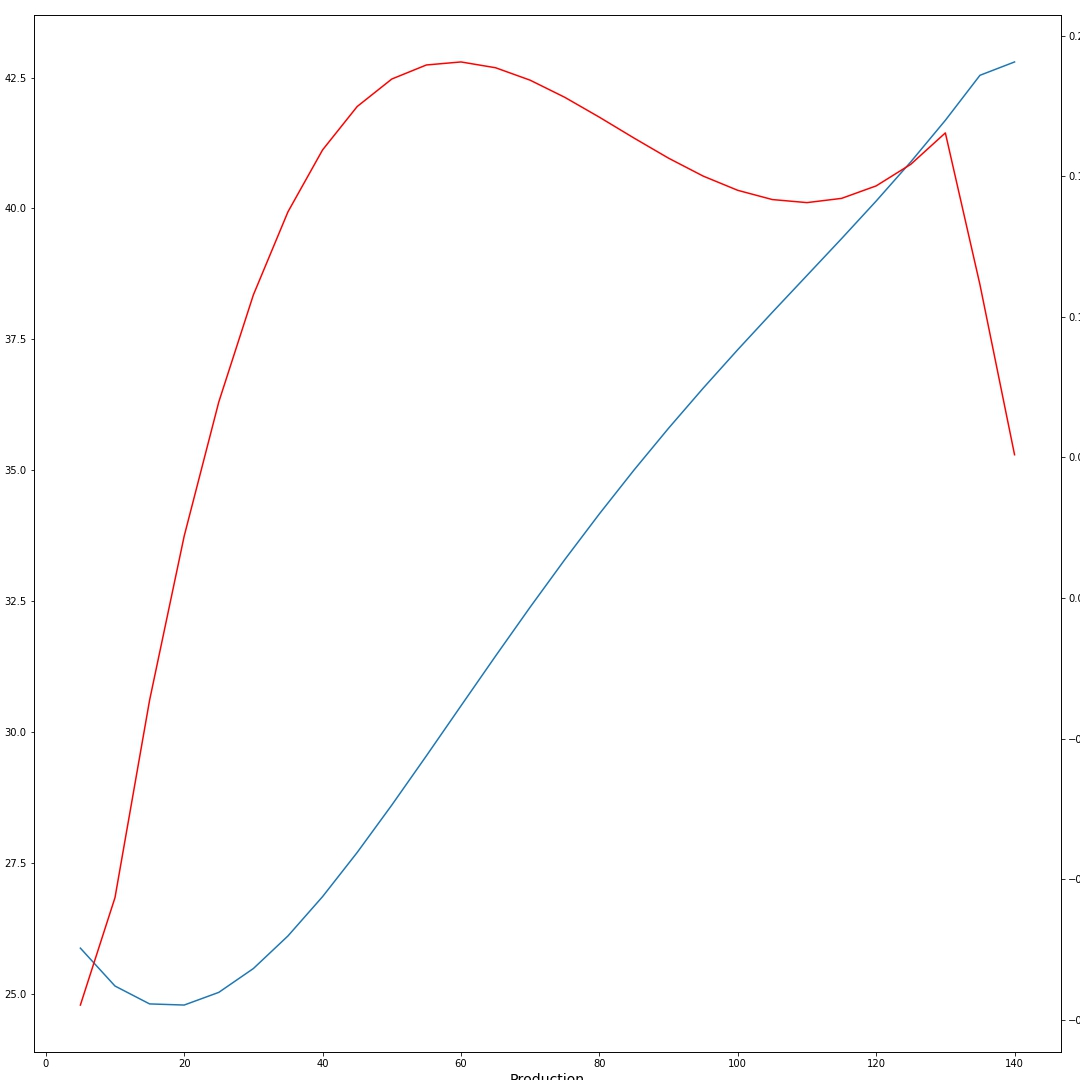

In [68]:
path_pump_pass = os.path.join(cWorkFolder, r'Данные для виртуальной расходометрии\Ноябрьск\информация для виртуального расходомера',
                 'ГРАД', oilfield_, r'Результаты\Pump passport\1982, Freq = 55.0, mu = 7.76.jpg')
Image(filename = path_pump_pass, width=500, height=500) 

Характеристика насоса на частоте 55 Гц и вязкости 7.76 (Python)

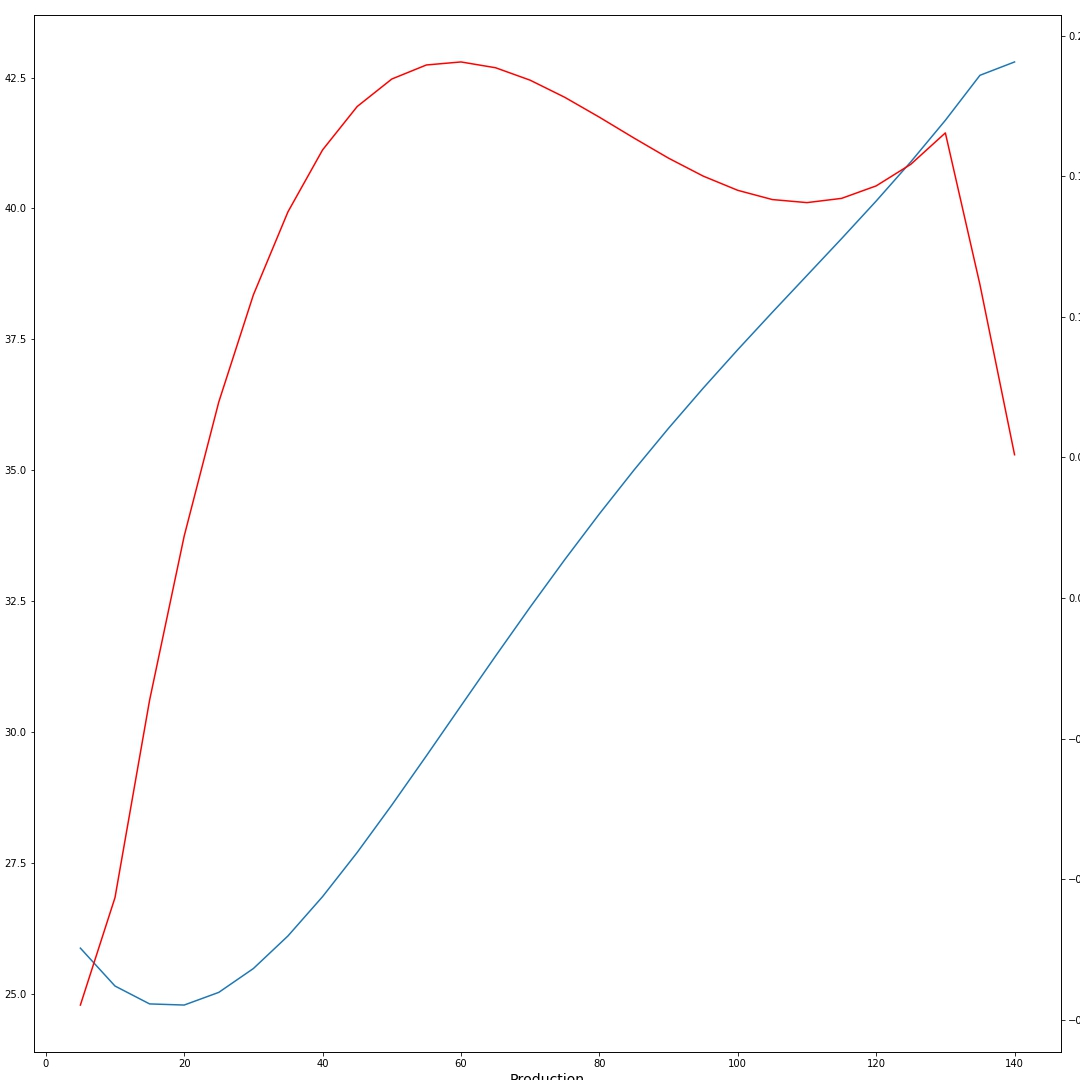

In [69]:
path_pump_pass = os.path.join(cWorkFolder, r'Данные для виртуальной расходометрии\Ноябрьск\информация для виртуального расходомера',
                 'ГРАД', oilfield_, r'Результаты_py\Pump passport\1982, Freq = 55.0, mu = 7.76.jpg')
Image(filename = path_pump_pass, width=500, height=500) 

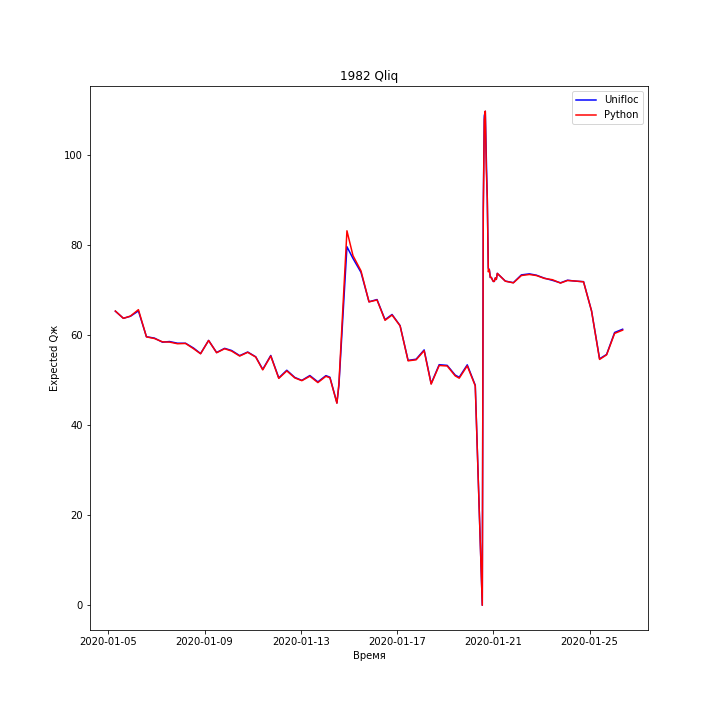

In [70]:
register_matplotlib_converters()
path = os.path.join(cWorkFolder, r'Данные для виртуальной расходометрии\Ноябрьск\информация для виртуального расходомера',
                      'ГРАД', oilfield_, r'Результаты_py\predicted_qliq', well_name + '.png')
plt.figure(figsize = (10,10))
plt.title(well_name + ' Qliq')
plt.plot(df_res.index.values, expected_q_8h[0], color = 'b', label = 'Unifloc')
plt.plot(df_res.index.values, expected_q_8h_py[0], color = 'r', label = 'Python')
plt.xlabel('Время')
plt.ylabel('Expected Qж')
plt.legend()
plt.savefig(path, quality=100)
plt.close()
Image(filename = path, width=500, height=500) 